In [1]:
import os
import shutil
import math

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import transforms
from torchvision import datasets

from src.features.distort_images import distort_image
from src.utils import ycbcr2rgb
from src.utils import psnr
from src.utils import extract_patches_2d
from src.utils import dct_2d

from src.models.evaluate_models import evaluate_model

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

evaluate_model.DEVICE = device
SR_FACTOR = 3
SIGMA = 1.0


In [2]:
training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_gt_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)

training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/test/') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)
            


In [3]:
np.max(training_images_gt_patches)

255.0

In [4]:
training_images_gt_patches = np.array(training_images_gt_patches)
print(training_images_gt_patches.shape)

#normalize
training_images_gt_patches /= 255.0

train_pixel_mean = np.mean(training_images_gt_patches)
print(train_pixel_mean)
train_pixel_std = np.std(training_images_gt_patches)
print(train_pixel_std)
#standardize
training_images_gt_patches -= train_pixel_mean
training_images_gt_patches /= train_pixel_std

training_images_gt_patches = torch.tensor(training_images_gt_patches)

(211600, 32, 32)
0.43411854967058106
0.23247274722791464


In [5]:
training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_training_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/raw/BSDS500/data/images/train/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)
    print(idx)

training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/test/') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]

    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/raw/BSDS500/data/images/test/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)
    print(200+idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

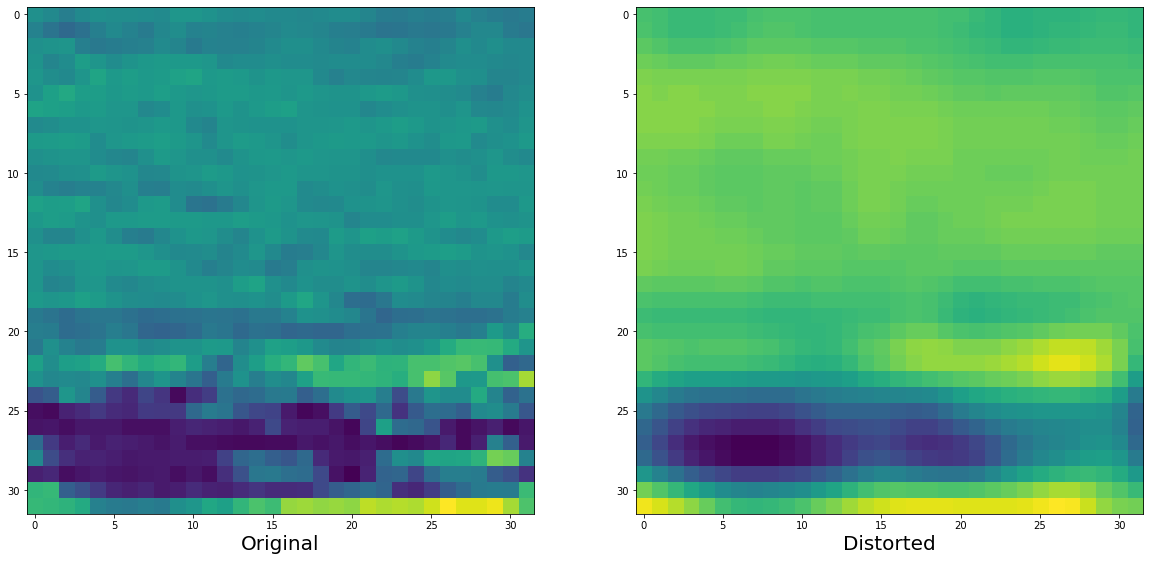

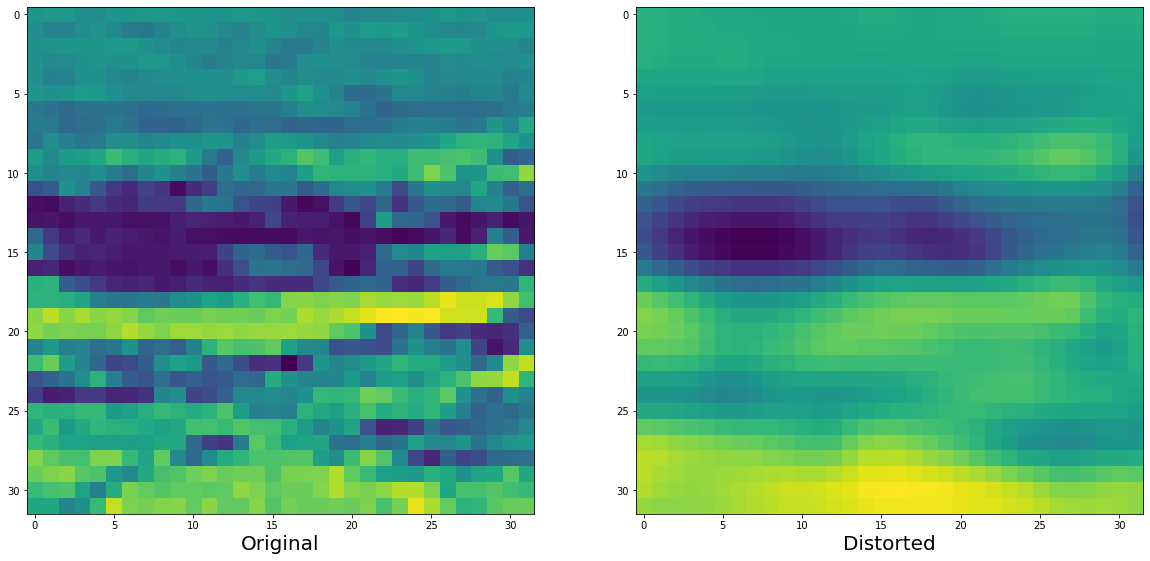

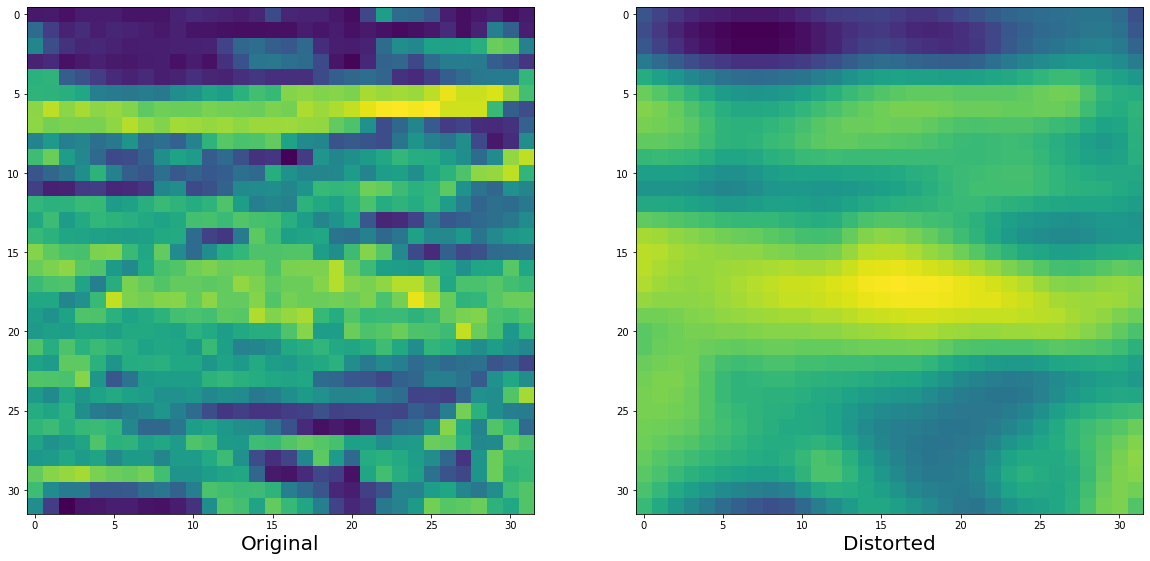

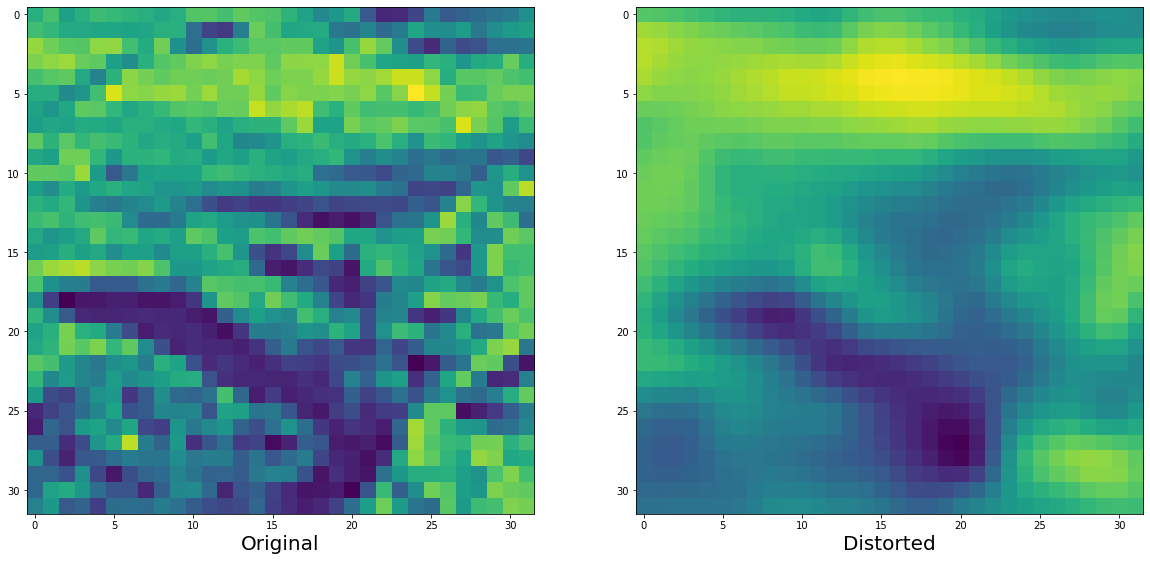

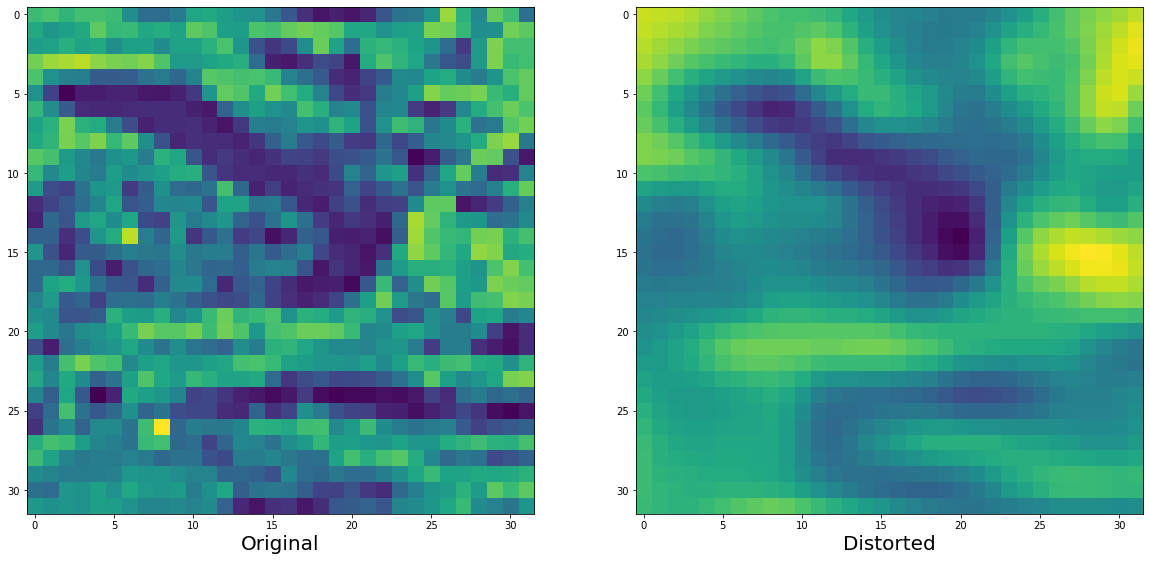

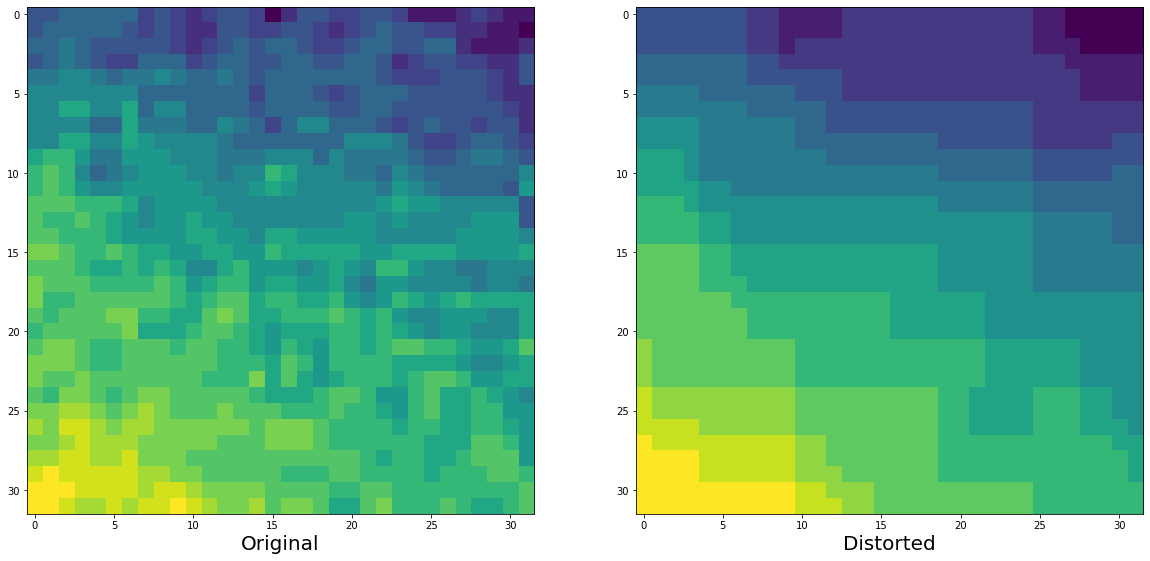

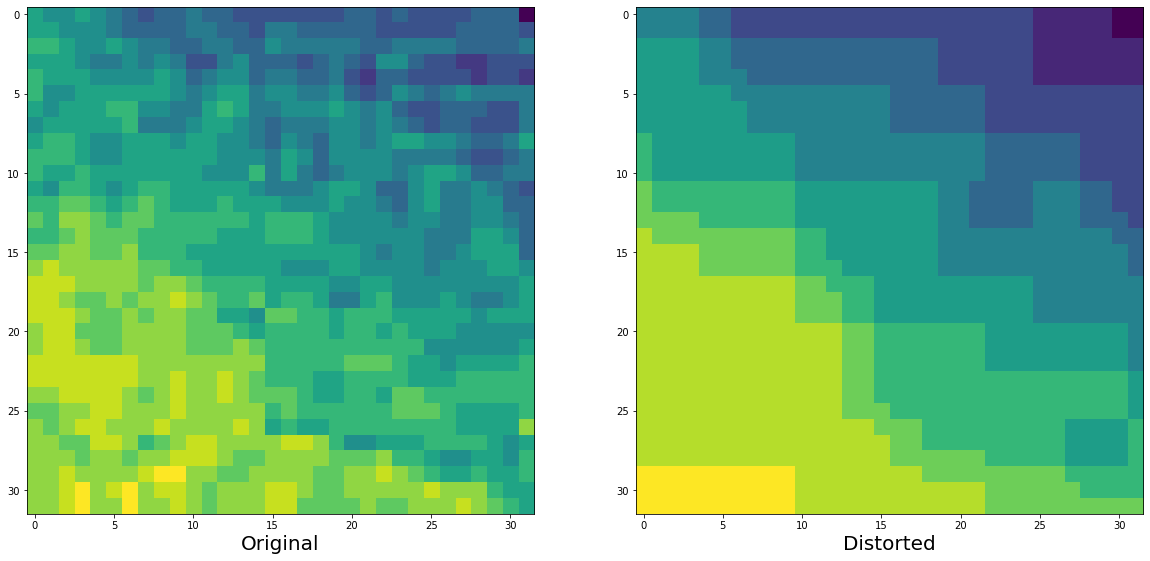

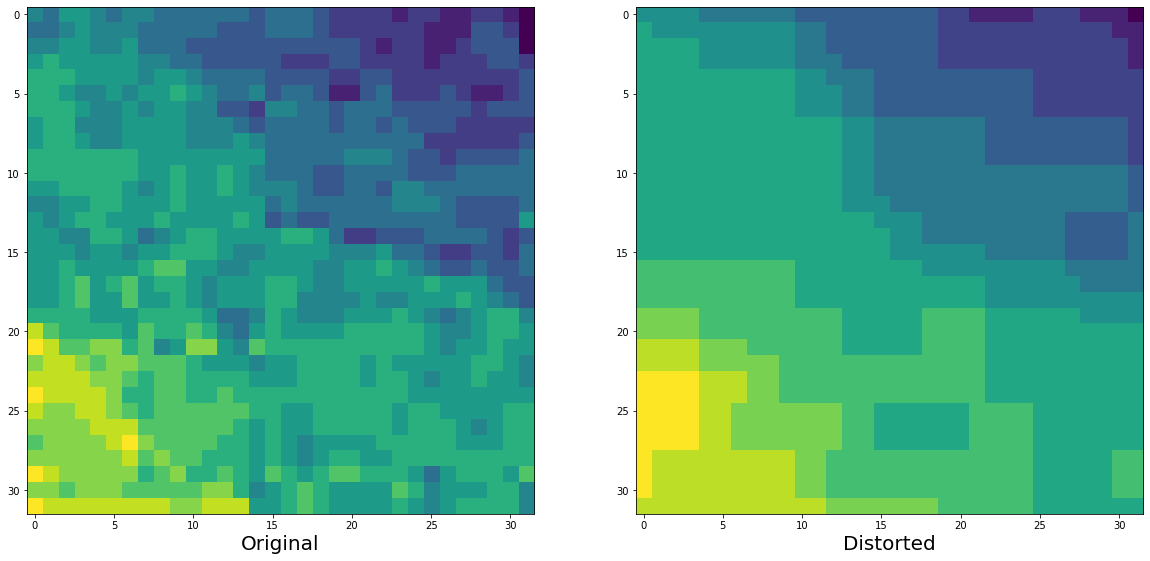

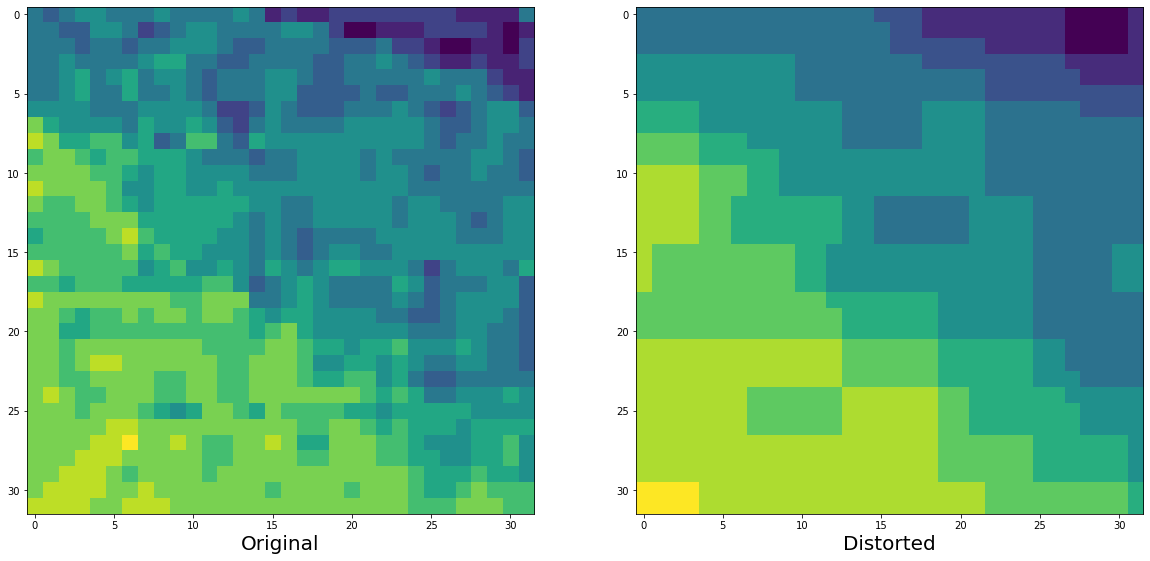

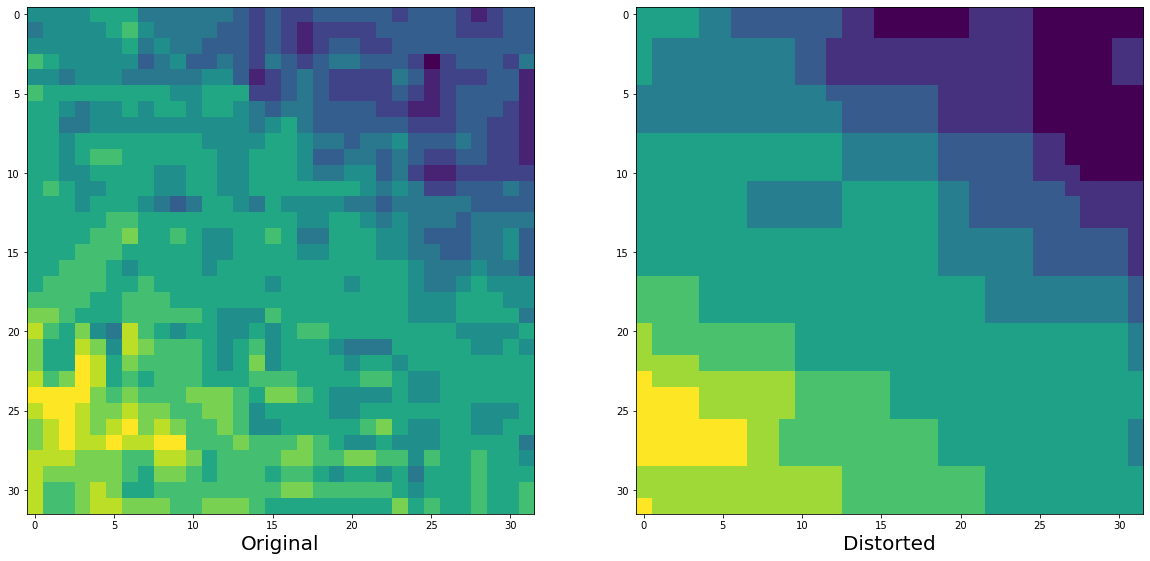

In [6]:
for i in range(10000,10010):
    
    f, axarr = plt.subplots(1,2, figsize=(20, 20))
    axarr[0].imshow(training_images_gt_patches[i])
    axarr[0].set_xlabel('Original', fontsize=20)

    axarr[1].imshow(training_images_training_patches[i])
    axarr[1].set_xlabel('Distorted', fontsize=20)


In [7]:
training_images_training_patches = np.array(training_images_training_patches)
print(training_images_training_patches.shape)

training_images_training_patches /= 255.0
training_images_training_patches -= train_pixel_mean
training_images_training_patches /= train_pixel_std

training_images_training_patches = torch.tensor(training_images_training_patches)
training_images_training_patches.shape


(211600, 32, 32)


torch.Size([211600, 32, 32])

In [8]:
my_training_dataset = data.TensorDataset(training_images_training_patches, training_images_gt_patches)
my_dataloader = data.DataLoader(my_training_dataset,
                                batch_size=128,
                                shuffle=True,
                                drop_last=True)

In [9]:
val_img_names = [img for img in os.listdir('./data/raw/BSDS500/data/images/val/') if img[-4:] == '.jpg']
val_images_gt_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/val/'+img_name)
    im_val = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_val_Y = im_val[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_val_Y.shape[0]/8) * 8
    max_y = int(im_val_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_val_Y = im_val_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_val_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_val_Y.shape[0]-32, 13):
            sub_im = im_val_Y[j:j+32, i:i+32]
            val_images_gt_patches.append(sub_im)
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
val_images_gt_patches = np.array(val_images_gt_patches)
print(val_images_gt_patches.shape)
#normalize
val_images_gt_patches /= 255.0
#standardize
val_images_gt_patches -= train_pixel_mean
val_images_gt_patches /= train_pixel_std

val_images_gt_patches = torch.tensor(val_images_gt_patches)
val_images_gt_patches.shape


(52900, 32, 32)


torch.Size([52900, 32, 32])

In [11]:
val_images_val_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/val/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/raw/BSDS500/data/images/val/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)

    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            val_images_val_patches.append(sub_im)
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [12]:
val_images_val_patches = np.array(val_images_val_patches)
print(val_images_val_patches.shape)
#normalize
val_images_val_patches /= 255.0
#standardize
val_images_val_patches -= train_pixel_mean
val_images_val_patches /= train_pixel_std

val_images_val_patches = torch.tensor(val_images_val_patches)
val_images_val_patches.shape


(52900, 32, 32)


torch.Size([52900, 32, 32])

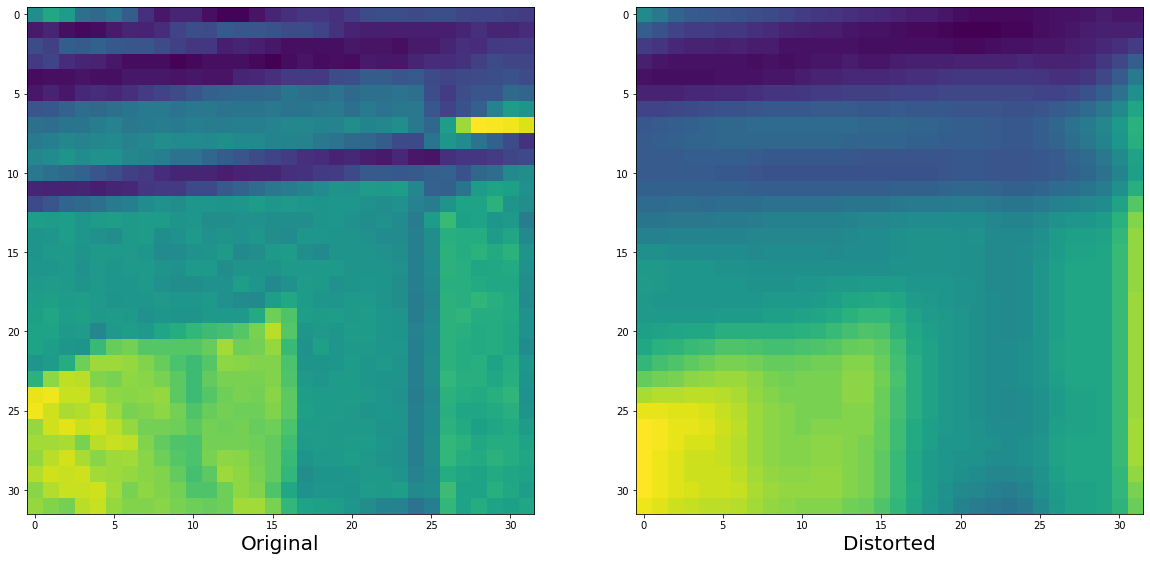

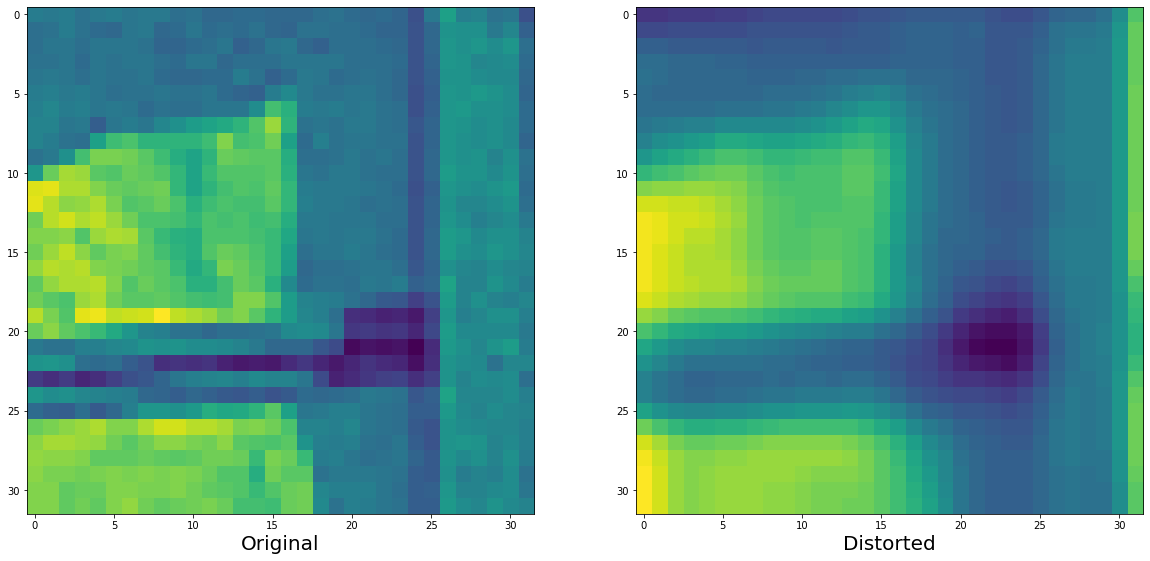

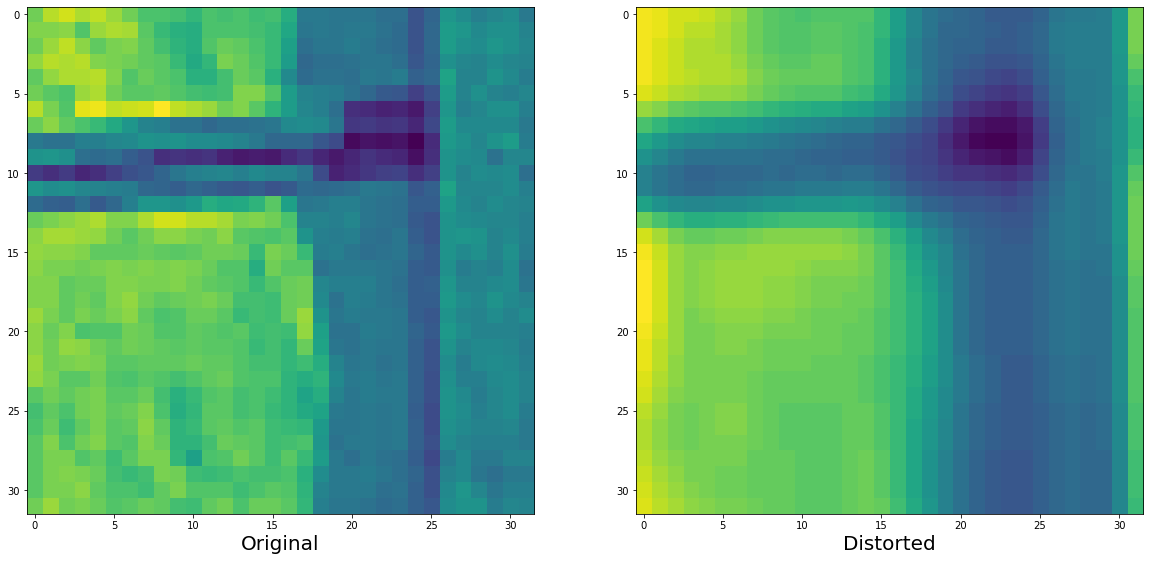

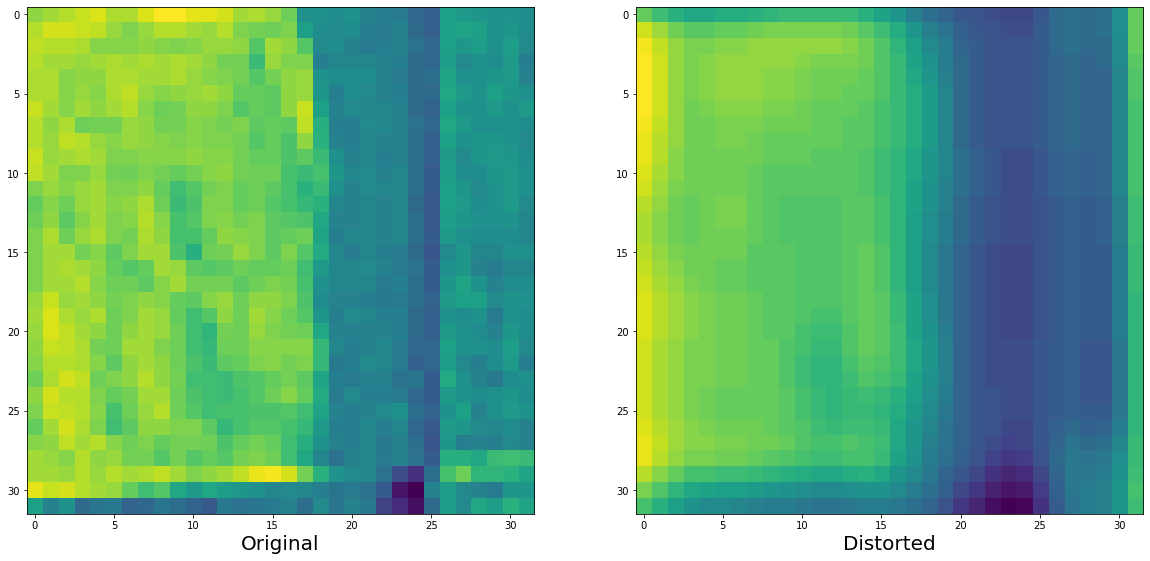

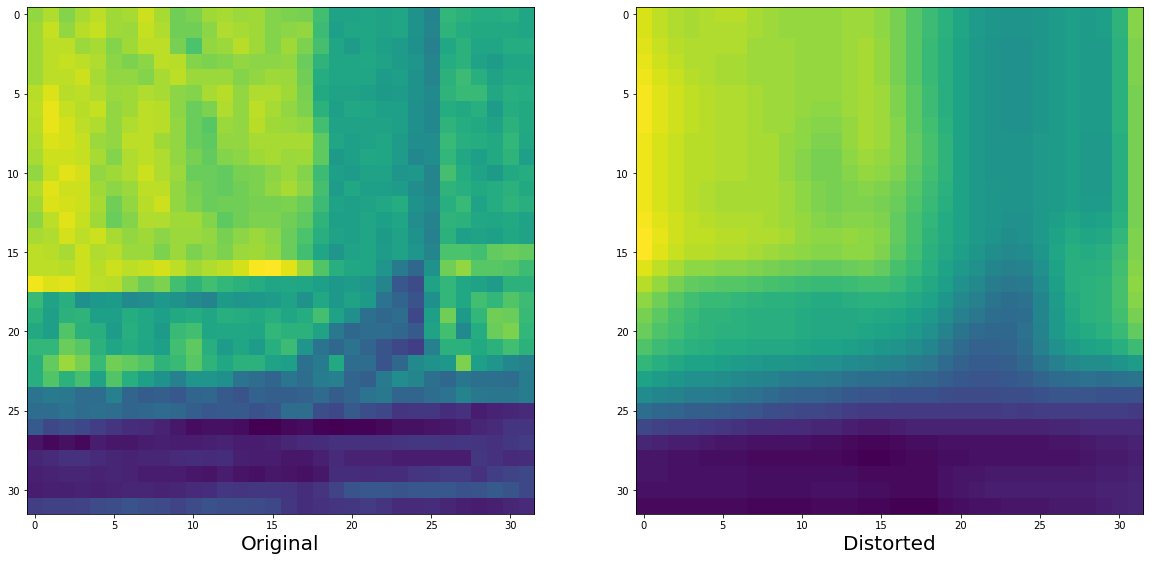

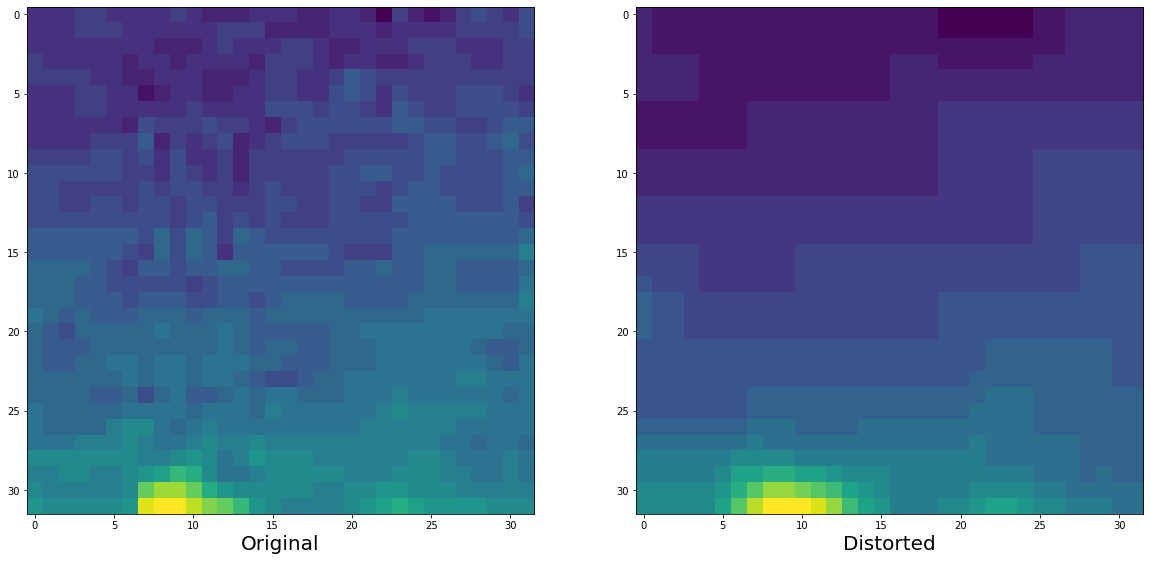

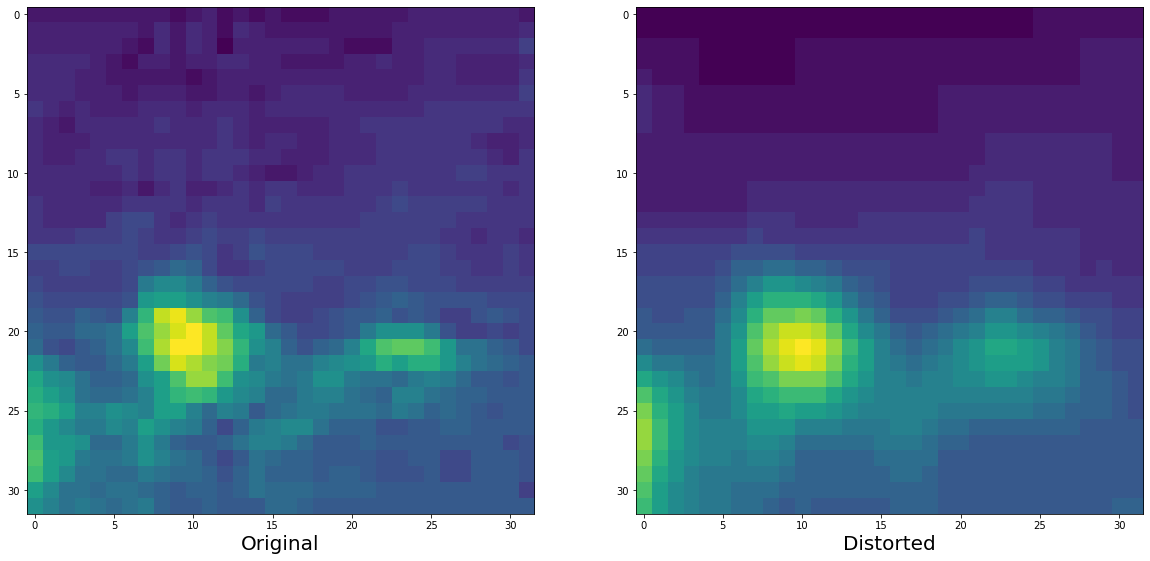

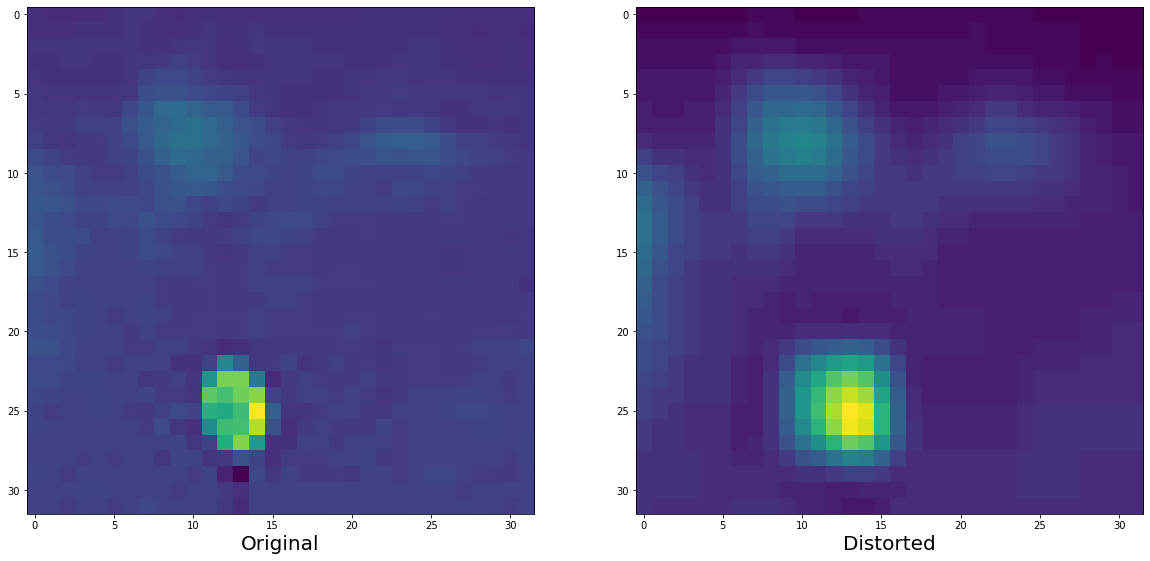

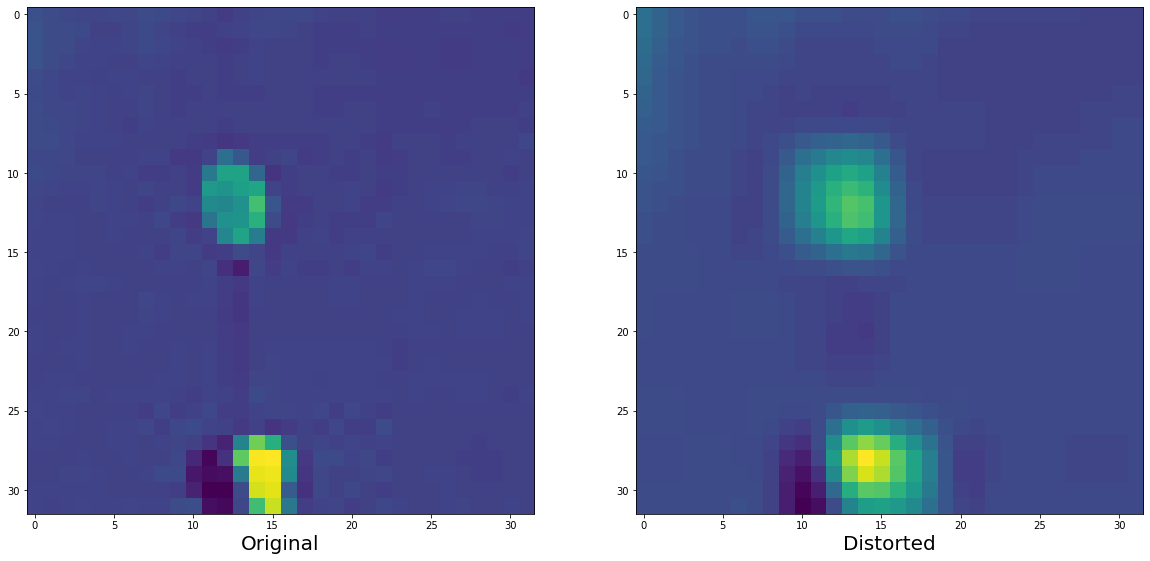

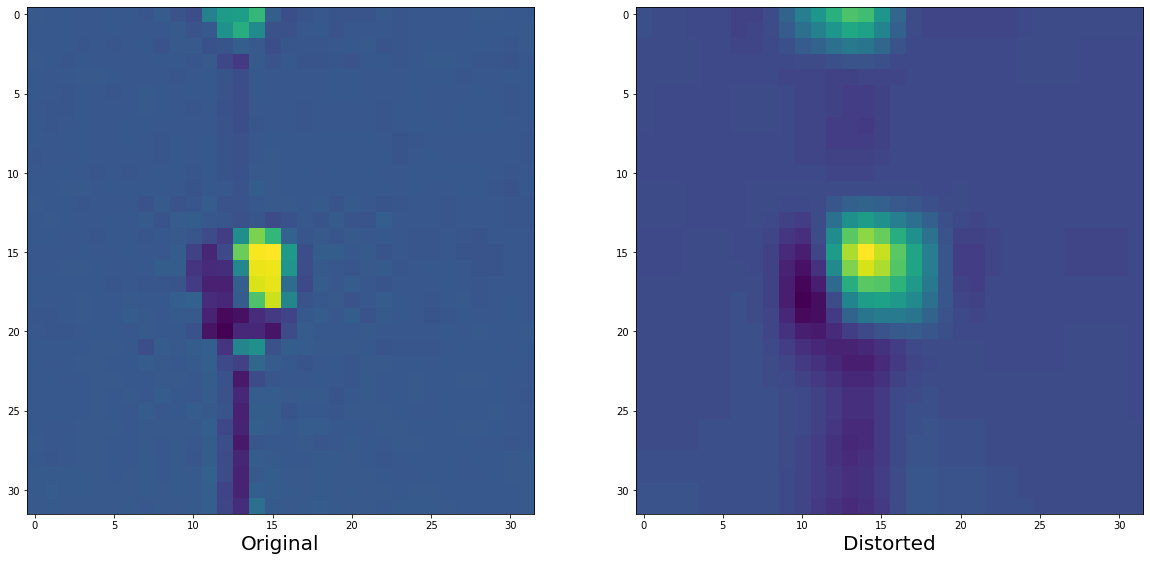

In [13]:
for i in range(10000,10010):
    
    f, axarr = plt.subplots(1,2, figsize=(20, 20))
    axarr[0].imshow(val_images_gt_patches[i])
    axarr[0].set_xlabel('Original', fontsize=20)

    axarr[1].imshow(val_images_val_patches[i])
    axarr[1].set_xlabel('Distorted', fontsize=20)


In [14]:
my_val_dataset = data.TensorDataset(val_images_val_patches, val_images_gt_patches)
my_val_dataloader = data.DataLoader(my_val_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    drop_last=True)


In [15]:
class FDPL_weighted(nn.Module):
    """
        Loss function taking the MSE between the 2D DCT coefficients
        of predicted and target images or an image channel.
        DCT coefficients are computed for each 8x8 block of the image
    
    """
    def __init__(self, perceptual_weights):
        """
            qt_Y (numpy.ndarray): the 8x8 quantization table used for JPEG compression
                on the luminance/Y clannel
        """
        self.perceptual_weights = perceptual_weights
        super(FDPL_weighted, self).__init__()

    def forward(self, predictions, targets):
        """
            Args:
                predictions (torch.tensor): output of an image transformation model.
                    shape: batch_size x 1 x H x W
                targets (torch.tensor): ground truth images corresponding to outputs
                    shape: batch_size x H x W
                criterion (torch.nn.MSELoss): object used to calculate MSE

            Returns:
                loss (float): MSE between predicted and ground truth 2D DCT coefficients
        """
        #get DCT coefficients of ground truth patches
        patches = extract_patches_2d(img=targets.unsqueeze(1), patch_shape=(8,8), batch_first=True)
        ground_truth_dct = dct_2d(patches, norm='ortho')

        #get DCT coefficients of transformed images
        patches = extract_patches_2d(img=outputs, patch_shape=(8,8), batch_first=True)
        outputs_dct = dct_2d(patches, norm='ortho')
        loss = torch.sum(((outputs_dct.double() - ground_truth_dct.double()).pow(2))*self.perceptual_weights)
        return loss

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=7, padding=3)
        
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv1.bias)
        
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv2.bias)
        
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv3.bias)

    def forward(self, img):
        out = F.relu(self.conv1(img))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out


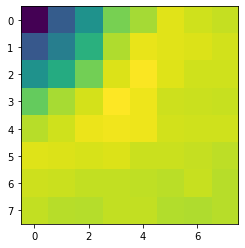

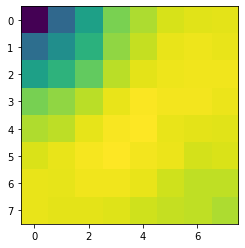

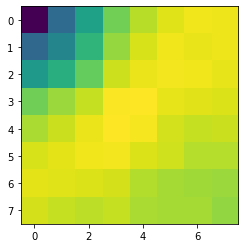

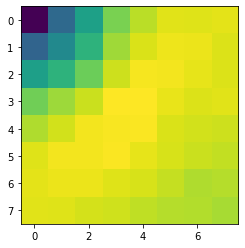

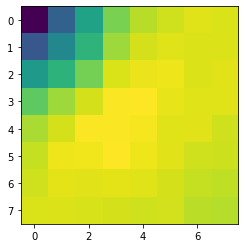

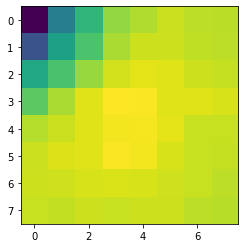

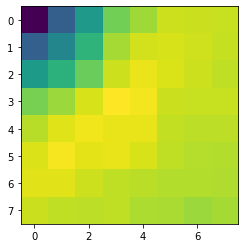

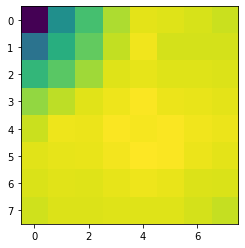

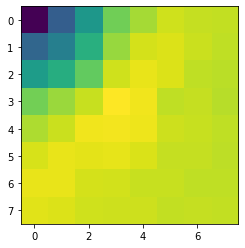

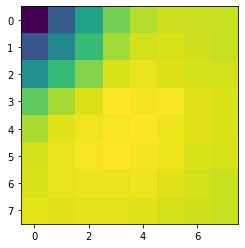

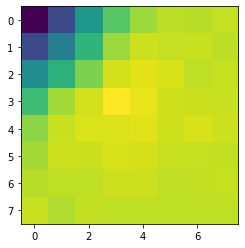

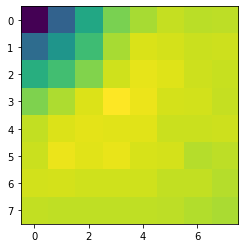

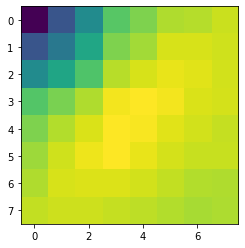

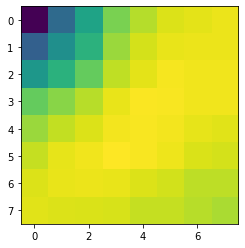

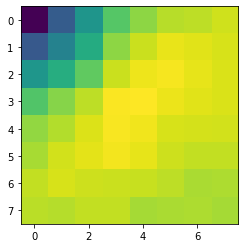

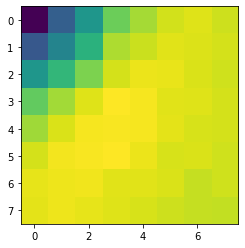

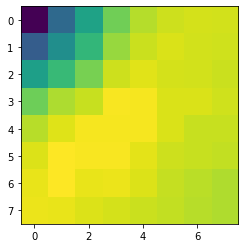

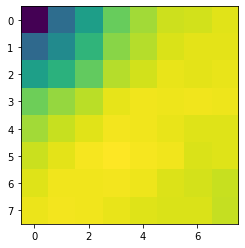

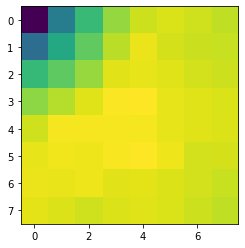

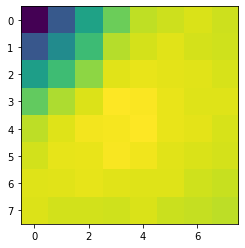

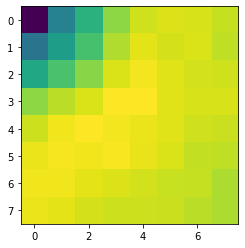

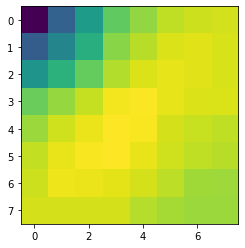

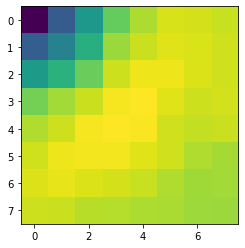

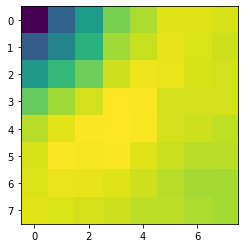

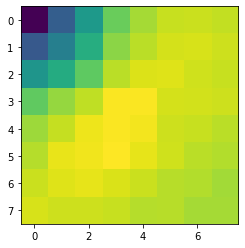

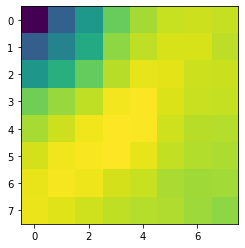

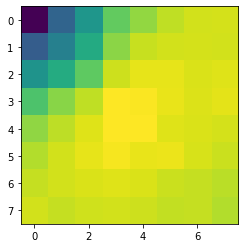

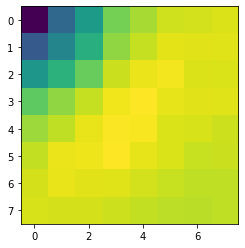

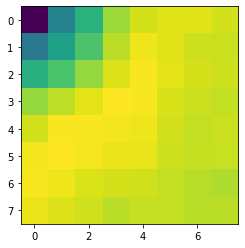

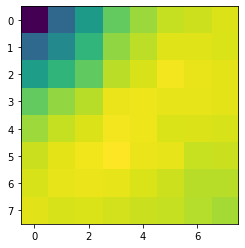

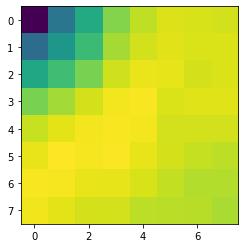

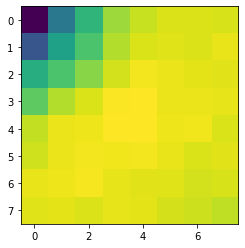

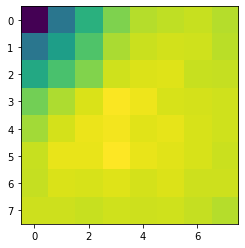

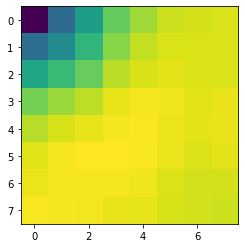

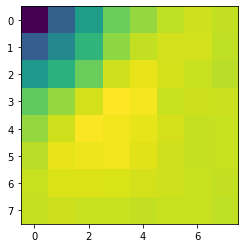

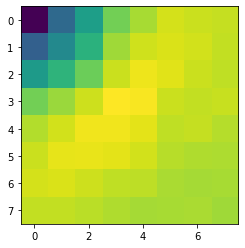

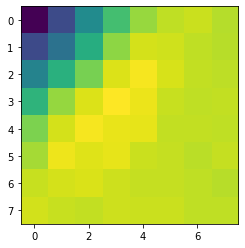

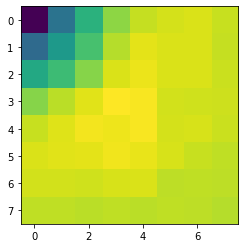

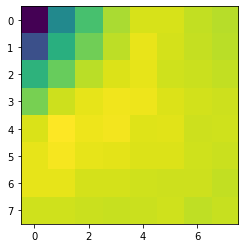

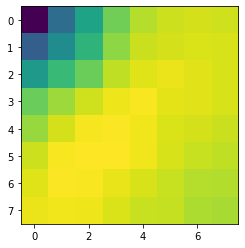

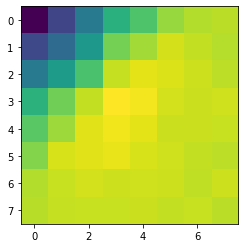

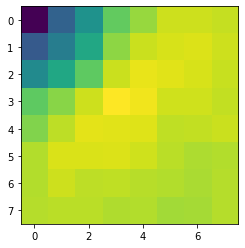

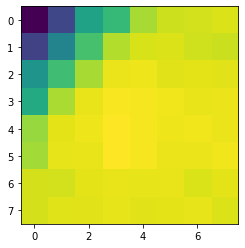

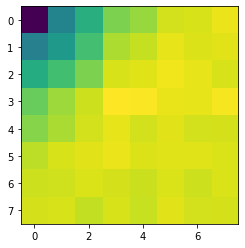

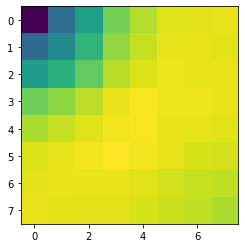

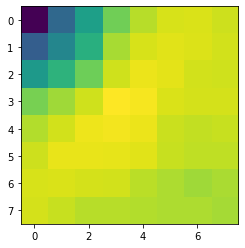

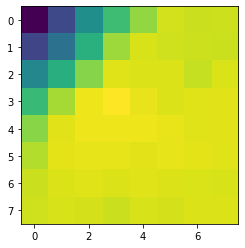

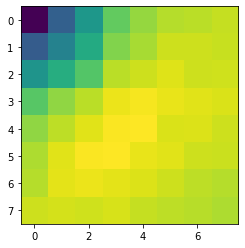

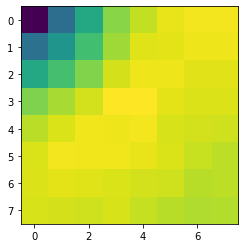

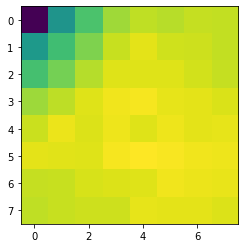

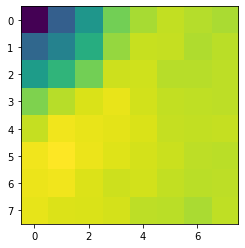

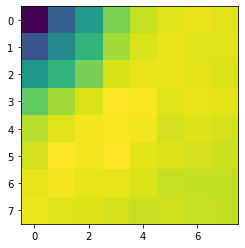

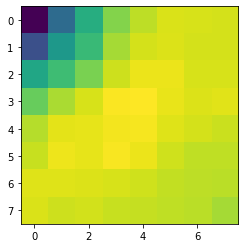

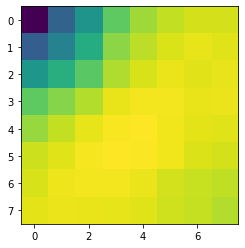

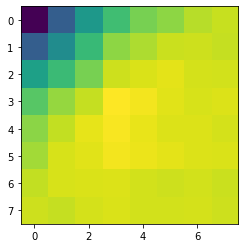

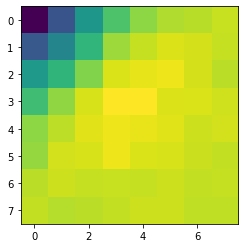

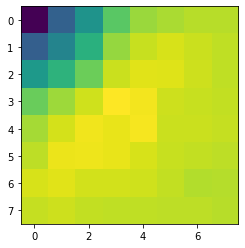

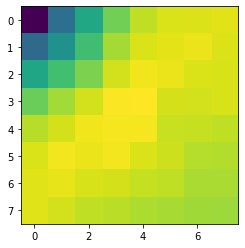

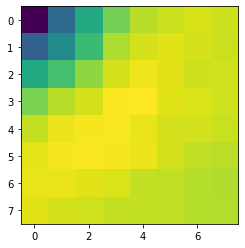

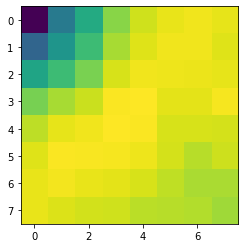

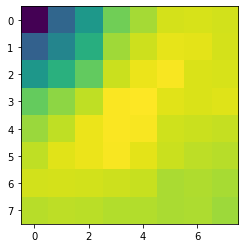

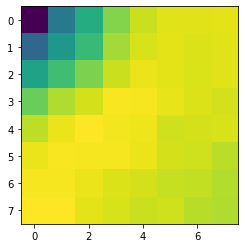

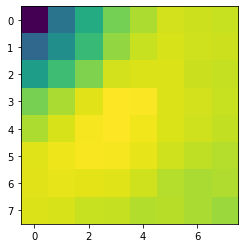

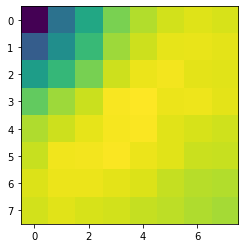

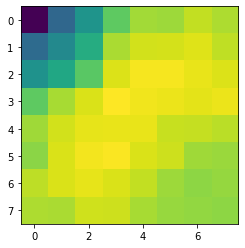

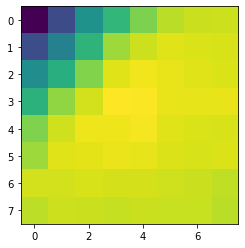

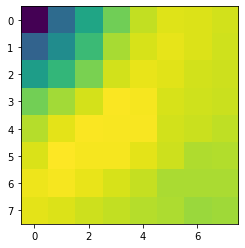

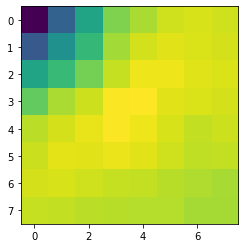

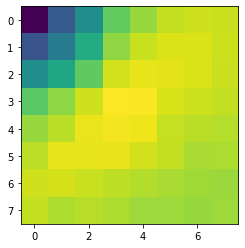

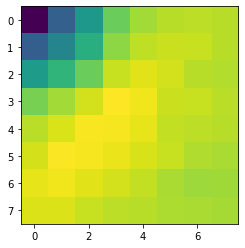

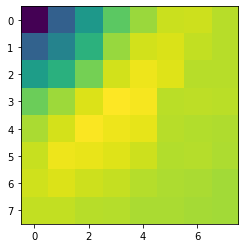

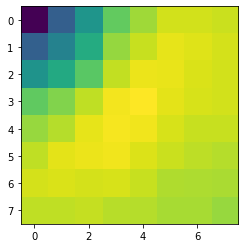

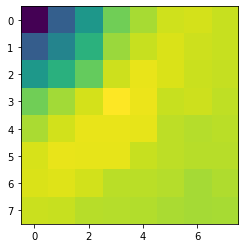

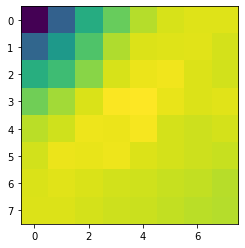

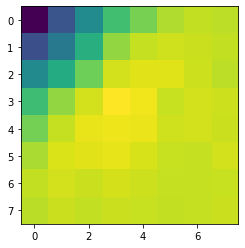

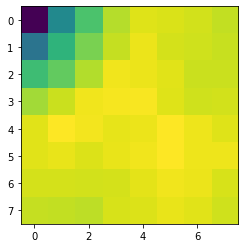

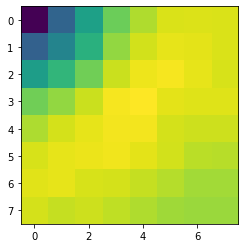

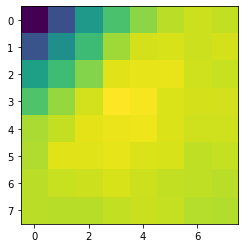

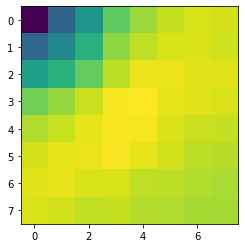

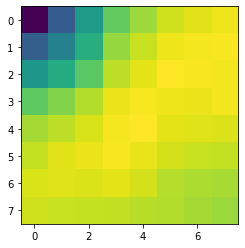

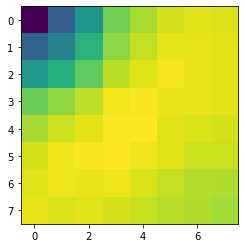

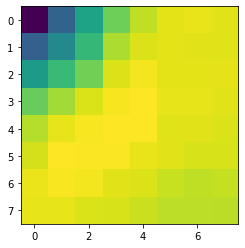

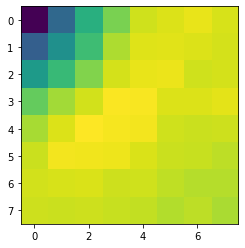

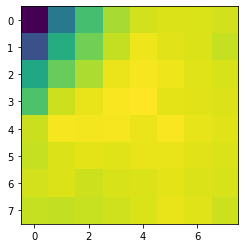

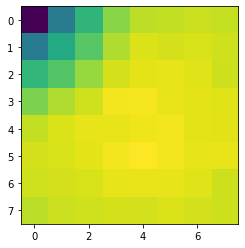

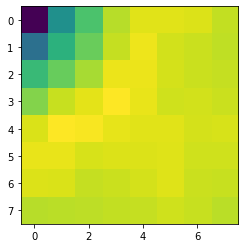

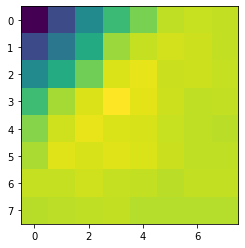

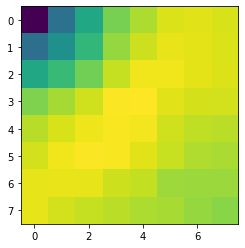

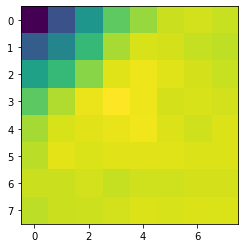

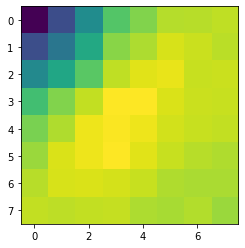

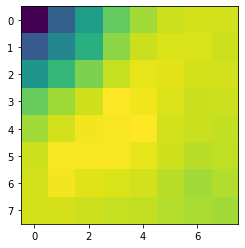

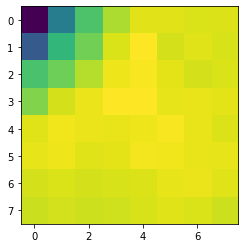

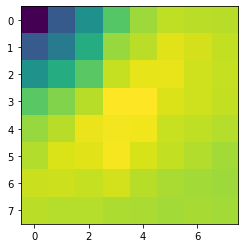

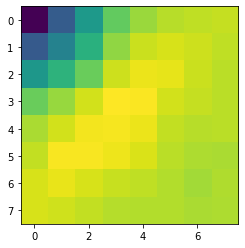

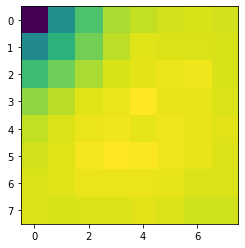

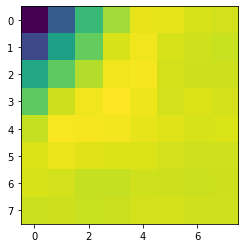

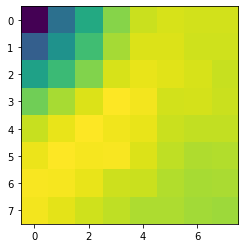

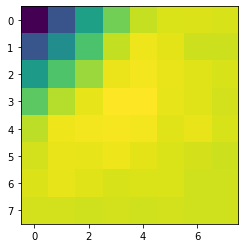

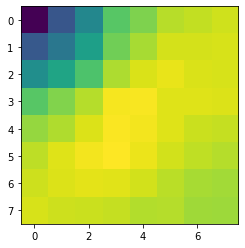

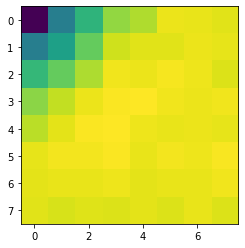

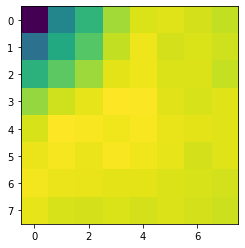

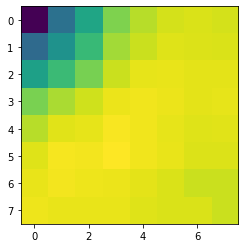

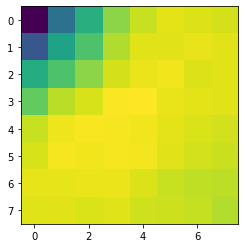

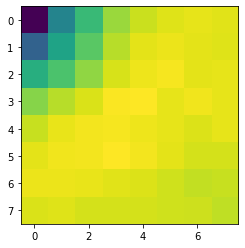

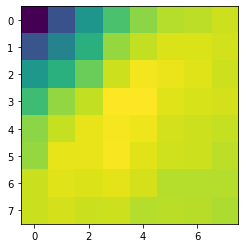

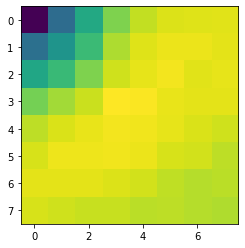

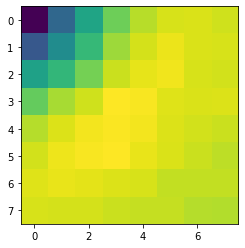

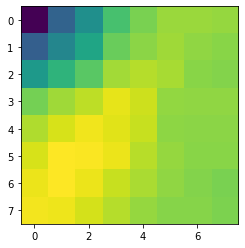

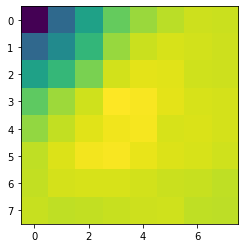

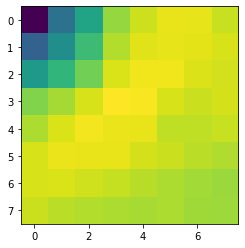

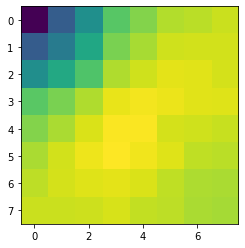

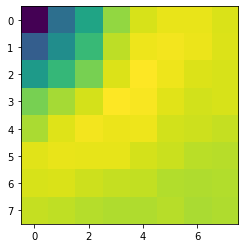

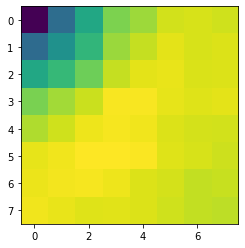

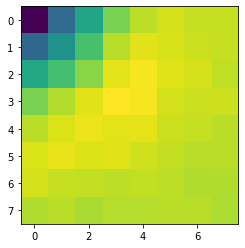

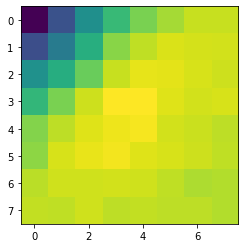

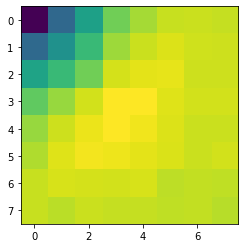

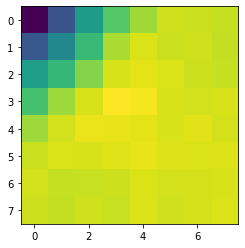

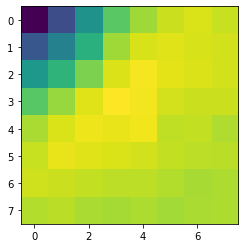

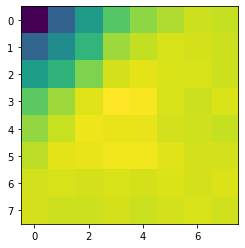

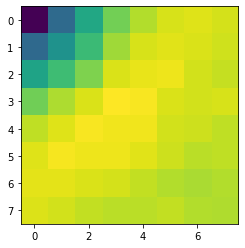

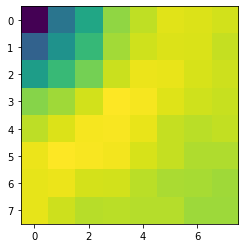

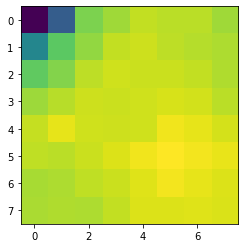

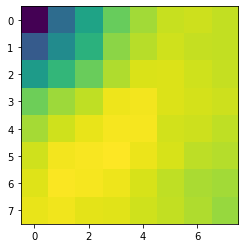

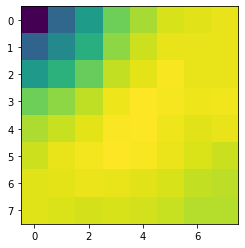

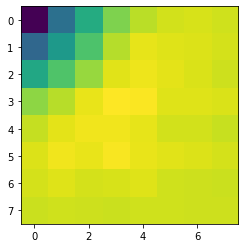

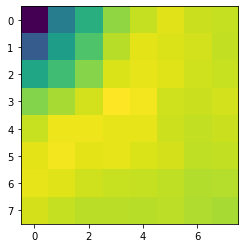

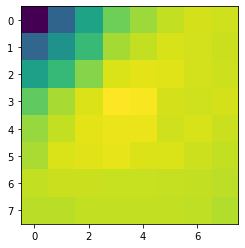

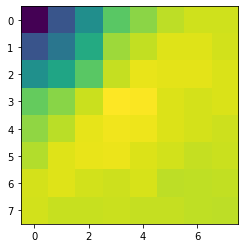

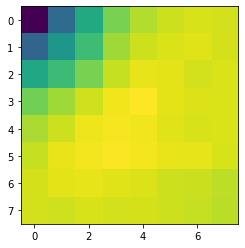

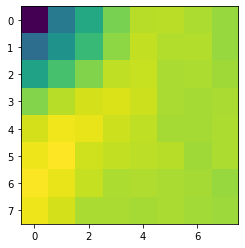

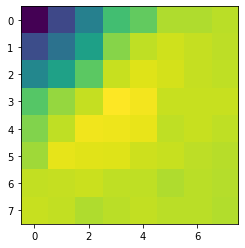

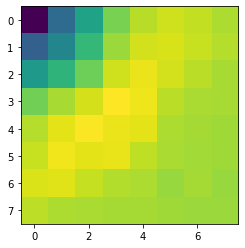

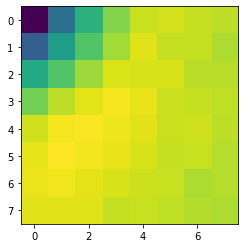

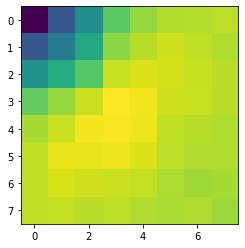

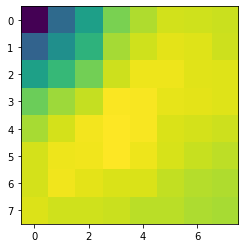

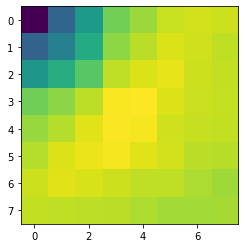

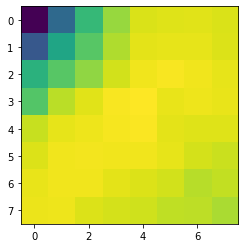

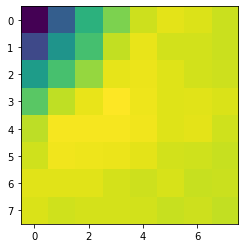

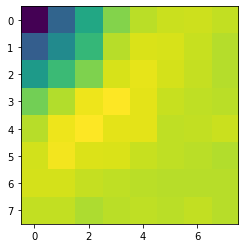

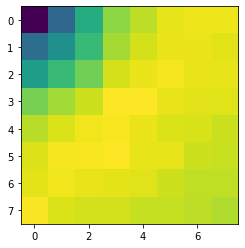

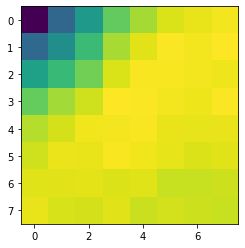

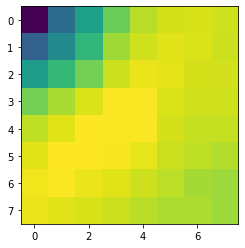

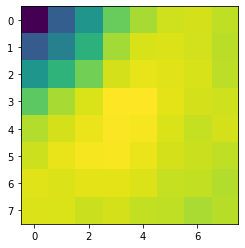

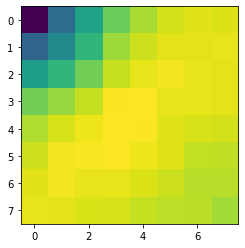

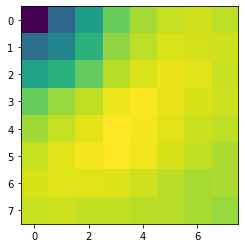

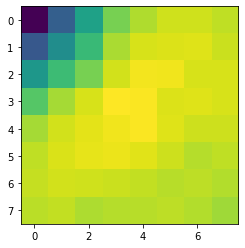

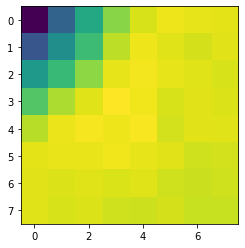

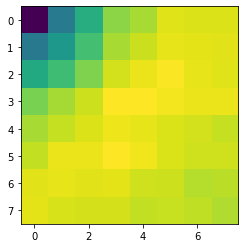

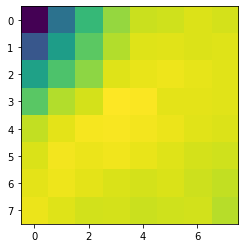

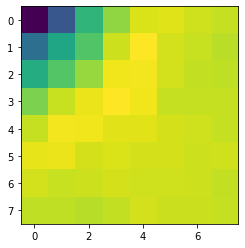

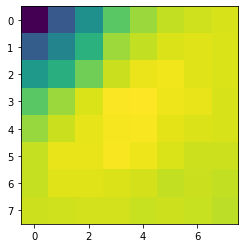

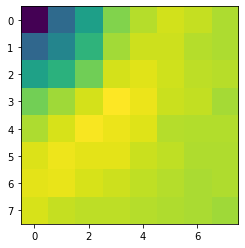

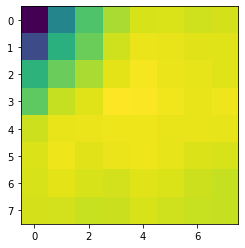

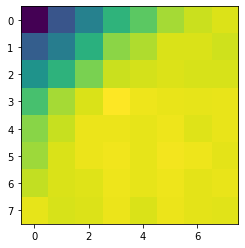

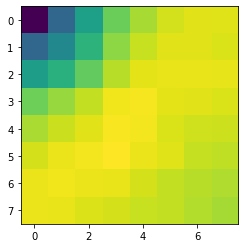

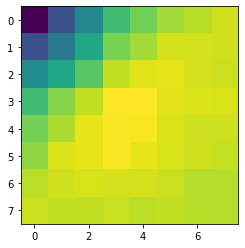

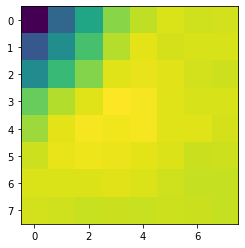

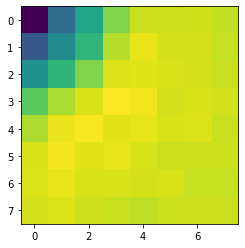

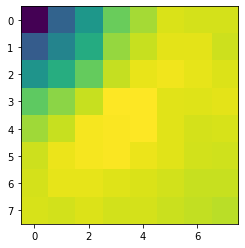

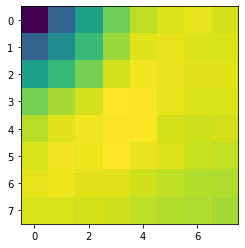

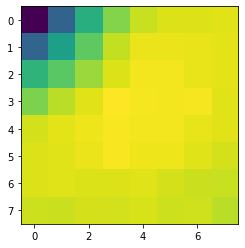

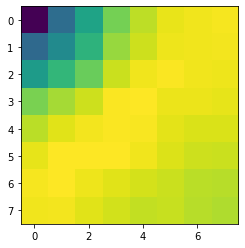

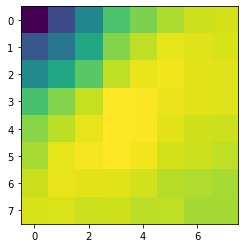

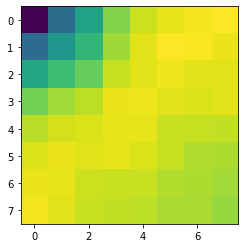

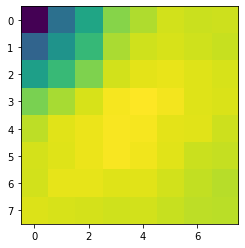

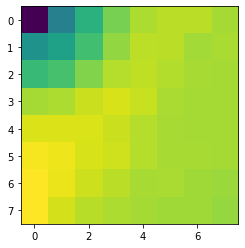

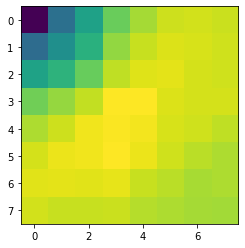

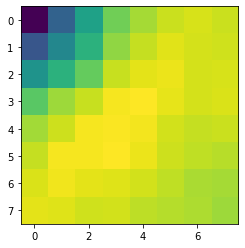

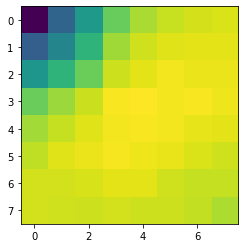

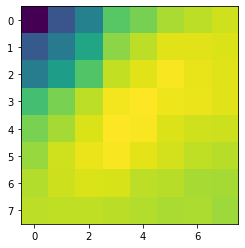

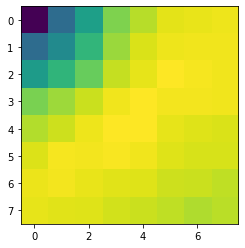

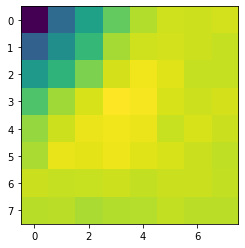

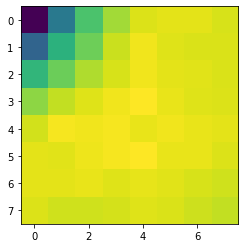

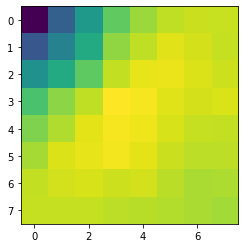

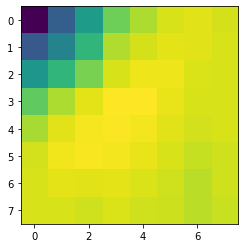

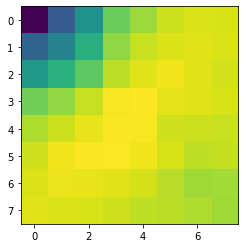

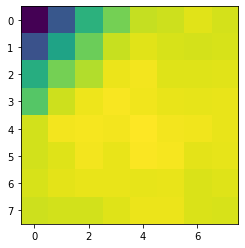

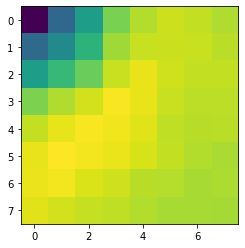

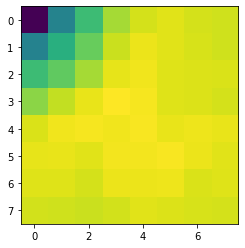

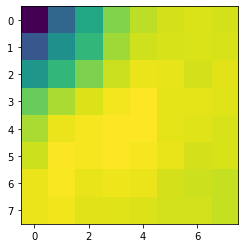

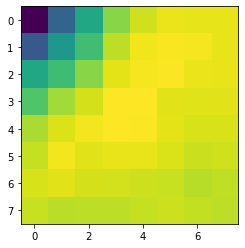

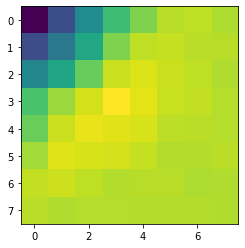

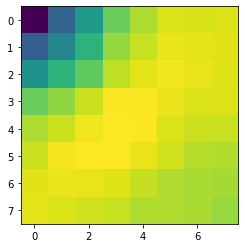

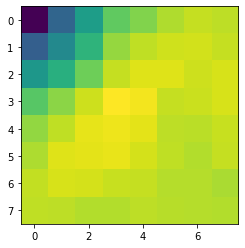

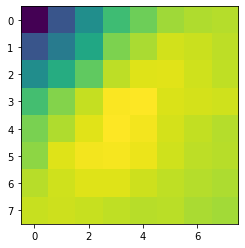

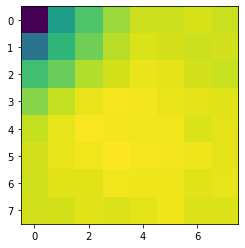

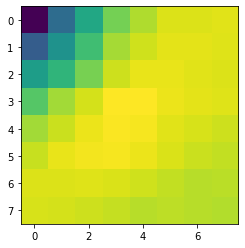

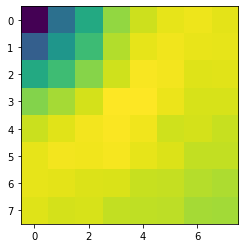

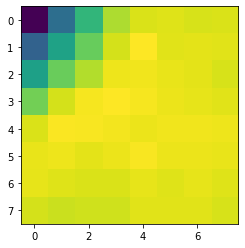

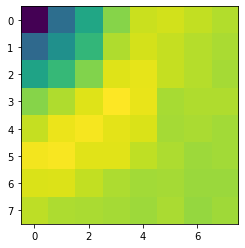

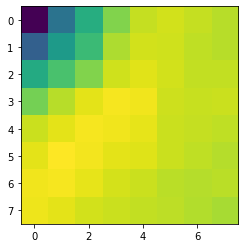

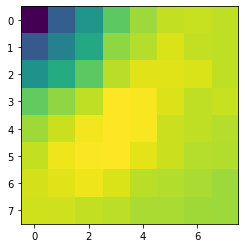

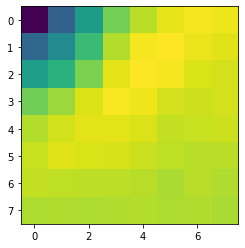

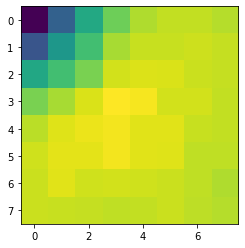

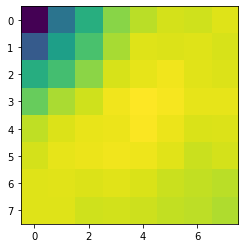

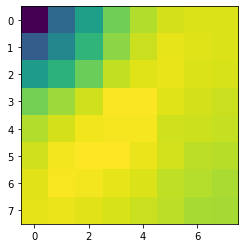

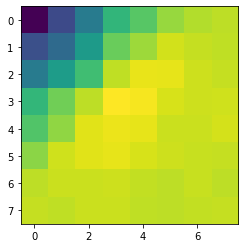

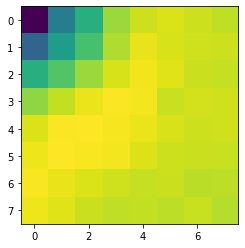

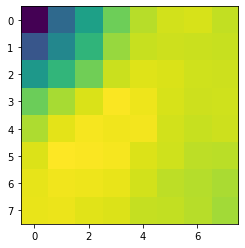

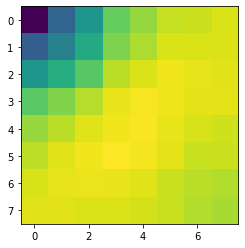

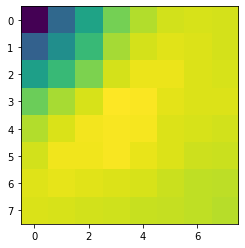

In [16]:
# calculate the perceptual weights
master_diff = np.zeros((8,8))
num_patches = 0
all_diff_patches = []
training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
for im_name in training_img_names:
    ImageFile = Image.open('./data/raw/BSDS500/data/images/train/'+im_name)
    im = np.array(ImageFile.convert('YCbCr'))
    im_Y, im_Cb, im_Cr = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/raw/BSDS500/data/images/train/'+im_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[:, :, 0].astype(np.float)
    image_diff_patch = np.zeros((8,8))
    for i in range(0, im_Y.shape[1]-8, 8): #every patch vertically with stride 8
        for j in range(0, im_Y.shape[0]-8, 8):
            clear_patch = im_Y[j:j+8, i:i+8]
            clear_patch_dct = dct_2d(torch.tensor(clear_patch, dtype=torch.float).to(device), norm='ortho')
            blur_patch = im_Y_blur[j:j+8, i:i+8]
            blur_patch_dct = dct_2d(torch.tensor(blur_patch, dtype=torch.float).to(device), norm='ortho')

            patch_diff = torch.abs(blur_patch_dct - clear_patch_dct).cpu().numpy()
            patch_diff /= (((torch.abs(clear_patch_dct) + torch.abs(blur_patch_dct)).cpu().numpy())/2)+0.0000000000001

            master_diff += patch_diff
            image_diff_patch += patch_diff
            num_patches += 1
            all_diff_patches.append(patch_diff)
    plt.imshow(image_diff_patch)
    plt.show()

diff_patches = np.zeros((num_patches, 8, 8))
for i, patch in enumerate(all_diff_patches):
    diff_patches[i] = patch
plt.imshow(master_diff)

[[0.01840373 0.58999538 0.99887572 1.35731124 1.51378647 1.59615814
  1.60794642 1.59768487]
 [0.54538216 0.85649201 1.15733541 1.48270578 1.60280835 1.63332936
  1.6204338  1.60154382]
 [0.97357237 1.15783744 1.37431718 1.6003753  1.66259869 1.65741183
  1.62199538 1.60600917]
 [1.32983939 1.48646416 1.60701991 1.70982965 1.70294495 1.63899384
  1.62378931 1.61771147]
 [1.51241334 1.61619203 1.6781811  1.69350727 1.68488638 1.62312361
  1.60460837 1.59458518]
 [1.59135561 1.67050663 1.67614207 1.69062219 1.6559363  1.61859251
  1.58166148 1.57357605]
 [1.62406025 1.64713876 1.63513799 1.6238076  1.6050742  1.57471174
  1.5501197  1.54399399]
 [1.6153739  1.60502484 1.59157153 1.58655249 1.57093044 1.56278208
  1.54476926 1.52678157]]


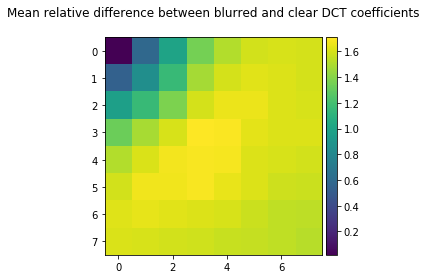

In [17]:
diff_means = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        diff_means[i,j] = np.mean(diff_patches[:,i,j])

print(diff_means)

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(diff_means)
ax.set_title("Mean relative difference between blurred and clear DCT coefficients\n")
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()


In [16]:
diff_means = torch.load('./diff_means.pt')
diff_means

array([[0.01840373, 0.58999538, 0.99887572, 1.35731124, 1.51378647,
        1.59615814, 1.60794642, 1.59768487],
       [0.54538216, 0.85649201, 1.15733541, 1.48270578, 1.60280835,
        1.63332936, 1.6204338 , 1.60154382],
       [0.97357237, 1.15783744, 1.37431718, 1.6003753 , 1.66259869,
        1.65741183, 1.62199538, 1.60600917],
       [1.32983939, 1.48646416, 1.60701991, 1.70982965, 1.70294495,
        1.63899384, 1.62378931, 1.61771147],
       [1.51241334, 1.61619203, 1.6781811 , 1.69350727, 1.68488638,
        1.62312361, 1.60460837, 1.59458518],
       [1.59135561, 1.67050663, 1.67614207, 1.69062219, 1.6559363 ,
        1.61859251, 1.58166148, 1.57357605],
       [1.62406025, 1.64713876, 1.63513799, 1.6238076 , 1.6050742 ,
        1.57471174, 1.5501197 , 1.54399399],
       [1.6153739 , 1.60502484, 1.59157153, 1.58655249, 1.57093044,
        1.56278208, 1.54476926, 1.52678157]])

In [17]:
qt_Y = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                 [12, 12, 14, 19, 26, 58, 60, 55],
                 [14, 13, 16, 24, 40, 57, 69, 56],  
                 [14, 17, 22, 29, 51, 87, 80, 62],  
                 [18, 22, 37, 56, 68, 109, 103, 77],   
                 [24, 35, 55, 64, 81, 104, 113, 92],  
                 [49, 64, 78, 87, 103, 121, 120, 101],  
                 [72, 92, 95, 98, 112, 100, 103, 99]])


In [18]:
"""
    Reasoning behind this perceptual weight matrix: JPEG gives as a model of frequencies that are important 
    for human perception. In that model, lower frequencies are more important than higher frequencies. Because
    of this, the higher frequencies are the first to go during compression. As compression increases, the affect
    spreads to the lower frequencies, which degrades perceptual quality. But when the lower frequencies are
    preserved, JPEG does an excellent job of compression without a noticible loss of quality.
    In super resolution, we already have the low frequencies. In fact that is really all we have in the low
    resolution images.
    As evidinced by the diff_means matric above, what is lost in the SR images is the mid-range frequencies; 
    those across and towards the centre of the diagional. We can bias our model to recover these frequencies
    by having our loss function prioritize these coefficients, with priority determined by the magnitude of 
    relative change between the low-res and high-res images. But we can take this further and into a true 
    preceptual loss by further prioritizing DCT coefficients by the importance that has been assigned to them 
    by the JPEG quantization table. That is how the table below is created. 
    
    The problem is that we don't know if the JPEG model is optimal. So there is room for qualitative evaluation
    of the quantization table values. We can further our perspective weights deleting each in turn for a small
    set of images and evaluating the resulting change in percieved quality. I can do this on my own to start and 
    if it works, I can do a small user study to determine this. 
"""

perceptual_weights = (np.ones_like(qt_Y)/qt_Y)*diff_means
perceptual_weights = torch.tensor(perceptual_weights).to(device)
perceptual_weights


tensor([[0.0012, 0.0536, 0.0999, 0.0848, 0.0631, 0.0399, 0.0315, 0.0262],
        [0.0454, 0.0714, 0.0827, 0.0780, 0.0616, 0.0282, 0.0270, 0.0291],
        [0.0695, 0.0891, 0.0859, 0.0667, 0.0416, 0.0291, 0.0235, 0.0287],
        [0.0950, 0.0874, 0.0730, 0.0590, 0.0334, 0.0188, 0.0203, 0.0261],
        [0.0840, 0.0735, 0.0454, 0.0302, 0.0248, 0.0149, 0.0156, 0.0207],
        [0.0663, 0.0477, 0.0305, 0.0264, 0.0204, 0.0156, 0.0140, 0.0171],
        [0.0331, 0.0257, 0.0210, 0.0187, 0.0156, 0.0130, 0.0129, 0.0153],
        [0.0224, 0.0174, 0.0168, 0.0162, 0.0140, 0.0156, 0.0150, 0.0154]],
       device='cuda:2', dtype=torch.float64)

In [19]:
torch.sum(perceptual_weights)

tensor(2.5060, device='cuda:2', dtype=torch.float64)

In [20]:
criterion = FDPL_weighted(perceptual_weights).to(device)
SR_model = SRCNN()
SR_model = SR_model.to(device)
print(SR_model.named_parameters)


optimizer = optim.SGD(
                      [
                          {"params": SR_model.conv1.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv2.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv3.parameters(), "lr": 0.00001},
                      ], momentum=0.9)


<bound method Module.named_parameters of SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)>


In [21]:
checkpoint = torch.load('./checkpoint_SR_with_FDPL_loss.pt')
SR_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
global_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val loss']

In [21]:
# best_val_loss = 10000.0
# global_epoch = 0


In [22]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

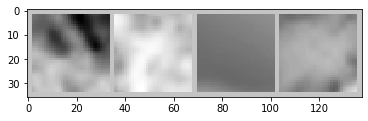

In [23]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/SR_with_FDPL_loss')
my_dataloader2 = data.DataLoader(my_training_dataset, batch_size=4, shuffle=True, drop_last=True)


        
# get some random training images
dataiter = iter(my_dataloader2)
images, labels = dataiter.next()


images_2 = torch.zeros((4,3,32,32))


images_2[:,0,:,:] = images
images_2[:,1,:,:] = images
images_2[:,2,:,:] = images


# create grid of images
img_grid = torchvision.utils.make_grid(images_2, nrow=4)
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_training_images', img_grid)

writer.add_graph(SR_model, images.unsqueeze(1).float().to(device))
writer.close()


In [24]:
for epoch in range(9375-global_epoch):  # loop over the dataset multiple times
    print("epoch: ", global_epoch + 1)
    running_loss = 0.0
    for batch_i, data in enumerate(my_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, ground_truth = data
        inputs = inputs.float().to(device)
        ground_truth = ground_truth.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = SR_model(inputs.unsqueeze(1))
        
        

        loss = criterion(outputs.squeeze(), ground_truth.float())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (global_epoch + 1, batch_i + 1, running_loss / 100))
            writer.add_scalar('training loss', running_loss / 100,
                              global_epoch * len(my_dataloader) + batch_i)
            running_loss = 0.0
    
    #end of epoch metric calculations         
    global_epoch += 1
    with torch.no_grad():

        val_loss = 0
        batch_i = 0
        for batch_i, data in enumerate(my_val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, ground_truth = data
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = SR_model(inputs.float().unsqueeze(1))

            

            val_loss += criterion(outputs.squeeze(), ground_truth.float())
        
        #get average loss per batch, to match how loss is reported in training
        val_loss = val_loss/(len(my_val_dataloader))
        writer.add_scalar('validation loss', val_loss, global_epoch)
        
        print('epoch %d validation loss: %f'%(global_epoch, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            print("New lowest loss found. Saving checkpoint.")
            torch.save({'epoch': global_epoch,
                        'model_state_dict': SR_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val loss': val_loss
                        }, './checkpoint_SR_with_FDPL_loss.pt')
        # eval over a unrelated dataset to track psnr

        mean_blur_psnr, mean_sr_psnr = evaluate_model(path='./data/raw/test_sets/Set5/', 
                                                      model=SR_model, 
                                                      pixel_mean=train_pixel_mean, 
                                                      pixel_std=train_pixel_std)
        writer.add_scalars('Test5 PSNR (dB)', {'bicubic_psnr':mean_blur_psnr,
                                               'srcnn_psnr':mean_sr_psnr}, global_epoch)
        print("test5: bicubic = %f; srcnn = %f"%(mean_blur_psnr, mean_sr_psnr))
            
            
print('Finished Training')



epoch:  4854
[4854,   100] loss: 375.447
[4854,   200] loss: 373.625
[4854,   300] loss: 374.370
[4854,   400] loss: 369.758
[4854,   500] loss: 369.315
[4854,   600] loss: 370.129
[4854,   700] loss: 366.100
[4854,   800] loss: 365.459
[4854,   900] loss: 367.924
[4854,  1000] loss: 370.235
[4854,  1100] loss: 374.528
[4854,  1200] loss: 376.318
[4854,  1300] loss: 368.693
[4854,  1400] loss: 368.893
[4854,  1500] loss: 375.367
[4854,  1600] loss: 371.158
epoch 4854 validation loss: 407.559198
test5: bicubic = 28.016224; srcnn = 30.780519
epoch:  4855
[4855,   100] loss: 370.580
[4855,   200] loss: 361.167
[4855,   300] loss: 373.618
[4855,   400] loss: 370.746
[4855,   500] loss: 380.716
[4855,   600] loss: 375.278
[4855,   700] loss: 372.814
[4855,   800] loss: 366.953
[4855,   900] loss: 373.592
[4855,  1000] loss: 364.494
[4855,  1100] loss: 369.058
[4855,  1200] loss: 378.488
[4855,  1300] loss: 375.442
[4855,  1400] loss: 370.657
[4855,  1500] loss: 363.921
[4855,  1600] loss: 3

[4869,   100] loss: 370.703
[4869,   200] loss: 365.551
[4869,   300] loss: 371.182
[4869,   400] loss: 372.333
[4869,   500] loss: 375.656
[4869,   600] loss: 373.504
[4869,   700] loss: 371.419
[4869,   800] loss: 370.040
[4869,   900] loss: 377.985
[4869,  1000] loss: 368.596
[4869,  1100] loss: 368.474
[4869,  1200] loss: 381.083
[4869,  1300] loss: 360.566
[4869,  1400] loss: 360.396
[4869,  1500] loss: 376.620
[4869,  1600] loss: 375.500
epoch 4869 validation loss: 406.668417
test5: bicubic = 28.016224; srcnn = 30.940882
epoch:  4870
[4870,   100] loss: 369.054
[4870,   200] loss: 367.871
[4870,   300] loss: 368.983
[4870,   400] loss: 377.758
[4870,   500] loss: 376.622
[4870,   600] loss: 369.066
[4870,   700] loss: 372.095
[4870,   800] loss: 366.761
[4870,   900] loss: 374.448
[4870,  1000] loss: 371.640
[4870,  1100] loss: 376.109
[4870,  1200] loss: 378.975
[4870,  1300] loss: 367.918
[4870,  1400] loss: 364.314
[4870,  1500] loss: 371.856
[4870,  1600] loss: 364.565
epoch 

[4884,   200] loss: 379.379
[4884,   300] loss: 377.006
[4884,   400] loss: 375.298
[4884,   500] loss: 370.208
[4884,   600] loss: 369.716
[4884,   700] loss: 365.327
[4884,   800] loss: 373.481
[4884,   900] loss: 367.758
[4884,  1000] loss: 372.905
[4884,  1100] loss: 377.098
[4884,  1200] loss: 358.035
[4884,  1300] loss: 375.852
[4884,  1400] loss: 368.125
[4884,  1500] loss: 373.512
[4884,  1600] loss: 367.080
epoch 4884 validation loss: 406.386041
test5: bicubic = 28.016224; srcnn = 30.851836
epoch:  4885
[4885,   100] loss: 373.825
[4885,   200] loss: 370.603
[4885,   300] loss: 369.180
[4885,   400] loss: 385.241
[4885,   500] loss: 363.878
[4885,   600] loss: 363.542
[4885,   700] loss: 371.782
[4885,   800] loss: 376.032
[4885,   900] loss: 375.144
[4885,  1000] loss: 370.023
[4885,  1100] loss: 369.625
[4885,  1200] loss: 365.421
[4885,  1300] loss: 377.881
[4885,  1400] loss: 365.268
[4885,  1500] loss: 373.617
[4885,  1600] loss: 363.495
epoch 4885 validation loss: 408.84

[4900,  1100] loss: 363.872
[4900,  1200] loss: 368.625
[4900,  1300] loss: 374.424
[4900,  1400] loss: 374.577
[4900,  1500] loss: 378.664
[4900,  1600] loss: 370.312
epoch 4900 validation loss: 408.118141
test5: bicubic = 28.016224; srcnn = 30.576979
epoch:  4901
[4901,   100] loss: 362.587
[4901,   200] loss: 372.711
[4901,   300] loss: 376.218
[4901,   400] loss: 377.298
[4901,   500] loss: 369.936
[4901,   600] loss: 364.665
[4901,   700] loss: 370.292
[4901,   800] loss: 377.288
[4901,   900] loss: 374.862
[4901,  1000] loss: 375.842
[4901,  1100] loss: 374.248
[4901,  1200] loss: 376.423
[4901,  1300] loss: 370.345
[4901,  1400] loss: 361.820
[4901,  1500] loss: 371.461
[4901,  1600] loss: 364.635
epoch 4901 validation loss: 407.069434
test5: bicubic = 28.016224; srcnn = 30.811568
epoch:  4902
[4902,   100] loss: 377.109
[4902,   200] loss: 365.139
[4902,   300] loss: 382.062
[4902,   400] loss: 365.592
[4902,   500] loss: 364.349
[4902,   600] loss: 371.863
[4902,   700] loss: 

[4917,   200] loss: 376.950
[4917,   300] loss: 368.084
[4917,   400] loss: 372.573
[4917,   500] loss: 373.413
[4917,   600] loss: 369.150
[4917,   700] loss: 376.527
[4917,   800] loss: 370.533
[4917,   900] loss: 371.346
[4917,  1000] loss: 366.657
[4917,  1100] loss: 367.728
[4917,  1200] loss: 361.620
[4917,  1300] loss: 375.082
[4917,  1400] loss: 370.643
[4917,  1500] loss: 372.311
[4917,  1600] loss: 370.676
epoch 4917 validation loss: 407.426946
test5: bicubic = 28.016224; srcnn = 30.741060
epoch:  4918
[4918,   100] loss: 372.658
[4918,   200] loss: 372.526
[4918,   300] loss: 366.720
[4918,   400] loss: 370.408
[4918,   500] loss: 371.828
[4918,   600] loss: 372.525
[4918,   700] loss: 367.649
[4918,   800] loss: 375.088
[4918,   900] loss: 378.577
[4918,  1000] loss: 367.122
[4918,  1100] loss: 372.698
[4918,  1200] loss: 368.493
[4918,  1300] loss: 373.653
[4918,  1400] loss: 373.109
[4918,  1500] loss: 369.627
[4918,  1600] loss: 369.085
epoch 4918 validation loss: 408.10

[4932,   300] loss: 368.664
[4932,   400] loss: 368.111
[4932,   500] loss: 368.438
[4932,   600] loss: 368.579
[4932,   700] loss: 371.769
[4932,   800] loss: 368.790
[4932,   900] loss: 367.738
[4932,  1000] loss: 369.821
[4932,  1100] loss: 372.099
[4932,  1200] loss: 371.527
[4932,  1300] loss: 370.917
[4932,  1400] loss: 367.613
[4932,  1500] loss: 372.273
[4932,  1600] loss: 375.672
epoch 4932 validation loss: 407.262098
test5: bicubic = 28.016224; srcnn = 30.792323
epoch:  4933
[4933,   100] loss: 368.009
[4933,   200] loss: 373.940
[4933,   300] loss: 379.349
[4933,   400] loss: 368.008
[4933,   500] loss: 372.472
[4933,   600] loss: 366.469
[4933,   700] loss: 370.976
[4933,   800] loss: 366.544
[4933,   900] loss: 366.860
[4933,  1000] loss: 377.234
[4933,  1100] loss: 372.611
[4933,  1200] loss: 377.779
[4933,  1300] loss: 367.961
[4933,  1400] loss: 362.939
[4933,  1500] loss: 370.633
[4933,  1600] loss: 369.434
epoch 4933 validation loss: 409.085817
test5: bicubic = 28.016

[4948,  1600] loss: 373.554
epoch 4948 validation loss: 407.838289
test5: bicubic = 28.016224; srcnn = 30.727549
epoch:  4949
[4949,   100] loss: 368.803
[4949,   200] loss: 363.580
[4949,   300] loss: 370.405
[4949,   400] loss: 364.121
[4949,   500] loss: 370.521
[4949,   600] loss: 373.795
[4949,   700] loss: 375.960
[4949,   800] loss: 373.373
[4949,   900] loss: 368.178
[4949,  1000] loss: 371.734
[4949,  1100] loss: 364.180
[4949,  1200] loss: 385.319
[4949,  1300] loss: 369.830
[4949,  1400] loss: 369.701
[4949,  1500] loss: 366.664
[4949,  1600] loss: 373.605
epoch 4949 validation loss: 406.695032
test5: bicubic = 28.016224; srcnn = 30.633933
epoch:  4950
[4950,   100] loss: 375.116
[4950,   200] loss: 370.700
[4950,   300] loss: 373.394
[4950,   400] loss: 373.078
[4950,   500] loss: 369.542
[4950,   600] loss: 371.208
[4950,   700] loss: 374.391
[4950,   800] loss: 363.926
[4950,   900] loss: 363.230
[4950,  1000] loss: 379.638
[4950,  1100] loss: 372.142
[4950,  1200] loss: 

epoch 4963 validation loss: 408.687779
test5: bicubic = 28.016224; srcnn = 30.924993
epoch:  4964
[4964,   100] loss: 374.458
[4964,   200] loss: 366.441
[4964,   300] loss: 371.996
[4964,   400] loss: 372.606
[4964,   500] loss: 374.178
[4964,   600] loss: 378.379
[4964,   700] loss: 370.045
[4964,   800] loss: 368.539
[4964,   900] loss: 369.114
[4964,  1000] loss: 372.483
[4964,  1100] loss: 372.120
[4964,  1200] loss: 366.081
[4964,  1300] loss: 370.590
[4964,  1400] loss: 368.190
[4964,  1500] loss: 373.740
[4964,  1600] loss: 365.292
epoch 4964 validation loss: 407.832852
test5: bicubic = 28.016224; srcnn = 30.663681
epoch:  4965
[4965,   100] loss: 364.500
[4965,   200] loss: 363.331
[4965,   300] loss: 372.561
[4965,   400] loss: 367.855
[4965,   500] loss: 367.319
[4965,   600] loss: 376.970
[4965,   700] loss: 375.928
[4965,   800] loss: 380.066
[4965,   900] loss: 376.937
[4965,  1000] loss: 370.222
[4965,  1100] loss: 371.834
[4965,  1200] loss: 363.184
[4965,  1300] loss: 

[4979,   100] loss: 372.733
[4979,   200] loss: 380.136
[4979,   300] loss: 371.821
[4979,   400] loss: 372.039
[4979,   500] loss: 372.093
[4979,   600] loss: 372.834
[4979,   700] loss: 368.674
[4979,   800] loss: 365.991
[4979,   900] loss: 372.668
[4979,  1000] loss: 374.121
[4979,  1100] loss: 364.779
[4979,  1200] loss: 376.998
[4979,  1300] loss: 367.224
[4979,  1400] loss: 361.759
[4979,  1500] loss: 365.508
[4979,  1600] loss: 374.385
epoch 4979 validation loss: 407.310566
test5: bicubic = 28.016224; srcnn = 30.863015
epoch:  4980
[4980,   100] loss: 368.348
[4980,   200] loss: 377.118
[4980,   300] loss: 368.456
[4980,   400] loss: 370.873
[4980,   500] loss: 376.339
[4980,   600] loss: 373.811
[4980,   700] loss: 369.278
[4980,   800] loss: 369.535
[4980,   900] loss: 381.904
[4980,  1000] loss: 366.129
[4980,  1100] loss: 369.650
[4980,  1200] loss: 365.794
[4980,  1300] loss: 360.452
[4980,  1400] loss: 364.615
[4980,  1500] loss: 374.588
[4980,  1600] loss: 377.723
epoch 

[4994,   200] loss: 376.166
[4994,   300] loss: 374.413
[4994,   400] loss: 369.836
[4994,   500] loss: 372.533
[4994,   600] loss: 364.494
[4994,   700] loss: 375.166
[4994,   800] loss: 369.528
[4994,   900] loss: 375.542
[4994,  1000] loss: 362.482
[4994,  1100] loss: 370.905
[4994,  1200] loss: 368.006
[4994,  1300] loss: 369.992
[4994,  1400] loss: 373.395
[4994,  1500] loss: 370.316
[4994,  1600] loss: 380.653
epoch 4994 validation loss: 408.435096
test5: bicubic = 28.016224; srcnn = 30.864333
epoch:  4995
[4995,   100] loss: 371.867
[4995,   200] loss: 374.353
[4995,   300] loss: 366.115
[4995,   400] loss: 369.776
[4995,   500] loss: 368.712
[4995,   600] loss: 381.180
[4995,   700] loss: 367.902
[4995,   800] loss: 369.598
[4995,   900] loss: 375.026
[4995,  1000] loss: 372.162
[4995,  1100] loss: 371.951
[4995,  1200] loss: 369.878
[4995,  1300] loss: 378.871
[4995,  1400] loss: 364.851
[4995,  1500] loss: 363.876
[4995,  1600] loss: 375.440
epoch 4995 validation loss: 406.76

[5010,  1400] loss: 371.933
[5010,  1500] loss: 371.218
[5010,  1600] loss: 374.838
epoch 5010 validation loss: 407.208212
test5: bicubic = 28.016224; srcnn = 30.861232
epoch:  5011
[5011,   100] loss: 362.979
[5011,   200] loss: 367.291
[5011,   300] loss: 371.555
[5011,   400] loss: 369.430
[5011,   500] loss: 375.777
[5011,   600] loss: 371.586
[5011,   700] loss: 369.541
[5011,   800] loss: 370.317
[5011,   900] loss: 369.562
[5011,  1000] loss: 362.825
[5011,  1100] loss: 376.208
[5011,  1200] loss: 364.404
[5011,  1300] loss: 365.778
[5011,  1400] loss: 381.550
[5011,  1500] loss: 383.782
[5011,  1600] loss: 370.855
epoch 5011 validation loss: 407.593356
test5: bicubic = 28.016224; srcnn = 30.819280
epoch:  5012
[5012,   100] loss: 375.148
[5012,   200] loss: 372.776
[5012,   300] loss: 370.388
[5012,   400] loss: 367.908
[5012,   500] loss: 366.378
[5012,   600] loss: 382.952
[5012,   700] loss: 364.277
[5012,   800] loss: 370.002
[5012,   900] loss: 369.377
[5012,  1000] loss: 

[5025,  1500] loss: 370.045
[5025,  1600] loss: 370.620
epoch 5025 validation loss: 407.836425
test5: bicubic = 28.016224; srcnn = 30.439536
epoch:  5026
[5026,   100] loss: 361.686
[5026,   200] loss: 381.134
[5026,   300] loss: 368.241
[5026,   400] loss: 375.991
[5026,   500] loss: 364.438
[5026,   600] loss: 378.167
[5026,   700] loss: 360.572
[5026,   800] loss: 366.973
[5026,   900] loss: 380.352
[5026,  1000] loss: 370.684
[5026,  1100] loss: 369.320
[5026,  1200] loss: 373.661
[5026,  1300] loss: 380.558
[5026,  1400] loss: 376.533
[5026,  1500] loss: 367.096
[5026,  1600] loss: 362.502
epoch 5026 validation loss: 406.906074
test5: bicubic = 28.016224; srcnn = 30.716566
epoch:  5027
[5027,   100] loss: 364.256
[5027,   200] loss: 369.341
[5027,   300] loss: 368.740
[5027,   400] loss: 377.761
[5027,   500] loss: 372.879
[5027,   600] loss: 369.595
[5027,   700] loss: 365.937
[5027,   800] loss: 367.119
[5027,   900] loss: 382.256
[5027,  1000] loss: 378.410
[5027,  1100] loss: 

[5040,  1600] loss: 378.278
epoch 5040 validation loss: 407.028649
test5: bicubic = 28.016224; srcnn = 30.823386
epoch:  5041
[5041,   100] loss: 375.035
[5041,   200] loss: 363.163
[5041,   300] loss: 376.054
[5041,   400] loss: 372.340
[5041,   500] loss: 375.420
[5041,   600] loss: 379.055
[5041,   700] loss: 367.528
[5041,   800] loss: 372.316
[5041,   900] loss: 371.875
[5041,  1000] loss: 371.438
[5041,  1100] loss: 364.184
[5041,  1200] loss: 361.476
[5041,  1300] loss: 368.023
[5041,  1400] loss: 367.465
[5041,  1500] loss: 375.619
[5041,  1600] loss: 371.854
epoch 5041 validation loss: 408.577050
test5: bicubic = 28.016224; srcnn = 30.485866
epoch:  5042
[5042,   100] loss: 380.706
[5042,   200] loss: 375.638
[5042,   300] loss: 372.309
[5042,   400] loss: 366.371
[5042,   500] loss: 372.365
[5042,   600] loss: 377.387
[5042,   700] loss: 365.646
[5042,   800] loss: 372.497
[5042,   900] loss: 371.435
[5042,  1000] loss: 365.375
[5042,  1100] loss: 373.659
[5042,  1200] loss: 

epoch 5055 validation loss: 407.801565
test5: bicubic = 28.016224; srcnn = 30.513383
epoch:  5056
[5056,   100] loss: 370.516
[5056,   200] loss: 373.596
[5056,   300] loss: 368.380
[5056,   400] loss: 370.995
[5056,   500] loss: 375.263
[5056,   600] loss: 375.724
[5056,   700] loss: 370.719
[5056,   800] loss: 374.203
[5056,   900] loss: 386.904
[5056,  1000] loss: 380.720
[5056,  1100] loss: 362.763
[5056,  1200] loss: 369.485
[5056,  1300] loss: 361.739
[5056,  1400] loss: 367.974
[5056,  1500] loss: 365.002
[5056,  1600] loss: 364.420
epoch 5056 validation loss: 406.901248
test5: bicubic = 28.016224; srcnn = 30.825656
epoch:  5057
[5057,   100] loss: 371.304
[5057,   200] loss: 361.941
[5057,   300] loss: 369.089
[5057,   400] loss: 376.038
[5057,   500] loss: 371.986
[5057,   600] loss: 375.652
[5057,   700] loss: 376.676
[5057,   800] loss: 371.092
[5057,   900] loss: 370.940
[5057,  1000] loss: 369.113
[5057,  1100] loss: 371.853
[5057,  1200] loss: 371.837
[5057,  1300] loss: 

[5071,   100] loss: 368.270
[5071,   200] loss: 376.522
[5071,   300] loss: 375.611
[5071,   400] loss: 374.642
[5071,   500] loss: 378.380
[5071,   600] loss: 364.055
[5071,   700] loss: 378.763
[5071,   800] loss: 366.567
[5071,   900] loss: 374.108
[5071,  1000] loss: 362.563
[5071,  1100] loss: 368.754
[5071,  1200] loss: 369.817
[5071,  1300] loss: 374.996
[5071,  1400] loss: 374.050
[5071,  1500] loss: 365.126
[5071,  1600] loss: 369.106
epoch 5071 validation loss: 406.462593
test5: bicubic = 28.016224; srcnn = 30.819326
epoch:  5072
[5072,   100] loss: 370.433
[5072,   200] loss: 372.177
[5072,   300] loss: 370.714
[5072,   400] loss: 381.678
[5072,   500] loss: 359.318
[5072,   600] loss: 370.500
[5072,   700] loss: 373.377
[5072,   800] loss: 363.382
[5072,   900] loss: 370.316
[5072,  1000] loss: 379.175
[5072,  1100] loss: 371.998
[5072,  1200] loss: 372.370
[5072,  1300] loss: 375.981
[5072,  1400] loss: 362.681
[5072,  1500] loss: 375.001
[5072,  1600] loss: 373.167
epoch 

[5086,   800] loss: 369.353
[5086,   900] loss: 372.293
[5086,  1000] loss: 374.969
[5086,  1100] loss: 369.095
[5086,  1200] loss: 375.848
[5086,  1300] loss: 369.009
[5086,  1400] loss: 367.346
[5086,  1500] loss: 371.202
[5086,  1600] loss: 368.000
epoch 5086 validation loss: 408.164015
test5: bicubic = 28.016224; srcnn = 30.362680
epoch:  5087
[5087,   100] loss: 373.758
[5087,   200] loss: 362.447
[5087,   300] loss: 366.759
[5087,   400] loss: 370.830
[5087,   500] loss: 371.206
[5087,   600] loss: 371.220
[5087,   700] loss: 374.335
[5087,   800] loss: 368.799
[5087,   900] loss: 365.296
[5087,  1000] loss: 376.462
[5087,  1100] loss: 366.769
[5087,  1200] loss: 370.615
[5087,  1300] loss: 376.641
[5087,  1400] loss: 365.715
[5087,  1500] loss: 371.020
[5087,  1600] loss: 373.957
epoch 5087 validation loss: 406.033504
test5: bicubic = 28.016224; srcnn = 30.967199
epoch:  5088
[5088,   100] loss: 375.159
[5088,   200] loss: 371.392
[5088,   300] loss: 368.116
[5088,   400] loss: 

[5101,   900] loss: 369.501
[5101,  1000] loss: 368.823
[5101,  1100] loss: 369.291
[5101,  1200] loss: 366.791
[5101,  1300] loss: 366.782
[5101,  1400] loss: 375.941
[5101,  1500] loss: 377.485
[5101,  1600] loss: 377.144
epoch 5101 validation loss: 407.069778
test5: bicubic = 28.016224; srcnn = 30.844333
epoch:  5102
[5102,   100] loss: 365.930
[5102,   200] loss: 364.931
[5102,   300] loss: 371.586
[5102,   400] loss: 372.981
[5102,   500] loss: 377.748
[5102,   600] loss: 374.204
[5102,   700] loss: 374.045
[5102,   800] loss: 374.548
[5102,   900] loss: 374.631
[5102,  1000] loss: 367.907
[5102,  1100] loss: 367.060
[5102,  1200] loss: 361.593
[5102,  1300] loss: 373.168
[5102,  1400] loss: 373.072
[5102,  1500] loss: 368.003
[5102,  1600] loss: 374.518
[5112,   700] loss: 368.602
[5112,   800] loss: 371.670
[5112,   900] loss: 375.782
[5112,  1000] loss: 368.661
[5112,  1100] loss: 376.208
[5112,  1200] loss: 373.904
[5112,  1300] loss: 369.921
[5112,  1400] loss: 381.061
[5112,

[5126,   100] loss: 372.974
[5126,   200] loss: 376.010
[5126,   300] loss: 369.694
[5126,   400] loss: 362.014
[5126,   500] loss: 365.377
[5126,   600] loss: 361.610
[5126,   700] loss: 375.838
[5126,   800] loss: 369.482
[5126,   900] loss: 370.468
[5126,  1000] loss: 378.799
[5126,  1100] loss: 365.528
[5126,  1200] loss: 377.551
[5126,  1300] loss: 371.963
[5126,  1400] loss: 379.650
[5126,  1500] loss: 368.841
[5126,  1600] loss: 374.796
epoch 5126 validation loss: 406.494105
test5: bicubic = 28.016224; srcnn = 30.833040
epoch:  5127
[5127,   100] loss: 371.617
[5127,   200] loss: 372.092
[5127,   300] loss: 376.566
[5127,   400] loss: 368.338
[5127,   500] loss: 377.070
[5127,   600] loss: 370.382
[5127,   700] loss: 368.856
[5127,   800] loss: 376.709
[5127,   900] loss: 373.794
[5127,  1000] loss: 374.787
[5127,  1100] loss: 365.444
[5127,  1200] loss: 371.114
[5127,  1300] loss: 361.871
[5127,  1400] loss: 363.091
[5127,  1500] loss: 365.552
[5127,  1600] loss: 376.280
epoch 

[5141,   200] loss: 364.694
[5141,   300] loss: 362.726
[5141,   400] loss: 373.234
[5141,   500] loss: 375.174
[5141,   600] loss: 372.825
[5141,   700] loss: 370.710
[5141,   800] loss: 376.859
[5141,   900] loss: 369.167
[5141,  1000] loss: 379.510
[5141,  1100] loss: 361.894
[5141,  1200] loss: 367.732
[5141,  1300] loss: 371.356
[5141,  1400] loss: 377.918
[5141,  1500] loss: 366.148
[5141,  1600] loss: 368.241
epoch 5141 validation loss: 407.493953
test5: bicubic = 28.016224; srcnn = 30.981942
epoch:  5142
[5142,   100] loss: 368.468
[5142,   200] loss: 370.413
[5142,   300] loss: 370.229
[5142,   400] loss: 369.082
[5142,   500] loss: 374.453
[5142,   600] loss: 373.601
[5142,   700] loss: 375.488
[5142,   800] loss: 369.942
[5142,   900] loss: 377.178
[5142,  1000] loss: 375.199
[5142,  1100] loss: 370.258
[5142,  1200] loss: 363.576
[5142,  1300] loss: 370.117
[5142,  1400] loss: 375.558
[5142,  1500] loss: 370.338
[5142,  1600] loss: 366.277
epoch 5142 validation loss: 407.42

[5156,   300] loss: 374.549
[5156,   400] loss: 375.857
[5156,   500] loss: 367.255
[5156,   600] loss: 376.139
[5156,   700] loss: 365.005
[5156,   800] loss: 366.649
[5156,   900] loss: 373.695
[5156,  1000] loss: 367.523
[5156,  1100] loss: 363.492
[5156,  1200] loss: 383.035
[5156,  1300] loss: 372.743
[5156,  1400] loss: 370.937
[5156,  1500] loss: 373.457
[5156,  1600] loss: 366.772
epoch 5156 validation loss: 406.341697
test5: bicubic = 28.016224; srcnn = 30.884547
epoch:  5157
[5157,   100] loss: 365.227
[5157,   200] loss: 365.431
[5157,   300] loss: 381.572
[5157,   400] loss: 371.627
[5157,   500] loss: 375.712
[5157,   600] loss: 366.617
[5157,   700] loss: 371.835
[5157,   800] loss: 370.253
[5157,   900] loss: 365.213
[5157,  1000] loss: 374.708
[5157,  1100] loss: 373.005
[5157,  1200] loss: 364.037
[5157,  1300] loss: 375.036
[5157,  1400] loss: 373.701
[5157,  1500] loss: 372.390
[5157,  1600] loss: 368.446
epoch 5157 validation loss: 407.250989
test5: bicubic = 28.016

[5172,  1500] loss: 364.683
[5172,  1600] loss: 376.792
epoch 5172 validation loss: 407.395270
test5: bicubic = 28.016224; srcnn = 30.867897
epoch:  5173
[5173,   100] loss: 365.133
[5173,   200] loss: 376.024
[5173,   300] loss: 371.776
[5173,   400] loss: 359.449
[5173,   500] loss: 369.935
[5173,   600] loss: 372.816
[5173,   700] loss: 370.791
[5173,   800] loss: 366.383
[5173,   900] loss: 369.221
[5173,  1000] loss: 373.138
[5173,  1100] loss: 379.104
[5173,  1200] loss: 373.511
[5173,  1300] loss: 371.523
[5173,  1400] loss: 369.088
[5173,  1500] loss: 374.531
[5173,  1600] loss: 373.342
epoch 5173 validation loss: 408.807143
test5: bicubic = 28.016224; srcnn = 30.613319
epoch:  5174
[5174,   100] loss: 373.305
[5174,   200] loss: 362.669
[5174,   300] loss: 368.543
[5174,   400] loss: 371.456
[5174,   500] loss: 370.989
[5174,   600] loss: 376.937
[5174,   700] loss: 371.908
[5174,   800] loss: 364.219
[5174,   900] loss: 370.798
[5174,  1000] loss: 373.966
[5174,  1100] loss: 

[5187,  1600] loss: 367.977
epoch 5187 validation loss: 407.793431
test5: bicubic = 28.016224; srcnn = 31.002089
epoch:  5188
[5188,   100] loss: 376.075
[5188,   200] loss: 380.649
[5188,   300] loss: 375.839
[5188,   400] loss: 375.531
[5188,   500] loss: 369.455
[5188,   600] loss: 365.231
[5188,   700] loss: 365.652
[5188,   800] loss: 369.735
[5188,   900] loss: 364.903
[5188,  1000] loss: 370.367
[5188,  1100] loss: 365.896
[5188,  1200] loss: 367.715
[5188,  1300] loss: 372.313
[5188,  1400] loss: 371.144
[5188,  1500] loss: 371.202
[5188,  1600] loss: 371.881
epoch 5188 validation loss: 406.637479
test5: bicubic = 28.016224; srcnn = 30.915502
epoch:  5189
[5189,   100] loss: 377.248
[5189,   200] loss: 364.999
[5189,   300] loss: 370.651
[5189,   400] loss: 376.697
[5189,   500] loss: 377.306
[5189,   600] loss: 371.542
[5189,   700] loss: 367.717
[5189,   800] loss: 376.761
[5189,   900] loss: 369.991
[5189,  1000] loss: 368.987
[5189,  1100] loss: 367.722
[5189,  1200] loss: 

epoch 5202 validation loss: 407.649226
test5: bicubic = 28.016224; srcnn = 30.778348
epoch:  5203
[5203,   100] loss: 370.734
[5203,   200] loss: 370.324
[5203,   300] loss: 379.741
[5203,   400] loss: 362.465
[5203,   500] loss: 367.092
[5203,   600] loss: 370.629
[5203,   700] loss: 376.951
[5203,   800] loss: 372.456
[5203,   900] loss: 374.978
[5203,  1000] loss: 374.558
[5203,  1100] loss: 376.868
[5203,  1200] loss: 370.733
[5203,  1300] loss: 369.636
[5203,  1400] loss: 370.283
[5203,  1500] loss: 362.966
[5203,  1600] loss: 366.967
epoch 5203 validation loss: 406.575066
test5: bicubic = 28.016224; srcnn = 30.665348
epoch:  5204
[5204,   100] loss: 360.358
[5204,   200] loss: 366.643
[5204,   300] loss: 367.417
[5204,   400] loss: 367.265
[5204,   500] loss: 372.094
[5204,   600] loss: 370.258
[5204,   700] loss: 370.140
[5204,   800] loss: 368.994
[5204,   900] loss: 367.247
[5204,  1000] loss: 372.247
[5204,  1100] loss: 368.496
[5204,  1200] loss: 376.811
[5204,  1300] loss: 

[5218,   100] loss: 377.950
[5218,   200] loss: 373.334
[5218,   300] loss: 369.541
[5218,   400] loss: 370.945
[5218,   500] loss: 372.079
[5218,   600] loss: 369.660
[5218,   700] loss: 368.026
[5218,   800] loss: 375.569
[5218,   900] loss: 366.966
[5218,  1000] loss: 366.911
[5218,  1100] loss: 370.677
[5218,  1200] loss: 367.447
[5218,  1300] loss: 374.786
[5218,  1400] loss: 367.923
[5218,  1500] loss: 367.936
[5218,  1600] loss: 373.998
epoch 5218 validation loss: 408.053951
test5: bicubic = 28.016224; srcnn = 30.616128
epoch:  5219
[5219,   100] loss: 369.114
[5219,   200] loss: 367.457
[5219,   300] loss: 374.612
[5219,   400] loss: 364.556
[5219,   500] loss: 372.995
[5219,   600] loss: 374.835
[5219,   700] loss: 368.971
[5219,   800] loss: 376.002
[5219,   900] loss: 373.566
[5219,  1000] loss: 381.794
[5219,  1100] loss: 372.872
[5219,  1200] loss: 367.170
[5219,  1300] loss: 368.643
[5219,  1400] loss: 372.848
[5219,  1500] loss: 366.901
[5219,  1600] loss: 359.001
epoch 

[5233,   200] loss: 373.546
[5233,   300] loss: 380.532
[5233,   400] loss: 370.874
[5233,   500] loss: 365.602
[5233,   600] loss: 371.210
[5233,   700] loss: 364.273
[5233,   800] loss: 370.198
[5233,   900] loss: 371.267
[5233,  1000] loss: 375.910
[5233,  1100] loss: 363.819
[5233,  1200] loss: 374.894
[5233,  1300] loss: 367.233
[5233,  1400] loss: 375.566
[5233,  1500] loss: 373.824
[5233,  1600] loss: 361.442
epoch 5233 validation loss: 406.614886
test5: bicubic = 28.016224; srcnn = 30.939058
epoch:  5234
[5234,   100] loss: 376.030
[5234,   200] loss: 361.658
[5234,   300] loss: 365.308
[5234,   400] loss: 367.010
[5234,   500] loss: 368.741
[5234,   600] loss: 366.360
[5234,   700] loss: 372.212
[5234,   800] loss: 379.859
[5234,   900] loss: 373.411
[5234,  1000] loss: 379.210
[5234,  1100] loss: 371.508
[5234,  1200] loss: 373.514
[5234,  1300] loss: 366.324
[5234,  1400] loss: 379.823
[5234,  1500] loss: 367.679
[5234,  1600] loss: 366.506
epoch 5234 validation loss: 407.10

[5248,   300] loss: 378.027
[5248,   400] loss: 369.451
[5248,   500] loss: 362.735
[5248,   600] loss: 368.325
[5248,   700] loss: 370.773
[5248,   800] loss: 365.979
[5248,   900] loss: 370.806
[5248,  1000] loss: 370.719
[5248,  1100] loss: 367.759
[5248,  1200] loss: 370.019
[5248,  1300] loss: 373.195
[5248,  1400] loss: 368.347
[5248,  1500] loss: 370.675
[5248,  1600] loss: 374.764
epoch 5248 validation loss: 406.871726
test5: bicubic = 28.016224; srcnn = 30.939440
epoch:  5249
[5249,   100] loss: 367.537
[5249,   200] loss: 382.553
[5249,   300] loss: 366.084
[5249,   400] loss: 369.043
[5249,   500] loss: 375.397
[5249,   600] loss: 372.355
[5249,   700] loss: 367.861
[5249,   800] loss: 371.340
[5249,   900] loss: 371.480
[5249,  1000] loss: 369.496
[5249,  1100] loss: 366.000
[5249,  1200] loss: 366.238
[5249,  1300] loss: 376.421
[5249,  1400] loss: 363.185
[5249,  1500] loss: 369.220
[5249,  1600] loss: 376.871
epoch 5249 validation loss: 407.129145
test5: bicubic = 28.016

[5263,   400] loss: 368.173
[5263,   500] loss: 365.288
[5263,   600] loss: 369.347
[5263,   700] loss: 372.249
[5263,   800] loss: 373.560
[5263,   900] loss: 381.935
[5263,  1000] loss: 380.713
[5263,  1100] loss: 367.587
[5263,  1200] loss: 368.334
[5263,  1300] loss: 366.738
[5263,  1400] loss: 371.030
[5263,  1500] loss: 373.255
[5263,  1600] loss: 374.106
epoch 5263 validation loss: 407.724306
test5: bicubic = 28.016224; srcnn = 30.643872
epoch:  5264
[5264,   100] loss: 372.381
[5264,   200] loss: 371.930
[5264,   300] loss: 366.025
[5264,   400] loss: 363.380
[5264,   500] loss: 372.031
[5264,   600] loss: 368.316
[5264,   700] loss: 375.530
[5264,   800] loss: 371.696
[5264,   900] loss: 376.436
[5264,  1000] loss: 374.140
[5264,  1100] loss: 370.099
[5264,  1200] loss: 373.849
[5264,  1300] loss: 365.575
[5264,  1400] loss: 373.668
[5264,  1500] loss: 371.340
[5264,  1600] loss: 366.672
epoch 5264 validation loss: 408.559565
test5: bicubic = 28.016224; srcnn = 30.029601
epoch

[5278,   500] loss: 367.773
[5278,   600] loss: 380.037
[5278,   700] loss: 374.614
[5278,   800] loss: 374.262
[5278,   900] loss: 371.869
[5278,  1000] loss: 373.258
[5278,  1100] loss: 364.861
[5278,  1200] loss: 371.456
[5278,  1300] loss: 371.427
[5278,  1400] loss: 369.393
[5278,  1500] loss: 375.926
[5278,  1600] loss: 376.057
epoch 5278 validation loss: 407.515956
test5: bicubic = 28.016224; srcnn = 30.505546
epoch:  5279
[5279,   100] loss: 369.443
[5279,   200] loss: 371.867
[5279,   300] loss: 369.055
[5279,   400] loss: 366.882
[5279,   500] loss: 363.454
[5279,   600] loss: 372.897
[5279,   700] loss: 367.583
[5279,   800] loss: 372.656
[5279,   900] loss: 366.940
[5279,  1000] loss: 368.542
[5279,  1100] loss: 373.178
[5279,  1200] loss: 374.547
[5279,  1300] loss: 373.423
[5279,  1400] loss: 375.431
[5279,  1500] loss: 369.207
[5279,  1600] loss: 381.020
epoch 5279 validation loss: 408.073018
test5: bicubic = 28.016224; srcnn = 30.781240
epoch:  5280
[5280,   100] loss: 

[5293,   600] loss: 365.625
[5293,   700] loss: 379.006
[5293,   800] loss: 372.716
[5293,   900] loss: 362.078
[5293,  1000] loss: 370.333
[5293,  1100] loss: 379.150
[5293,  1200] loss: 367.298
[5293,  1300] loss: 372.333
[5293,  1400] loss: 372.767
[5293,  1500] loss: 379.351
[5293,  1600] loss: 362.299
epoch 5293 validation loss: 407.561639
test5: bicubic = 28.016224; srcnn = 30.153423
epoch:  5294
[5294,   100] loss: 366.398
[5294,   200] loss: 379.430
[5294,   300] loss: 367.403
[5294,   400] loss: 369.683
[5294,   500] loss: 377.325
[5294,   600] loss: 366.877
[5294,   700] loss: 372.897
[5294,   800] loss: 377.530
[5294,   900] loss: 374.284
[5294,  1000] loss: 367.821
[5294,  1100] loss: 380.409
[5294,  1200] loss: 372.337
[5294,  1300] loss: 367.292
[5294,  1400] loss: 365.280
[5294,  1500] loss: 369.412
[5294,  1600] loss: 363.435
epoch 5294 validation loss: 407.913636
test5: bicubic = 28.016224; srcnn = 30.244279
epoch:  5295
[5295,   100] loss: 375.802
[5295,   200] loss: 

[5308,   700] loss: 369.295
[5308,   800] loss: 374.374
[5308,   900] loss: 368.530
[5308,  1000] loss: 375.276
[5308,  1100] loss: 379.852
[5308,  1200] loss: 370.432
[5308,  1300] loss: 377.839
[5308,  1400] loss: 366.010
[5308,  1500] loss: 366.871
[5308,  1600] loss: 370.529
epoch 5308 validation loss: 407.174062
test5: bicubic = 28.016224; srcnn = 30.891725
epoch:  5309
[5309,   100] loss: 370.302
[5309,   200] loss: 365.572
[5309,   300] loss: 374.144
[5309,   400] loss: 376.465
[5309,   500] loss: 372.952
[5309,   600] loss: 362.790
[5309,   700] loss: 374.352
[5309,   800] loss: 373.457
[5309,   900] loss: 368.924
[5309,  1000] loss: 364.766
[5309,  1100] loss: 368.258
[5309,  1200] loss: 377.032
[5309,  1300] loss: 369.398
[5309,  1400] loss: 372.489
[5309,  1500] loss: 371.111
[5309,  1600] loss: 375.303
epoch 5309 validation loss: 407.048231
test5: bicubic = 28.016224; srcnn = 30.722753
epoch:  5310
[5310,   100] loss: 369.688
[5310,   200] loss: 375.294
[5310,   300] loss: 

[5323,   800] loss: 374.540
[5323,   900] loss: 379.163
[5323,  1000] loss: 370.072
[5323,  1100] loss: 372.203
[5323,  1200] loss: 370.800
[5323,  1300] loss: 367.514
[5323,  1400] loss: 381.659
[5323,  1500] loss: 377.590
[5323,  1600] loss: 366.268
epoch 5323 validation loss: 406.815161
test5: bicubic = 28.016224; srcnn = 30.732991
epoch:  5324
[5324,   100] loss: 377.224
[5324,   200] loss: 367.545
[5324,   300] loss: 367.574
[5324,   400] loss: 371.602
[5324,   500] loss: 367.832
[5324,   600] loss: 369.290
[5324,   700] loss: 372.594
[5324,   800] loss: 375.673
[5324,   900] loss: 372.320
[5324,  1000] loss: 367.092
[5324,  1100] loss: 370.124
[5324,  1200] loss: 380.693
[5324,  1300] loss: 373.233
[5324,  1400] loss: 364.506
[5324,  1500] loss: 366.648
[5324,  1600] loss: 370.129
epoch 5324 validation loss: 407.409749
test5: bicubic = 28.016224; srcnn = 30.830833
epoch:  5325
[5325,   100] loss: 365.378
[5325,   200] loss: 373.769
[5325,   300] loss: 376.080
[5325,   400] loss: 

[5338,   900] loss: 373.401
[5338,  1000] loss: 371.695
[5338,  1100] loss: 365.000
[5338,  1200] loss: 368.895
[5338,  1300] loss: 369.952
[5338,  1400] loss: 369.979
[5338,  1500] loss: 380.701
[5338,  1600] loss: 383.227
epoch 5338 validation loss: 407.198193
test5: bicubic = 28.016224; srcnn = 30.910407
epoch:  5339
[5339,   100] loss: 362.887
[5339,   200] loss: 377.340
[5339,   300] loss: 376.024
[5339,   400] loss: 376.373
[5339,   500] loss: 366.429
[5339,   600] loss: 371.167
[5339,   700] loss: 368.765
[5339,   800] loss: 371.756
[5339,   900] loss: 373.252
[5339,  1000] loss: 378.538
[5339,  1100] loss: 369.974
[5339,  1200] loss: 366.993
[5339,  1300] loss: 368.675
[5339,  1400] loss: 373.943
[5339,  1500] loss: 362.982
[5339,  1600] loss: 372.929
epoch 5339 validation loss: 406.518501
test5: bicubic = 28.016224; srcnn = 30.838047
epoch:  5340
[5340,   100] loss: 370.723
[5340,   200] loss: 373.721
[5340,   300] loss: 365.767
[5340,   400] loss: 374.911
[5340,   500] loss: 

[5353,  1000] loss: 371.879
[5353,  1100] loss: 370.031
[5353,  1200] loss: 374.408
[5353,  1300] loss: 370.176
[5353,  1400] loss: 373.364
[5353,  1500] loss: 367.550
[5353,  1600] loss: 369.703
epoch 5353 validation loss: 407.887158
test5: bicubic = 28.016224; srcnn = 30.245586
epoch:  5354
[5354,   100] loss: 369.217
[5354,   200] loss: 377.104
[5354,   300] loss: 374.167
[5354,   400] loss: 371.356
[5354,   500] loss: 373.061
[5354,   600] loss: 367.474
[5354,   700] loss: 367.054
[5354,   800] loss: 370.176
[5354,   900] loss: 367.764
[5354,  1000] loss: 368.460
[5354,  1100] loss: 376.745
[5354,  1200] loss: 372.580
[5354,  1300] loss: 374.670
[5354,  1400] loss: 363.939
[5354,  1500] loss: 372.609
[5354,  1600] loss: 372.620
epoch 5354 validation loss: 407.618941
test5: bicubic = 28.016224; srcnn = 30.888358
epoch:  5355
[5355,   100] loss: 375.033
[5355,   200] loss: 369.593
[5355,   300] loss: 379.727
[5355,   400] loss: 365.134
[5355,   500] loss: 370.278
[5355,   600] loss: 

[5368,  1100] loss: 366.352
[5368,  1200] loss: 370.571
[5368,  1300] loss: 382.033
[5368,  1400] loss: 375.783
[5368,  1500] loss: 365.657
[5368,  1600] loss: 370.712
epoch 5368 validation loss: 408.723549
test5: bicubic = 28.016224; srcnn = 29.973190
epoch:  5369
[5369,   100] loss: 370.918
[5369,   200] loss: 374.045
[5369,   300] loss: 365.972
[5369,   400] loss: 371.345
[5369,   500] loss: 372.620
[5369,   600] loss: 371.174
[5369,   700] loss: 375.908
[5369,   800] loss: 365.604
[5369,   900] loss: 373.282
[5369,  1000] loss: 374.252
[5369,  1100] loss: 366.449
[5369,  1200] loss: 371.477
[5369,  1300] loss: 376.203
[5369,  1400] loss: 368.262
[5369,  1500] loss: 370.044
[5369,  1600] loss: 370.762
epoch 5369 validation loss: 406.795814
test5: bicubic = 28.016224; srcnn = 30.966079
epoch:  5370
[5370,   100] loss: 370.304
[5370,   200] loss: 371.936
[5370,   300] loss: 375.019
[5370,   400] loss: 372.234
[5370,   500] loss: 372.542
[5370,   600] loss: 365.474
[5370,   700] loss: 

[5383,  1200] loss: 370.689
[5383,  1300] loss: 372.238
[5383,  1400] loss: 373.406
[5383,  1500] loss: 366.750
[5383,  1600] loss: 369.221
epoch 5383 validation loss: 407.362409
test5: bicubic = 28.016224; srcnn = 30.792862
epoch:  5384
[5384,   100] loss: 373.370
[5384,   200] loss: 369.523
[5384,   300] loss: 373.997
[5384,   400] loss: 367.916
[5384,   500] loss: 373.348
[5384,   600] loss: 368.225
[5384,   700] loss: 367.342
[5384,   800] loss: 357.772
[5384,   900] loss: 377.665
[5384,  1000] loss: 367.914
[5384,  1100] loss: 379.787
[5384,  1200] loss: 376.270
[5384,  1300] loss: 369.942
[5384,  1400] loss: 376.083
[5384,  1500] loss: 363.636
[5384,  1600] loss: 369.634
epoch 5384 validation loss: 406.772435
test5: bicubic = 28.016224; srcnn = 30.792102
epoch:  5385
[5385,   100] loss: 372.207
[5385,   200] loss: 370.168
[5385,   300] loss: 368.448
[5385,   400] loss: 375.679
[5385,   500] loss: 382.428
[5385,   600] loss: 372.013
[5385,   700] loss: 369.416
[5385,   800] loss: 

[5400,   100] loss: 367.800
[5400,   200] loss: 367.840
[5400,   300] loss: 376.687
[5400,   400] loss: 368.568
[5400,   500] loss: 370.107
[5400,   600] loss: 369.091
[5400,   700] loss: 372.585
[5400,   800] loss: 378.314
[5400,   900] loss: 370.458
[5400,  1000] loss: 376.759
[5400,  1100] loss: 374.434
[5400,  1200] loss: 366.594
[5400,  1300] loss: 363.603
[5400,  1400] loss: 374.934
[5400,  1500] loss: 367.253
[5400,  1600] loss: 374.641
epoch 5400 validation loss: 407.111845
test5: bicubic = 28.016224; srcnn = 30.597048
epoch:  5401
[5401,   100] loss: 361.748
[5401,   200] loss: 372.242
[5401,   300] loss: 377.023
[5401,   400] loss: 367.815
[5401,   500] loss: 370.684
[5401,   600] loss: 371.932
[5401,   700] loss: 374.187
[5401,   800] loss: 373.668
[5401,   900] loss: 363.151
[5401,  1000] loss: 376.935
[5401,  1100] loss: 361.596
[5401,  1200] loss: 374.022
[5401,  1300] loss: 377.036
[5401,  1400] loss: 367.085
[5401,  1500] loss: 372.189
[5401,  1600] loss: 375.611
epoch 

[5415,   200] loss: 383.736
[5415,   300] loss: 367.949
[5415,   400] loss: 374.753
[5415,   500] loss: 368.890
[5415,   600] loss: 367.665
[5415,   700] loss: 369.956
[5415,   800] loss: 379.551
[5415,   900] loss: 368.482
[5415,  1000] loss: 368.782
[5415,  1100] loss: 375.934
[5415,  1200] loss: 374.193
[5415,  1300] loss: 368.451
[5415,  1400] loss: 373.614
[5415,  1500] loss: 358.908
[5415,  1600] loss: 370.911
epoch 5415 validation loss: 406.744729
test5: bicubic = 28.016224; srcnn = 30.779624
epoch:  5416
[5416,   100] loss: 368.927
[5416,   200] loss: 366.663
[5416,   300] loss: 374.050
[5416,   400] loss: 370.382
[5416,   500] loss: 368.742
[5416,   600] loss: 370.710
[5416,   700] loss: 375.795
[5416,   800] loss: 366.460
[5416,   900] loss: 372.673
[5416,  1000] loss: 369.778
[5416,  1100] loss: 369.507
[5416,  1200] loss: 374.911
[5416,  1300] loss: 367.068
[5416,  1400] loss: 375.820
[5416,  1500] loss: 367.984
[5416,  1600] loss: 370.107
epoch 5416 validation loss: 407.83

[5430,   300] loss: 368.076
[5430,   400] loss: 367.871
[5430,   500] loss: 367.644
[5430,   600] loss: 367.959
[5430,   700] loss: 371.097
[5430,   800] loss: 380.144
[5430,   900] loss: 371.622
[5430,  1000] loss: 369.123
[5430,  1100] loss: 366.609
[5430,  1200] loss: 363.689
[5430,  1300] loss: 380.077
[5430,  1400] loss: 372.504
[5430,  1500] loss: 378.459
[5430,  1600] loss: 376.904
epoch 5430 validation loss: 407.633671
test5: bicubic = 28.016224; srcnn = 30.909517
epoch:  5431
[5431,   100] loss: 363.655
[5431,   200] loss: 379.224
[5431,   300] loss: 366.895
[5431,   400] loss: 366.526
[5431,   500] loss: 371.192
[5431,   600] loss: 372.807
[5431,   700] loss: 369.551
[5431,   800] loss: 368.229
[5431,   900] loss: 372.716
[5431,  1000] loss: 365.991
[5431,  1100] loss: 362.814
[5431,  1200] loss: 370.336
[5431,  1300] loss: 368.675
[5431,  1400] loss: 384.769
[5431,  1500] loss: 376.381
[5431,  1600] loss: 375.067
epoch 5431 validation loss: 407.357906
test5: bicubic = 28.016

[5445,   400] loss: 372.747
[5445,   500] loss: 368.770
[5445,   600] loss: 378.603
[5445,   700] loss: 373.772
[5445,   800] loss: 370.925
[5445,   900] loss: 370.629
[5445,  1000] loss: 366.342
[5445,  1100] loss: 372.703
[5445,  1200] loss: 370.963
[5445,  1300] loss: 368.278
[5445,  1400] loss: 374.772
[5445,  1500] loss: 364.149
[5445,  1600] loss: 367.619
epoch 5445 validation loss: 407.938233
test5: bicubic = 28.016224; srcnn = 30.421478
epoch:  5446
[5446,   100] loss: 373.064
[5446,   200] loss: 370.004
[5446,   300] loss: 373.655
[5446,   400] loss: 359.156
[5446,   500] loss: 372.610
[5446,   600] loss: 369.701
[5446,   700] loss: 369.297
[5446,   800] loss: 365.565
[5446,   900] loss: 371.027
[5446,  1000] loss: 371.323
[5446,  1100] loss: 369.227
[5446,  1200] loss: 372.004
[5446,  1300] loss: 372.598
[5446,  1400] loss: 368.892
[5446,  1500] loss: 375.876
[5446,  1600] loss: 375.314
epoch 5446 validation loss: 409.623335
test5: bicubic = 28.016224; srcnn = 29.933857
epoch

[5460,   500] loss: 368.962
[5460,   600] loss: 370.512
[5460,   700] loss: 369.878
[5460,   800] loss: 370.211
[5460,   900] loss: 377.378
[5460,  1000] loss: 373.303
[5460,  1100] loss: 370.751
[5460,  1200] loss: 368.840
[5460,  1300] loss: 369.815
[5460,  1400] loss: 366.642
[5460,  1500] loss: 369.751
[5460,  1600] loss: 377.818
epoch 5460 validation loss: 407.598223
test5: bicubic = 28.016224; srcnn = 30.636024
epoch:  5461
[5461,   100] loss: 374.916
[5461,   200] loss: 370.901
[5461,   300] loss: 380.417
[5461,   400] loss: 374.451
[5461,   500] loss: 375.265
[5461,   600] loss: 368.860
[5461,   700] loss: 365.511
[5461,   800] loss: 368.541
[5461,   900] loss: 372.010
[5461,  1000] loss: 372.817
[5461,  1100] loss: 368.931
[5461,  1200] loss: 365.372
[5461,  1300] loss: 368.287
[5461,  1400] loss: 370.127
[5461,  1500] loss: 366.037
[5461,  1600] loss: 375.750
epoch 5461 validation loss: 407.220319
test5: bicubic = 28.016224; srcnn = 30.536485
epoch:  5462
[5462,   100] loss: 

[5475,   600] loss: 375.229
[5475,   700] loss: 368.833
[5475,   800] loss: 370.581
[5475,   900] loss: 375.266
[5475,  1000] loss: 366.633
[5475,  1100] loss: 362.115
[5475,  1200] loss: 369.888
[5475,  1300] loss: 366.352
[5475,  1400] loss: 370.805
[5475,  1500] loss: 380.576
[5475,  1600] loss: 373.536
epoch 5475 validation loss: 407.176230
test5: bicubic = 28.016224; srcnn = 30.923788
epoch:  5476
[5476,   100] loss: 371.406
[5476,   200] loss: 369.928
[5476,   300] loss: 379.129
[5476,   400] loss: 372.454
[5476,   500] loss: 369.024
[5476,   600] loss: 366.671
[5476,   700] loss: 365.326
[5476,   800] loss: 373.707
[5476,   900] loss: 376.517
[5476,  1000] loss: 378.993
[5476,  1100] loss: 368.443
[5476,  1200] loss: 366.113
[5476,  1300] loss: 365.196
[5476,  1400] loss: 367.389
[5476,  1500] loss: 369.204
[5476,  1600] loss: 370.615
epoch 5476 validation loss: 406.588085
test5: bicubic = 28.016224; srcnn = 30.831851
epoch:  5477
[5477,   100] loss: 366.055
[5477,   200] loss: 

[5490,   700] loss: 372.086
[5490,   800] loss: 373.108
[5490,   900] loss: 373.650
[5490,  1000] loss: 368.647
[5490,  1100] loss: 378.139
[5490,  1200] loss: 375.444
[5490,  1300] loss: 360.809
[5490,  1400] loss: 364.761
[5490,  1500] loss: 376.240
[5490,  1600] loss: 362.745
epoch 5490 validation loss: 406.832767
test5: bicubic = 28.016224; srcnn = 30.562352
epoch:  5491
[5491,   100] loss: 374.375
[5491,   200] loss: 376.108
[5491,   300] loss: 374.782
[5491,   400] loss: 364.065
[5491,   500] loss: 372.544
[5491,   600] loss: 361.639
[5491,   700] loss: 366.355
[5491,   800] loss: 369.147
[5491,   900] loss: 370.927
[5491,  1000] loss: 377.089
[5491,  1100] loss: 372.543
[5491,  1200] loss: 369.691
[5491,  1300] loss: 367.958
[5491,  1400] loss: 373.809
[5491,  1500] loss: 373.207
[5491,  1600] loss: 378.820
epoch 5491 validation loss: 406.520156
test5: bicubic = 28.016224; srcnn = 30.956490
epoch:  5492
[5492,   100] loss: 364.859
[5492,   200] loss: 373.669
[5492,   300] loss: 

[5505,   800] loss: 368.359
[5505,   900] loss: 370.145
[5505,  1000] loss: 372.630
[5505,  1100] loss: 367.049
[5505,  1200] loss: 376.442
[5505,  1300] loss: 363.080
[5505,  1400] loss: 371.908
[5505,  1500] loss: 365.113
[5505,  1600] loss: 375.006
epoch 5505 validation loss: 406.882752
test5: bicubic = 28.016224; srcnn = 30.775182
epoch:  5506
[5506,   100] loss: 368.828
[5506,   200] loss: 378.203
[5506,   300] loss: 371.702
[5506,   400] loss: 365.832
[5506,   500] loss: 367.152
[5506,   600] loss: 373.041
[5506,   700] loss: 376.162
[5506,   800] loss: 374.911
[5506,   900] loss: 368.440
[5506,  1000] loss: 376.353
[5506,  1100] loss: 372.507
[5506,  1200] loss: 365.906
[5506,  1300] loss: 376.162
[5506,  1400] loss: 367.554
[5506,  1500] loss: 369.379
[5506,  1600] loss: 365.232
epoch 5506 validation loss: 407.595471
test5: bicubic = 28.016224; srcnn = 30.695873
epoch:  5507
[5507,   100] loss: 363.637
[5507,   200] loss: 371.231
[5507,   300] loss: 369.601
[5507,   400] loss: 

[5520,   900] loss: 367.248
[5520,  1000] loss: 365.650
[5520,  1100] loss: 378.008
[5520,  1200] loss: 373.765
[5520,  1300] loss: 374.667
[5520,  1400] loss: 370.836
[5520,  1500] loss: 368.339
[5520,  1600] loss: 369.424
epoch 5520 validation loss: 407.788808
test5: bicubic = 28.016224; srcnn = 30.071835
epoch:  5521
[5521,   100] loss: 366.900
[5521,   200] loss: 364.305
[5521,   300] loss: 371.867
[5521,   400] loss: 363.684
[5521,   500] loss: 372.458
[5521,   600] loss: 372.321
[5521,   700] loss: 377.706
[5521,   800] loss: 372.381
[5521,   900] loss: 367.170
[5521,  1000] loss: 377.779
[5521,  1100] loss: 371.245
[5521,  1200] loss: 371.400
[5521,  1300] loss: 370.742
[5521,  1400] loss: 370.911
[5521,  1500] loss: 366.460
[5521,  1600] loss: 375.899
epoch 5521 validation loss: 407.177632
test5: bicubic = 28.016224; srcnn = 30.653303
epoch:  5522
[5522,   100] loss: 373.824
[5522,   200] loss: 368.868
[5522,   300] loss: 376.292
[5522,   400] loss: 363.107
[5522,   500] loss: 

[5535,  1000] loss: 371.822
[5535,  1100] loss: 367.925
[5535,  1200] loss: 367.533
[5535,  1300] loss: 368.252
[5535,  1400] loss: 367.052
[5535,  1500] loss: 370.481
[5535,  1600] loss: 364.257
epoch 5535 validation loss: 406.921594
test5: bicubic = 28.016224; srcnn = 30.958700
epoch:  5536
[5536,   100] loss: 375.318
[5536,   200] loss: 377.254
[5536,   300] loss: 368.366
[5536,   400] loss: 366.976
[5536,   500] loss: 369.403
[5536,   600] loss: 368.464
[5536,   700] loss: 373.099
[5536,   800] loss: 373.732
[5536,   900] loss: 375.326
[5536,  1000] loss: 378.817
[5536,  1100] loss: 369.774
[5536,  1200] loss: 362.773
[5536,  1300] loss: 371.080
[5536,  1400] loss: 372.394
[5536,  1500] loss: 365.894
[5536,  1600] loss: 365.593
epoch 5536 validation loss: 407.454053
test5: bicubic = 28.016224; srcnn = 30.779380
epoch:  5537
[5537,   100] loss: 369.315
[5537,   200] loss: 369.580
[5537,   300] loss: 370.156
[5537,   400] loss: 371.169
[5537,   500] loss: 372.890
[5537,   600] loss: 

[5550,  1100] loss: 370.688
[5550,  1200] loss: 373.880
[5550,  1300] loss: 368.395
[5550,  1400] loss: 372.416
[5550,  1500] loss: 373.472
[5550,  1600] loss: 360.766
epoch 5550 validation loss: 406.805743
test5: bicubic = 28.016224; srcnn = 30.683715
epoch:  5551
[5551,   100] loss: 370.219
[5551,   200] loss: 371.162
[5551,   300] loss: 369.040
[5551,   400] loss: 373.281
[5551,   500] loss: 374.076
[5551,   600] loss: 369.499
[5551,   700] loss: 373.436
[5551,   800] loss: 362.361
[5551,   900] loss: 375.551
[5551,  1000] loss: 378.347
[5551,  1100] loss: 369.973
[5551,  1200] loss: 370.363
[5551,  1300] loss: 373.907
[5551,  1400] loss: 360.733
[5551,  1500] loss: 368.454
[5551,  1600] loss: 371.440
epoch 5551 validation loss: 406.240004
test5: bicubic = 28.016224; srcnn = 30.744162
epoch:  5552
[5552,   100] loss: 366.672
[5552,   200] loss: 363.457
[5552,   300] loss: 369.230
[5552,   400] loss: 376.656
[5552,   500] loss: 374.531
[5552,   600] loss: 360.174
[5552,   700] loss: 

[5565,  1200] loss: 368.030
[5565,  1300] loss: 367.538
[5565,  1400] loss: 373.874
[5565,  1500] loss: 366.157
[5565,  1600] loss: 378.520
epoch 5565 validation loss: 407.018319
test5: bicubic = 28.016224; srcnn = 30.415297
epoch:  5566
[5566,   100] loss: 368.401
[5566,   200] loss: 369.014
[5566,   300] loss: 371.642
[5566,   400] loss: 367.734
[5566,   500] loss: 383.162
[5566,   600] loss: 373.862
[5566,   700] loss: 362.945
[5566,   800] loss: 364.278
[5566,   900] loss: 365.430
[5566,  1000] loss: 365.944
[5566,  1100] loss: 373.713
[5566,  1200] loss: 370.665
[5566,  1300] loss: 369.451
[5566,  1400] loss: 368.022
[5566,  1500] loss: 376.738
[5566,  1600] loss: 379.234
epoch 5566 validation loss: 407.136476
test5: bicubic = 28.016224; srcnn = 30.877302
epoch:  5567
[5567,   100] loss: 366.016
[5567,   200] loss: 366.971
[5567,   300] loss: 375.911
[5567,   400] loss: 380.376
[5567,   500] loss: 373.875
[5567,   600] loss: 374.413
[5567,   700] loss: 373.060
[5567,   800] loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[5969,   900] loss: 375.335
[5969,  1000] loss: 374.104
[5969,  1100] loss: 369.004
[5969,  1200] loss: 375.930
[5969,  1300] loss: 373.576
[5969,  1400] loss: 370.233
[5969,  1500] loss: 374.375
[5969,  1600] loss: 364.955
epoch 5969 validation loss: 407.182478
test5: bicubic = 28.016224; srcnn = 30.847693
epoch:  5970
[5970,   100] loss: 375.592
[5970,   200] loss: 371.382
[5970,   300] loss: 377.155
[5970,   400] loss: 369.711
[5970,   500] loss: 367.341
[5970,   600] loss: 371.750
[5970,   700] loss: 372.069
[5970,   800] loss: 370.945
[5970,   900] loss: 372.091
[5970,  1000] loss: 374.167
[5970,  1100] loss: 372.484
[5970,  1200] loss: 366.480
[5970,  1300] loss: 366.153
[5970,  1400] loss: 366.120
[5970,  1500] loss: 370.582
[5970,  1600] loss: 365.528
epoch 5970 validation loss: 407.236166
test5: bicubic = 28.016224; srcnn = 30.742313
epoch:  5971
[5971,   100] loss: 363.579
[5971,   200] loss: 383.552
[5971,   300] loss: 367.360
[5971,   400] loss: 376.640
[5971,   500] loss: 

[5984,  1000] loss: 365.224
[5984,  1100] loss: 368.076
[5984,  1200] loss: 381.202
[5984,  1300] loss: 376.995
[5984,  1400] loss: 371.402
[5984,  1500] loss: 363.895
[5984,  1600] loss: 375.330
epoch 5984 validation loss: 407.537632
test5: bicubic = 28.016224; srcnn = 30.854448
epoch:  5985
[5985,   100] loss: 371.885
[5985,   200] loss: 374.423
[5985,   300] loss: 367.730
[5985,   400] loss: 371.112
[5985,   500] loss: 364.643
[5985,   600] loss: 367.050
[5985,   700] loss: 376.329
[5985,   800] loss: 367.455
[5985,   900] loss: 368.240
[5985,  1000] loss: 365.446
[5985,  1100] loss: 374.454
[5985,  1200] loss: 372.039
[5985,  1300] loss: 371.636
[5985,  1400] loss: 369.296
[5985,  1500] loss: 377.046
[5985,  1600] loss: 375.937
epoch 5985 validation loss: 406.929346
test5: bicubic = 28.016224; srcnn = 30.791717
epoch:  5986
[5986,   100] loss: 370.524
[5986,   200] loss: 372.344
[5986,   300] loss: 370.306
[5986,   400] loss: 371.742
[5986,   500] loss: 373.036
[5986,   600] loss: 

[6001,   200] loss: 373.324
[6001,   300] loss: 377.887
[6001,   400] loss: 366.695
[6001,   500] loss: 371.913
[6001,   600] loss: 373.597
[6001,   700] loss: 374.323
[6001,   800] loss: 371.792
[6001,   900] loss: 373.682
[6001,  1000] loss: 375.691
[6001,  1100] loss: 365.367
[6001,  1200] loss: 372.357
[6001,  1300] loss: 371.836
[6001,  1400] loss: 369.712
[6001,  1500] loss: 369.051
[6001,  1600] loss: 363.147
epoch 6001 validation loss: 407.013128
test5: bicubic = 28.016224; srcnn = 30.590938
epoch:  6002
[6002,   100] loss: 374.536
[6002,   200] loss: 369.725
[6002,   300] loss: 370.869
[6002,   400] loss: 361.109
[6002,   500] loss: 378.708
[6002,   600] loss: 364.111
[6002,   700] loss: 374.716
[6002,   800] loss: 371.573
[6002,   900] loss: 377.795
[6002,  1000] loss: 366.671
[6002,  1100] loss: 367.646
[6002,  1200] loss: 368.544
[6002,  1300] loss: 372.634
[6002,  1400] loss: 374.745
[6002,  1500] loss: 368.899
[6002,  1600] loss: 373.618
epoch 6002 validation loss: 406.61

[6016,   300] loss: 374.975
[6016,   400] loss: 371.673
[6016,   500] loss: 374.131
[6016,   600] loss: 373.784
[6016,   700] loss: 379.399
[6016,   800] loss: 372.446
[6016,   900] loss: 357.924
[6016,  1000] loss: 371.810
[6016,  1100] loss: 365.228
[6016,  1200] loss: 367.513
[6016,  1300] loss: 368.437
[6016,  1400] loss: 376.528
[6016,  1500] loss: 371.653
[6016,  1600] loss: 372.570
epoch 6016 validation loss: 406.402300
test5: bicubic = 28.016224; srcnn = 30.879062
epoch:  6017
[6017,   100] loss: 368.148
[6017,   200] loss: 371.454
[6017,   300] loss: 371.151
[6017,   400] loss: 369.285
[6017,   500] loss: 379.636
[6017,   600] loss: 368.722
[6017,   700] loss: 379.768
[6017,   800] loss: 367.439
[6017,   900] loss: 374.031
[6017,  1000] loss: 363.834
[6017,  1100] loss: 372.854
[6017,  1200] loss: 368.357
[6017,  1300] loss: 372.664
[6017,  1400] loss: 365.885
[6017,  1500] loss: 367.413
[6017,  1600] loss: 377.668
epoch 6017 validation loss: 408.209065
test5: bicubic = 28.016

[6031,   400] loss: 368.004
[6031,   500] loss: 369.536
[6031,   600] loss: 365.995
[6031,   700] loss: 369.698
[6031,   800] loss: 373.759
[6031,   900] loss: 372.283
[6031,  1000] loss: 378.639
[6031,  1100] loss: 375.179
[6031,  1200] loss: 365.742
[6031,  1300] loss: 374.279
[6031,  1400] loss: 370.265
[6031,  1500] loss: 363.558
[6031,  1600] loss: 379.056
epoch 6031 validation loss: 406.989468
test5: bicubic = 28.016224; srcnn = 30.710687
epoch:  6032
[6032,   100] loss: 362.236
[6032,   200] loss: 372.143
[6032,   300] loss: 374.436
[6032,   400] loss: 364.530
[6032,   500] loss: 374.673
[6032,   600] loss: 372.561
[6032,   700] loss: 374.969
[6032,   800] loss: 371.041
[6032,   900] loss: 365.626
[6032,  1000] loss: 370.816
[6032,  1100] loss: 372.662
[6032,  1200] loss: 373.350
[6032,  1300] loss: 367.267
[6032,  1400] loss: 374.515
[6032,  1500] loss: 371.374
[6032,  1600] loss: 366.536
epoch 6032 validation loss: 408.444614
test5: bicubic = 28.016224; srcnn = 30.720941
epoch

[6046,   500] loss: 375.679
[6046,   600] loss: 366.380
[6046,   700] loss: 370.768
[6046,   800] loss: 373.124
[6046,   900] loss: 369.604
[6046,  1000] loss: 364.116
[6046,  1100] loss: 377.442
[6046,  1200] loss: 376.496
[6046,  1300] loss: 373.669
[6046,  1400] loss: 372.156
[6046,  1500] loss: 378.119
[6046,  1600] loss: 368.640
epoch 6046 validation loss: 407.318302
test5: bicubic = 28.016224; srcnn = 30.572894
epoch:  6047
[6047,   100] loss: 368.412
[6047,   200] loss: 375.653
[6047,   300] loss: 364.988
[6047,   400] loss: 367.874
[6047,   500] loss: 377.696
[6047,   600] loss: 371.549
[6047,   700] loss: 371.857
[6047,   800] loss: 366.389
[6047,   900] loss: 367.530
[6047,  1000] loss: 369.346
[6047,  1100] loss: 374.010
[6047,  1200] loss: 366.756
[6047,  1300] loss: 376.122
[6047,  1400] loss: 374.871
[6047,  1500] loss: 372.539
[6047,  1600] loss: 369.227
epoch 6047 validation loss: 406.223263
test5: bicubic = 28.016224; srcnn = 30.946617
epoch:  6048
[6048,   100] loss: 

[6061,   600] loss: 370.098
[6061,   700] loss: 375.594
[6061,   800] loss: 375.891
[6061,   900] loss: 378.931
[6061,  1000] loss: 358.373
[6061,  1100] loss: 374.164
[6061,  1200] loss: 366.428
[6061,  1300] loss: 375.371
[6061,  1400] loss: 377.145
[6061,  1500] loss: 371.685
[6061,  1600] loss: 369.494
epoch 6061 validation loss: 406.626765
test5: bicubic = 28.016224; srcnn = 31.006109
epoch:  6062
[6062,   100] loss: 372.009
[6062,   200] loss: 366.311
[6062,   300] loss: 374.947
[6062,   400] loss: 371.605
[6062,   500] loss: 383.233
[6062,   600] loss: 363.355
[6062,   700] loss: 368.045
[6062,   800] loss: 362.904
[6062,   900] loss: 371.291
[6062,  1000] loss: 371.785
[6062,  1100] loss: 369.323
[6062,  1200] loss: 365.147
[6062,  1300] loss: 373.561
[6062,  1400] loss: 369.475
[6062,  1500] loss: 373.880
[6062,  1600] loss: 371.567
epoch 6062 validation loss: 407.529757
test5: bicubic = 28.016224; srcnn = 30.274212
epoch:  6063
[6063,   100] loss: 361.349
[6063,   200] loss: 

[6076,   700] loss: 373.193
[6076,   800] loss: 366.118
[6076,   900] loss: 372.269
[6076,  1000] loss: 375.259
[6076,  1100] loss: 375.699
[6076,  1200] loss: 362.042
[6076,  1300] loss: 369.112
[6076,  1400] loss: 370.748
[6076,  1500] loss: 372.074
[6076,  1600] loss: 368.116
epoch 6076 validation loss: 406.823147
test5: bicubic = 28.016224; srcnn = 30.728203
epoch:  6077
[6077,   100] loss: 369.452
[6077,   200] loss: 368.052
[6077,   300] loss: 368.138
[6077,   400] loss: 372.030
[6077,   500] loss: 375.293
[6077,   600] loss: 373.093
[6077,   700] loss: 368.945
[6077,   800] loss: 377.646
[6077,   900] loss: 371.524
[6077,  1000] loss: 370.402
[6077,  1100] loss: 367.948
[6077,  1200] loss: 374.274
[6077,  1300] loss: 363.969
[6077,  1400] loss: 373.014
[6077,  1500] loss: 361.693
[6077,  1600] loss: 378.986
epoch 6077 validation loss: 407.584093
test5: bicubic = 28.016224; srcnn = 30.138581
epoch:  6078
[6078,   100] loss: 366.695
[6078,   200] loss: 373.158
[6078,   300] loss: 

[6091,   800] loss: 375.390
[6091,   900] loss: 375.578
[6091,  1000] loss: 359.370
[6091,  1100] loss: 372.320
[6091,  1200] loss: 364.322
[6091,  1300] loss: 377.153
[6091,  1400] loss: 368.663
[6091,  1500] loss: 373.157
[6091,  1600] loss: 369.153
epoch 6091 validation loss: 407.778766
test5: bicubic = 28.016224; srcnn = 30.726366
epoch:  6092
[6092,   100] loss: 369.592
[6092,   200] loss: 360.432
[6092,   300] loss: 374.717
[6092,   400] loss: 377.094
[6092,   500] loss: 368.230
[6092,   600] loss: 366.230
[6092,   700] loss: 366.927
[6092,   800] loss: 364.896
[6092,   900] loss: 364.551
[6092,  1000] loss: 377.276
[6092,  1100] loss: 370.656
[6092,  1200] loss: 375.941
[6092,  1300] loss: 366.584
[6092,  1400] loss: 373.258
[6092,  1500] loss: 370.123
[6092,  1600] loss: 386.267
epoch 6092 validation loss: 407.849210
test5: bicubic = 28.016224; srcnn = 30.773584
epoch:  6093
[6093,   100] loss: 369.350
[6093,   200] loss: 372.062
[6093,   300] loss: 372.205
[6093,   400] loss: 

[6106,   900] loss: 365.183
[6106,  1000] loss: 364.226
[6106,  1100] loss: 371.793
[6106,  1200] loss: 373.894
[6106,  1300] loss: 374.748
[6106,  1400] loss: 376.347
[6106,  1500] loss: 373.972
[6106,  1600] loss: 367.552
epoch 6106 validation loss: 407.451262
test5: bicubic = 28.016224; srcnn = 30.945477
epoch:  6107
[6107,   100] loss: 365.105
[6107,   200] loss: 375.880
[6107,   300] loss: 371.269
[6107,   400] loss: 373.781
[6107,   500] loss: 361.012
[6107,   600] loss: 370.325
[6107,   700] loss: 363.701
[6107,   800] loss: 373.414
[6107,   900] loss: 373.935
[6107,  1000] loss: 379.197
[6107,  1100] loss: 374.146
[6107,  1200] loss: 370.063
[6107,  1300] loss: 367.108
[6107,  1400] loss: 373.127
[6107,  1500] loss: 368.926
[6107,  1600] loss: 371.594
epoch 6107 validation loss: 406.724344
test5: bicubic = 28.016224; srcnn = 30.349284
epoch:  6108
[6108,   100] loss: 368.508
[6108,   200] loss: 372.006
[6108,   300] loss: 365.263
[6108,   400] loss: 377.969
[6108,   500] loss: 

[6123,   100] loss: 378.856
[6123,   200] loss: 367.594
[6123,   300] loss: 369.914
[6123,   400] loss: 376.329
[6123,   500] loss: 375.392
[6123,   600] loss: 368.766
[6123,   700] loss: 368.084
[6123,   800] loss: 375.005
[6123,   900] loss: 365.536
[6123,  1000] loss: 366.377
[6123,  1100] loss: 382.181
[6123,  1200] loss: 368.652
[6123,  1300] loss: 364.470
[6123,  1400] loss: 368.824
[6123,  1500] loss: 373.186
[6123,  1600] loss: 369.390
epoch 6123 validation loss: 407.698402
test5: bicubic = 28.016224; srcnn = 30.723775
epoch:  6124
[6124,   100] loss: 370.494
[6124,   200] loss: 372.702
[6124,   300] loss: 367.224
[6124,   400] loss: 370.561
[6124,   500] loss: 375.646
[6124,   600] loss: 373.101
[6124,   700] loss: 374.711
[6124,   800] loss: 367.017
[6124,   900] loss: 365.325
[6124,  1000] loss: 370.184
[6124,  1100] loss: 370.019
[6124,  1200] loss: 373.858
[6124,  1300] loss: 374.820
[6124,  1400] loss: 365.744
[6124,  1500] loss: 368.834
[6124,  1600] loss: 371.569
epoch 

[6138,   200] loss: 374.145
[6138,   300] loss: 377.531
[6138,   400] loss: 369.653
[6138,   500] loss: 368.846
[6138,   600] loss: 369.367
[6138,   700] loss: 363.843
[6138,   800] loss: 364.819
[6138,   900] loss: 377.208
[6138,  1000] loss: 373.710
[6138,  1100] loss: 369.305
[6138,  1200] loss: 376.104
[6138,  1300] loss: 369.225
[6138,  1400] loss: 367.696
[6138,  1500] loss: 376.345
[6138,  1600] loss: 371.256
epoch 6138 validation loss: 407.612179
test5: bicubic = 28.016224; srcnn = 30.541942
epoch:  6139
[6139,   100] loss: 379.634
[6139,   200] loss: 368.664
[6139,   300] loss: 370.378
[6139,   400] loss: 372.421
[6139,   500] loss: 370.469
[6139,   600] loss: 372.761
[6139,   700] loss: 371.987
[6139,   800] loss: 380.474
[6139,   900] loss: 372.819
[6139,  1000] loss: 366.461
[6139,  1100] loss: 369.101
[6139,  1200] loss: 374.061
[6139,  1300] loss: 362.569
[6139,  1400] loss: 369.845
[6139,  1500] loss: 376.275
[6139,  1600] loss: 358.110
epoch 6139 validation loss: 407.46

[6153,   300] loss: 368.563
[6153,   400] loss: 375.988
[6153,   500] loss: 369.563
[6153,   600] loss: 372.049
[6153,   700] loss: 369.305
[6153,   800] loss: 373.284
[6153,   900] loss: 371.982
[6153,  1000] loss: 370.623
[6153,  1100] loss: 368.834
[6153,  1200] loss: 368.623
[6153,  1300] loss: 372.151
[6153,  1400] loss: 369.936
[6153,  1500] loss: 368.650
[6153,  1600] loss: 366.615
epoch 6153 validation loss: 407.014984
test5: bicubic = 28.016224; srcnn = 30.556352
epoch:  6154
[6154,   100] loss: 360.389
[6154,   200] loss: 365.614
[6154,   300] loss: 375.243
[6154,   400] loss: 370.102
[6154,   500] loss: 373.203
[6154,   600] loss: 376.742
[6154,   700] loss: 369.285
[6154,   800] loss: 372.993
[6154,   900] loss: 374.677
[6154,  1000] loss: 367.086
[6154,  1100] loss: 370.023
[6154,  1200] loss: 369.372
[6154,  1300] loss: 373.552
[6154,  1400] loss: 384.913
[6154,  1500] loss: 366.412
[6154,  1600] loss: 363.694
epoch 6154 validation loss: 407.626997
test5: bicubic = 28.016

[6168,   400] loss: 362.189
[6168,   500] loss: 377.843
[6168,   600] loss: 367.280
[6168,   700] loss: 369.500
[6168,   800] loss: 368.474
[6168,   900] loss: 371.124
[6168,  1000] loss: 384.445
[6168,  1100] loss: 373.159
[6168,  1200] loss: 373.090
[6168,  1300] loss: 368.018
[6168,  1400] loss: 364.761
[6168,  1500] loss: 365.449
[6168,  1600] loss: 371.408
epoch 6168 validation loss: 408.828292
test5: bicubic = 28.016224; srcnn = 30.576318
epoch:  6169
[6169,   100] loss: 373.885
[6169,   200] loss: 372.206
[6169,   300] loss: 368.047
[6169,   400] loss: 367.652
[6169,   500] loss: 371.637
[6169,   600] loss: 370.091
[6169,   700] loss: 369.517
[6169,   800] loss: 366.420
[6169,   900] loss: 372.736
[6169,  1000] loss: 364.060
[6169,  1100] loss: 378.125
[6169,  1200] loss: 370.096
[6169,  1300] loss: 369.033
[6169,  1400] loss: 370.093
[6169,  1500] loss: 372.608
[6169,  1600] loss: 377.283
epoch 6169 validation loss: 406.876901
test5: bicubic = 28.016224; srcnn = 30.707884
epoch

[6183,   500] loss: 373.333
[6183,   600] loss: 365.143
[6183,   700] loss: 365.705
[6183,   800] loss: 371.635
[6183,   900] loss: 367.362
[6183,  1000] loss: 368.382
[6183,  1100] loss: 371.286
[6183,  1200] loss: 373.782
[6183,  1300] loss: 375.513
[6183,  1400] loss: 373.766
[6183,  1500] loss: 374.179
[6183,  1600] loss: 367.031
epoch 6183 validation loss: 407.235293
test5: bicubic = 28.016224; srcnn = 30.729870
epoch:  6184
[6184,   100] loss: 370.468
[6184,   200] loss: 365.406
[6184,   300] loss: 367.565
[6184,   400] loss: 380.598
[6184,   500] loss: 377.121
[6184,   600] loss: 370.580
[6184,   700] loss: 376.249
[6184,   800] loss: 380.991
[6184,   900] loss: 373.492
[6184,  1000] loss: 371.898
[6184,  1100] loss: 367.255
[6184,  1200] loss: 370.100
[6184,  1300] loss: 365.800
[6184,  1400] loss: 365.653
[6184,  1500] loss: 373.081
[6184,  1600] loss: 361.766
epoch 6184 validation loss: 406.918772
test5: bicubic = 28.016224; srcnn = 30.903011
epoch:  6185
[6185,   100] loss: 

[6198,   600] loss: 375.268
[6198,   700] loss: 373.231
[6198,   800] loss: 370.564
[6198,   900] loss: 364.236
[6198,  1000] loss: 378.428
[6198,  1100] loss: 375.520
[6198,  1200] loss: 369.419
[6198,  1300] loss: 371.608
[6198,  1400] loss: 372.176
[6198,  1500] loss: 366.525
[6198,  1600] loss: 370.219
epoch 6198 validation loss: 406.532279
test5: bicubic = 28.016224; srcnn = 30.915776
epoch:  6199
[6199,   100] loss: 372.483
[6199,   200] loss: 376.928
[6199,   300] loss: 369.194
[6199,   400] loss: 374.477
[6199,   500] loss: 371.582
[6199,   600] loss: 374.202
[6199,   700] loss: 374.195
[6199,   800] loss: 358.676
[6199,   900] loss: 371.659
[6199,  1000] loss: 370.545
[6199,  1100] loss: 368.526
[6199,  1200] loss: 376.348
[6199,  1300] loss: 368.480
[6199,  1400] loss: 367.992
[6199,  1500] loss: 374.270
[6199,  1600] loss: 369.336
epoch 6199 validation loss: 406.866645
test5: bicubic = 28.016224; srcnn = 30.830672
epoch:  6200
[6200,   100] loss: 371.565
[6200,   200] loss: 

[6213,   700] loss: 370.648
[6213,   800] loss: 362.790
[6213,   900] loss: 370.383
[6213,  1000] loss: 370.991
[6213,  1100] loss: 372.359
[6213,  1200] loss: 366.242
[6213,  1300] loss: 366.640
[6213,  1400] loss: 375.501
[6213,  1500] loss: 374.630
[6213,  1600] loss: 368.833
epoch 6213 validation loss: 407.936423
test5: bicubic = 28.016224; srcnn = 30.630808
epoch:  6214
[6214,   100] loss: 369.185
[6214,   200] loss: 384.169
[6214,   300] loss: 366.985
[6214,   400] loss: 370.351
[6214,   500] loss: 366.899
[6214,   600] loss: 370.700
[6214,   700] loss: 363.487
[6214,   800] loss: 361.203
[6214,   900] loss: 373.380
[6214,  1000] loss: 371.832
[6214,  1100] loss: 372.181
[6214,  1200] loss: 369.072
[6214,  1300] loss: 382.099
[6214,  1400] loss: 374.706
[6214,  1500] loss: 371.250
[6214,  1600] loss: 369.568
epoch 6214 validation loss: 407.743256
test5: bicubic = 28.016224; srcnn = 30.942860
epoch:  6215
[6215,   100] loss: 356.179
[6215,   200] loss: 375.589
[6215,   300] loss: 

[6228,   600] loss: 370.324
[6228,   700] loss: 372.852
[6228,   800] loss: 371.423
[6228,   900] loss: 376.321
[6228,  1000] loss: 367.614
[6228,  1100] loss: 371.603
[6228,  1200] loss: 375.643
[6228,  1300] loss: 370.876
[6228,  1400] loss: 370.207
[6228,  1500] loss: 372.509
[6228,  1600] loss: 369.354
epoch 6228 validation loss: 407.683455
test5: bicubic = 28.016224; srcnn = 30.677285
epoch:  6229
[6229,   100] loss: 364.742
[6229,   200] loss: 376.274
[6229,   300] loss: 368.186
[6229,   400] loss: 372.186
[6229,   500] loss: 368.914
[6229,   600] loss: 359.090
[6229,   700] loss: 368.388
[6229,   800] loss: 377.580
[6229,   900] loss: 367.071
[6229,  1000] loss: 372.993
[6229,  1100] loss: 371.584
[6229,  1200] loss: 375.722
[6229,  1300] loss: 376.785
[6229,  1400] loss: 368.809
[6229,  1500] loss: 375.699
[6229,  1600] loss: 368.442
epoch 6229 validation loss: 408.497401
test5: bicubic = 28.016224; srcnn = 30.169983
epoch:  6230
[6230,   100] loss: 367.903
[6230,   200] loss: 

[6243,   700] loss: 375.298
[6243,   800] loss: 374.587
[6243,   900] loss: 366.532
[6243,  1000] loss: 372.655
[6243,  1100] loss: 371.303
[6243,  1200] loss: 364.295
[6243,  1300] loss: 369.295
[6243,  1400] loss: 373.760
[6243,  1500] loss: 369.572
[6243,  1600] loss: 376.186
epoch 6243 validation loss: 407.188891
test5: bicubic = 28.016224; srcnn = 30.674394
epoch:  6244
[6244,   100] loss: 362.432
[6244,   200] loss: 373.121
[6244,   300] loss: 369.506
[6244,   400] loss: 367.840
[6244,   500] loss: 373.296
[6244,   600] loss: 369.881
[6244,   700] loss: 372.747
[6244,   800] loss: 370.090
[6244,   900] loss: 371.628
[6244,  1000] loss: 368.944
[6244,  1100] loss: 368.556
[6244,  1200] loss: 374.761
[6244,  1300] loss: 380.739
[6244,  1400] loss: 367.492
[6244,  1500] loss: 373.079
[6244,  1600] loss: 371.607
epoch 6244 validation loss: 406.817406
test5: bicubic = 28.016224; srcnn = 30.899032
epoch:  6245
[6245,   100] loss: 370.227
[6245,   200] loss: 386.524
[6245,   300] loss: 

[6258,   800] loss: 371.588
[6258,   900] loss: 373.479
[6258,  1000] loss: 371.144
[6258,  1100] loss: 366.572
[6258,  1200] loss: 370.187
[6258,  1300] loss: 368.027
[6258,  1400] loss: 374.371
[6258,  1500] loss: 368.501
[6258,  1600] loss: 370.216
epoch 6258 validation loss: 407.561106
test5: bicubic = 28.016224; srcnn = 30.864856
epoch:  6259
[6259,   100] loss: 366.217
[6259,   200] loss: 374.797
[6259,   300] loss: 371.651
[6259,   400] loss: 362.403
[6259,   500] loss: 366.201
[6259,   600] loss: 371.959
[6259,   700] loss: 377.257
[6259,   800] loss: 365.803
[6259,   900] loss: 369.417
[6259,  1000] loss: 370.476
[6259,  1100] loss: 373.773
[6259,  1200] loss: 373.880
[6259,  1300] loss: 369.955
[6259,  1400] loss: 377.186
[6259,  1500] loss: 368.806
[6259,  1600] loss: 374.481
epoch 6259 validation loss: 406.115811
test5: bicubic = 28.016224; srcnn = 30.738107
epoch:  6260
[6260,   100] loss: 369.959
[6260,   200] loss: 377.138
[6260,   300] loss: 366.813
[6260,   400] loss: 

[6273,   900] loss: 369.894
[6273,  1000] loss: 375.884
[6273,  1100] loss: 378.444
[6273,  1200] loss: 372.517
[6273,  1300] loss: 378.062
[6273,  1400] loss: 364.989
[6273,  1500] loss: 373.913
[6273,  1600] loss: 371.545
epoch 6273 validation loss: 406.688740
test5: bicubic = 28.016224; srcnn = 30.373207
epoch:  6274
[6274,   100] loss: 369.137
[6274,   200] loss: 372.450
[6274,   300] loss: 368.152
[6274,   400] loss: 375.474
[6274,   500] loss: 370.601
[6274,   600] loss: 381.461
[6274,   700] loss: 369.573
[6274,   800] loss: 370.494
[6274,   900] loss: 373.488
[6274,  1000] loss: 366.823
[6274,  1100] loss: 365.949
[6274,  1200] loss: 363.300
[6274,  1300] loss: 370.306
[6274,  1400] loss: 369.692
[6274,  1500] loss: 374.991
[6274,  1600] loss: 370.434
epoch 6274 validation loss: 408.025140
test5: bicubic = 28.016224; srcnn = 30.567651
epoch:  6275
[6275,   100] loss: 359.735
[6275,   200] loss: 367.821
[6275,   300] loss: 369.660
[6275,   400] loss: 369.876
[6275,   500] loss: 

[6289,   900] loss: 370.253
[6289,  1000] loss: 373.477
[6289,  1100] loss: 369.287
[6289,  1200] loss: 375.682
[6289,  1300] loss: 362.526
[6289,  1400] loss: 368.510
[6289,  1500] loss: 373.384
[6289,  1600] loss: 366.814
epoch 6289 validation loss: 406.577838
test5: bicubic = 28.016224; srcnn = 30.764243
epoch:  6290
[6290,   100] loss: 374.020
[6290,   200] loss: 369.780
[6290,   300] loss: 368.102
[6290,   400] loss: 372.580
[6290,   500] loss: 368.629
[6290,   600] loss: 379.740
[6290,   700] loss: 371.594
[6290,   800] loss: 368.145
[6290,   900] loss: 365.441
[6290,  1000] loss: 367.855
[6290,  1100] loss: 370.892
[6290,  1200] loss: 376.639
[6290,  1300] loss: 373.141
[6290,  1400] loss: 370.437
[6290,  1500] loss: 367.164
[6290,  1600] loss: 375.065
epoch 6290 validation loss: 406.881412
test5: bicubic = 28.016224; srcnn = 30.806016
epoch:  6291
[6291,   100] loss: 364.907
[6291,   200] loss: 367.445
[6291,   300] loss: 374.550
[6291,   400] loss: 374.463
[6291,   500] loss: 

[6304,  1000] loss: 377.185
[6304,  1100] loss: 366.638
[6304,  1200] loss: 382.826
[6304,  1300] loss: 369.485
[6304,  1400] loss: 373.871
[6304,  1500] loss: 367.880
[6304,  1600] loss: 364.874
epoch 6304 validation loss: 409.351063
test5: bicubic = 28.016224; srcnn = 29.916218
epoch:  6305
[6305,   100] loss: 368.962
[6305,   200] loss: 372.991
[6305,   300] loss: 367.346
[6305,   400] loss: 362.485
[6305,   500] loss: 374.818
[6305,   600] loss: 370.449
[6305,   700] loss: 364.971
[6305,   800] loss: 375.480
[6305,   900] loss: 379.734
[6305,  1000] loss: 368.673
[6305,  1100] loss: 371.686
[6305,  1200] loss: 366.879
[6305,  1300] loss: 363.363
[6305,  1400] loss: 373.067
[6305,  1500] loss: 376.507
[6305,  1600] loss: 378.057
epoch 6305 validation loss: 407.113450
test5: bicubic = 28.016224; srcnn = 30.863673
epoch:  6306
[6306,   100] loss: 374.059
[6306,   200] loss: 370.115
[6306,   300] loss: 368.056
[6306,   400] loss: 360.655
[6306,   500] loss: 360.982
[6306,   600] loss: 

[6319,  1100] loss: 363.955
[6319,  1200] loss: 371.752
[6319,  1300] loss: 372.936
[6319,  1400] loss: 376.104
[6319,  1500] loss: 370.153
[6319,  1600] loss: 373.347
epoch 6319 validation loss: 407.073602
test5: bicubic = 28.016224; srcnn = 30.811566
epoch:  6320
[6320,   100] loss: 368.678
[6320,   200] loss: 384.804
[6320,   300] loss: 368.292
[6320,   400] loss: 368.413
[6320,   500] loss: 370.494
[6320,   600] loss: 374.021
[6320,   700] loss: 361.720
[6320,   800] loss: 372.342
[6320,   900] loss: 371.877
[6320,  1000] loss: 371.086
[6320,  1100] loss: 371.942
[6320,  1200] loss: 368.874
[6320,  1300] loss: 370.206
[6320,  1400] loss: 373.133
[6320,  1500] loss: 370.764
[6320,  1600] loss: 370.746
epoch 6320 validation loss: 406.401645
test5: bicubic = 28.016224; srcnn = 30.943476
epoch:  6321
[6321,   100] loss: 374.888
[6321,   200] loss: 376.019
[6321,   300] loss: 363.616
[6321,   400] loss: 365.361
[6321,   500] loss: 363.970
[6321,   600] loss: 378.169
[6321,   700] loss: 

[6334,  1200] loss: 368.871
[6334,  1300] loss: 372.433
[6334,  1400] loss: 375.239
[6334,  1500] loss: 371.955
[6334,  1600] loss: 367.579
epoch 6334 validation loss: 407.773464
test5: bicubic = 28.016224; srcnn = 30.553108
epoch:  6335
[6335,   100] loss: 361.928
[6335,   200] loss: 374.149
[6335,   300] loss: 368.189
[6335,   400] loss: 373.883
[6335,   500] loss: 373.737
[6335,   600] loss: 378.476
[6335,   700] loss: 367.359
[6335,   800] loss: 372.226
[6335,   900] loss: 365.204
[6335,  1000] loss: 377.376
[6335,  1100] loss: 368.000
[6335,  1200] loss: 368.341
[6335,  1300] loss: 377.104
[6335,  1400] loss: 374.164
[6335,  1500] loss: 366.370
[6335,  1600] loss: 366.403
epoch 6335 validation loss: 406.866866
test5: bicubic = 28.016224; srcnn = 30.917565
epoch:  6336
[6336,   100] loss: 372.857
[6336,   200] loss: 366.127
[6336,   300] loss: 369.404
[6336,   400] loss: 364.710
[6336,   500] loss: 370.519
[6336,   600] loss: 371.986
[6336,   700] loss: 372.669
[6336,   800] loss: 

[6349,  1300] loss: 370.088
[6349,  1400] loss: 364.057
[6349,  1500] loss: 379.363
[6349,  1600] loss: 380.149
epoch 6349 validation loss: 407.328266
test5: bicubic = 28.016224; srcnn = 30.780473
epoch:  6350
[6350,   100] loss: 386.457
[6350,   200] loss: 377.919
[6350,   300] loss: 365.383
[6350,   400] loss: 363.750
[6350,   500] loss: 373.972
[6350,   600] loss: 369.926
[6350,   700] loss: 366.818
[6350,   800] loss: 371.706
[6350,   900] loss: 363.871
[6350,  1000] loss: 373.109
[6350,  1100] loss: 380.509
[6350,  1200] loss: 375.911
[6350,  1300] loss: 369.895
[6350,  1400] loss: 364.402
[6350,  1500] loss: 369.253
[6350,  1600] loss: 361.745
epoch 6350 validation loss: 407.008586
test5: bicubic = 28.016224; srcnn = 30.717524
epoch:  6351
[6351,   100] loss: 367.762
[6351,   200] loss: 370.866
[6351,   300] loss: 383.905
[6351,   400] loss: 373.787
[6351,   500] loss: 362.856
[6351,   600] loss: 370.696
[6351,   700] loss: 370.289
[6351,   800] loss: 369.967
[6351,   900] loss: 

[6364,  1400] loss: 366.926
[6364,  1500] loss: 369.625
[6364,  1600] loss: 366.720
epoch 6364 validation loss: 407.548609
test5: bicubic = 28.016224; srcnn = 30.708661
epoch:  6365
[6365,   100] loss: 377.864
[6365,   200] loss: 361.799
[6365,   300] loss: 373.013
[6365,   400] loss: 370.167
[6365,   500] loss: 371.138
[6365,   600] loss: 377.986
[6365,   700] loss: 372.509
[6365,   800] loss: 379.255
[6365,   900] loss: 369.130
[6365,  1000] loss: 357.685
[6365,  1100] loss: 370.568
[6365,  1200] loss: 366.894
[6365,  1300] loss: 369.438
[6365,  1400] loss: 372.745
[6365,  1500] loss: 373.001
[6365,  1600] loss: 370.946
epoch 6365 validation loss: 407.365207
test5: bicubic = 28.016224; srcnn = 30.890972
epoch:  6366
[6366,   100] loss: 366.287
[6366,   200] loss: 367.737
[6366,   300] loss: 362.565
[6366,   400] loss: 368.181
[6366,   500] loss: 370.526
[6366,   600] loss: 377.093
[6366,   700] loss: 375.441
[6366,   800] loss: 374.179
[6366,   900] loss: 363.430
[6366,  1000] loss: 

[6379,  1500] loss: 368.470
[6379,  1600] loss: 362.794
epoch 6379 validation loss: 407.405421
test5: bicubic = 28.016224; srcnn = 30.405245
epoch:  6380
[6380,   100] loss: 367.963
[6380,   200] loss: 364.032
[6380,   300] loss: 379.360
[6380,   400] loss: 373.121
[6380,   500] loss: 373.391
[6380,   600] loss: 371.551
[6380,   700] loss: 373.601
[6380,   800] loss: 379.176
[6380,   900] loss: 369.786
[6380,  1000] loss: 372.179
[6380,  1100] loss: 364.630
[6380,  1200] loss: 365.861
[6380,  1300] loss: 369.774
[6380,  1400] loss: 374.569
[6380,  1500] loss: 361.088
[6380,  1600] loss: 372.110
epoch 6380 validation loss: 407.021579
test5: bicubic = 28.016224; srcnn = 30.849762
epoch:  6381
[6381,   100] loss: 373.908
[6381,   200] loss: 370.880
[6381,   300] loss: 373.742
[6381,   400] loss: 376.406
[6381,   500] loss: 360.345
[6381,   600] loss: 363.301
[6381,   700] loss: 372.520
[6381,   800] loss: 375.585
[6381,   900] loss: 366.955
[6381,  1000] loss: 377.585
[6381,  1100] loss: 

[6394,  1600] loss: 364.012
epoch 6394 validation loss: 407.846114
test5: bicubic = 28.016224; srcnn = 30.678686
epoch:  6395
[6395,   100] loss: 367.478
[6395,   200] loss: 369.443
[6395,   300] loss: 371.349
[6395,   400] loss: 367.002
[6395,   500] loss: 371.072
[6395,   600] loss: 368.998
[6395,   700] loss: 375.437
[6395,   800] loss: 371.930
[6395,   900] loss: 363.083
[6395,  1000] loss: 378.149
[6395,  1100] loss: 366.574
[6395,  1200] loss: 369.284
[6395,  1300] loss: 377.525
[6395,  1400] loss: 372.988
[6395,  1500] loss: 377.178
[6395,  1600] loss: 369.355
epoch 6395 validation loss: 407.226675
test5: bicubic = 28.016224; srcnn = 30.937102
epoch:  6396
[6396,   100] loss: 373.166
[6396,   200] loss: 368.923
[6396,   300] loss: 370.409
[6396,   400] loss: 364.879
[6396,   500] loss: 375.587
[6396,   600] loss: 366.636
[6396,   700] loss: 375.009
[6396,   800] loss: 365.534
[6396,   900] loss: 376.244
[6396,  1000] loss: 373.251
[6396,  1100] loss: 372.513
[6396,  1200] loss: 

epoch 6409 validation loss: 406.349486
test5: bicubic = 28.016224; srcnn = 30.789117
epoch:  6410
[6410,   100] loss: 372.143
[6410,   200] loss: 366.296
[6410,   300] loss: 371.752
[6410,   400] loss: 376.720
[6410,   500] loss: 373.678
[6410,   600] loss: 372.472
[6410,   700] loss: 370.584
[6410,   800] loss: 369.395
[6410,   900] loss: 381.437
[6410,  1000] loss: 362.929
[6410,  1100] loss: 369.717
[6410,  1200] loss: 375.856
[6410,  1300] loss: 369.792
[6410,  1400] loss: 370.917
[6410,  1500] loss: 362.775
[6410,  1600] loss: 363.142
epoch 6410 validation loss: 407.043509
test5: bicubic = 28.016224; srcnn = 30.848856
epoch:  6411
[6411,   100] loss: 378.808
[6411,   200] loss: 370.155
[6411,   300] loss: 377.022
[6411,   400] loss: 370.347
[6411,   500] loss: 365.386
[6411,   600] loss: 366.084
[6411,   700] loss: 374.781
[6411,   800] loss: 367.981
[6411,   900] loss: 376.649
[6411,  1000] loss: 375.674
[6411,  1100] loss: 367.385
[6411,  1200] loss: 369.104
[6411,  1300] loss: 

[6425,   100] loss: 370.691
[6425,   200] loss: 367.925
[6425,   300] loss: 375.206
[6425,   400] loss: 372.608
[6425,   500] loss: 364.972
[6425,   600] loss: 375.557
[6425,   700] loss: 369.064
[6425,   800] loss: 360.825
[6425,   900] loss: 373.120
[6425,  1000] loss: 371.390
[6425,  1100] loss: 371.927
[6425,  1200] loss: 371.444
[6425,  1300] loss: 369.828
[6425,  1400] loss: 374.400
[6425,  1500] loss: 375.572
[6425,  1600] loss: 367.546
epoch 6425 validation loss: 407.615597
test5: bicubic = 28.016224; srcnn = 30.666821
epoch:  6426
[6426,   100] loss: 357.169
[6426,   200] loss: 371.602
[6426,   300] loss: 381.302
[6426,   400] loss: 368.673
[6426,   500] loss: 364.561
[6426,   600] loss: 371.739
[6426,   700] loss: 378.749
[6426,   800] loss: 374.994
[6426,   900] loss: 370.409
[6426,  1000] loss: 378.324
[6426,  1100] loss: 366.436
[6426,  1200] loss: 363.101
[6426,  1300] loss: 373.444
[6426,  1400] loss: 359.062
[6426,  1500] loss: 377.781
[6426,  1600] loss: 372.067
epoch 

[6440,   200] loss: 372.208
[6440,   300] loss: 372.220
[6440,   400] loss: 376.452
[6440,   500] loss: 369.812
[6440,   600] loss: 373.514
[6440,   700] loss: 369.298
[6440,   800] loss: 363.905
[6440,   900] loss: 372.031
[6440,  1000] loss: 370.440
[6440,  1100] loss: 365.484
[6440,  1200] loss: 358.136
[6440,  1300] loss: 372.554
[6440,  1400] loss: 380.965
[6440,  1500] loss: 365.804
[6440,  1600] loss: 377.488
epoch 6440 validation loss: 407.249130
test5: bicubic = 28.016224; srcnn = 30.592227
epoch:  6441
[6441,   100] loss: 361.614
[6441,   200] loss: 370.252
[6441,   300] loss: 373.027
[6441,   400] loss: 372.428
[6441,   500] loss: 372.950
[6441,   600] loss: 377.178
[6441,   700] loss: 374.541
[6441,   800] loss: 368.252
[6441,   900] loss: 375.620
[6441,  1000] loss: 372.630
[6441,  1100] loss: 371.409
[6441,  1200] loss: 371.368
[6441,  1300] loss: 366.871
[6441,  1400] loss: 365.612
[6441,  1500] loss: 365.502
[6441,  1600] loss: 370.005
epoch 6441 validation loss: 407.87

[6455,   300] loss: 368.943
[6455,   400] loss: 376.657
[6455,   500] loss: 369.157
[6455,   600] loss: 369.386
[6455,   700] loss: 373.469
[6455,   800] loss: 366.657
[6455,   900] loss: 365.814
[6455,  1000] loss: 368.333
[6455,  1100] loss: 373.314
[6455,  1200] loss: 380.665
[6455,  1300] loss: 363.675
[6455,  1400] loss: 367.884
[6455,  1500] loss: 368.116
[6455,  1600] loss: 368.310
epoch 6455 validation loss: 409.939107
test5: bicubic = 28.016224; srcnn = 29.963491
epoch:  6456
[6456,   100] loss: 366.647
[6456,   200] loss: 365.557
[6456,   300] loss: 376.903
[6456,   400] loss: 371.774
[6456,   500] loss: 370.766
[6456,   600] loss: 377.659
[6456,   700] loss: 358.681
[6456,   800] loss: 370.396
[6456,   900] loss: 365.456
[6456,  1000] loss: 377.300
[6456,  1100] loss: 371.496
[6456,  1200] loss: 370.384
[6456,  1300] loss: 375.393
[6456,  1400] loss: 371.260
[6456,  1500] loss: 366.299
[6456,  1600] loss: 373.202
epoch 6456 validation loss: 408.422575
test5: bicubic = 28.016

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[7015,  1100] loss: 377.399
[7015,  1200] loss: 371.469
[7015,  1300] loss: 364.732
[7015,  1400] loss: 372.085
[7015,  1500] loss: 374.419
[7015,  1600] loss: 373.546
epoch 7015 validation loss: 407.426403
test5: bicubic = 28.016224; srcnn = 30.673304
epoch:  7016
[7016,   100] loss: 365.432
[7016,   200] loss: 369.993
[7016,   300] loss: 372.462
[7016,   400] loss: 367.346
[7016,   500] loss: 370.422
[7016,   600] loss: 380.344
[7016,   700] loss: 362.254
[7016,   800] loss: 378.530
[7016,   900] loss: 369.958
[7016,  1000] loss: 364.829
[7016,  1100] loss: 381.208
[7016,  1200] loss: 368.344
[7016,  1300] loss: 371.408
[7016,  1400] loss: 366.055
[7016,  1500] loss: 367.920
[7016,  1600] loss: 380.720
epoch 7016 validation loss: 406.769044
test5: bicubic = 28.016224; srcnn = 30.152310
epoch:  7017
[7017,   100] loss: 369.833
[7017,   200] loss: 381.832
[7017,   300] loss: 381.659
[7017,   400] loss: 371.085
[7017,   500] loss: 372.093
[7017,   600] loss: 372.843
[7017,   700] loss: 

[7030,  1200] loss: 375.205
[7030,  1300] loss: 364.882
[7030,  1400] loss: 375.725
[7030,  1500] loss: 376.411
[7030,  1600] loss: 370.321
epoch 7030 validation loss: 407.994343
test5: bicubic = 28.016224; srcnn = 30.513819
epoch:  7031
[7031,   100] loss: 378.846
[7031,   200] loss: 370.813
[7031,   300] loss: 381.857
[7031,   400] loss: 365.528
[7031,   500] loss: 365.320
[7031,   600] loss: 364.926
[7031,   700] loss: 367.932
[7031,   800] loss: 375.061
[7031,   900] loss: 359.390
[7031,  1000] loss: 373.144
[7031,  1100] loss: 374.234
[7031,  1200] loss: 377.903
[7031,  1300] loss: 363.698
[7031,  1400] loss: 369.296
[7031,  1500] loss: 369.505
[7031,  1600] loss: 376.619
epoch 7031 validation loss: 406.336477
test5: bicubic = 28.016224; srcnn = 30.610492
epoch:  7032
[7032,   100] loss: 373.590
[7032,   200] loss: 369.921
[7032,   300] loss: 368.575
[7032,   400] loss: 369.985
[7032,   500] loss: 365.438
[7032,   600] loss: 380.846
[7032,   700] loss: 369.600
[7032,   800] loss: 

[7045,  1300] loss: 375.590
[7045,  1400] loss: 367.982
[7045,  1500] loss: 365.482
[7045,  1600] loss: 373.198
epoch 7045 validation loss: 407.502178
test5: bicubic = 28.016224; srcnn = 30.599499
epoch:  7046
[7046,   100] loss: 364.213
[7046,   200] loss: 368.832
[7046,   300] loss: 372.723
[7046,   400] loss: 370.557
[7046,   500] loss: 373.680
[7046,   600] loss: 364.190
[7046,   700] loss: 376.323
[7046,   800] loss: 373.594
[7046,   900] loss: 368.669
[7046,  1000] loss: 376.805
[7046,  1100] loss: 366.581
[7046,  1200] loss: 373.898
[7046,  1300] loss: 363.859
[7046,  1400] loss: 369.108
[7046,  1500] loss: 373.468
[7046,  1600] loss: 372.349
epoch 7046 validation loss: 407.177251
test5: bicubic = 28.016224; srcnn = 30.803035
epoch:  7047
[7047,   100] loss: 359.214
[7047,   200] loss: 369.900
[7047,   300] loss: 366.009
[7047,   400] loss: 359.678
[7047,   500] loss: 364.330
[7047,   600] loss: 369.685
[7047,   700] loss: 375.028
[7047,   800] loss: 380.036
[7047,   900] loss: 

[7060,  1400] loss: 375.783
[7060,  1500] loss: 366.062
[7060,  1600] loss: 367.910
epoch 7060 validation loss: 406.926629
test5: bicubic = 28.016224; srcnn = 30.618963
epoch:  7061
[7061,   100] loss: 372.407
[7061,   200] loss: 364.619
[7061,   300] loss: 363.660
[7061,   400] loss: 364.705
[7061,   500] loss: 377.846
[7061,   600] loss: 371.894
[7061,   700] loss: 363.880
[7061,   800] loss: 377.067
[7061,   900] loss: 371.211
[7061,  1000] loss: 371.067
[7061,  1100] loss: 376.310
[7061,  1200] loss: 365.236
[7061,  1300] loss: 374.903
[7061,  1400] loss: 377.038
[7061,  1500] loss: 371.731
[7061,  1600] loss: 366.028
epoch 7061 validation loss: 407.766532
test5: bicubic = 28.016224; srcnn = 30.787832
epoch:  7062
[7062,   100] loss: 380.499
[7062,   200] loss: 371.884
[7062,   300] loss: 371.818
[7062,   400] loss: 375.048
[7062,   500] loss: 363.358
[7062,   600] loss: 379.154
[7062,   700] loss: 364.030
[7062,   800] loss: 371.409
[7062,   900] loss: 369.834
[7062,  1000] loss: 

[7075,  1500] loss: 376.640
[7075,  1600] loss: 367.770
epoch 7075 validation loss: 407.467844
test5: bicubic = 28.016224; srcnn = 30.266341
epoch:  7076
[7076,   100] loss: 363.567
[7076,   200] loss: 369.827
[7076,   300] loss: 370.351
[7076,   400] loss: 370.330
[7076,   500] loss: 368.622
[7076,   600] loss: 372.384
[7076,   700] loss: 371.749
[7076,   800] loss: 370.494
[7076,   900] loss: 368.073
[7076,  1000] loss: 367.249
[7076,  1100] loss: 373.489
[7076,  1200] loss: 376.572
[7076,  1300] loss: 369.926
[7076,  1400] loss: 370.969
[7076,  1500] loss: 369.477
[7076,  1600] loss: 377.409
epoch 7076 validation loss: 407.214906
test5: bicubic = 28.016224; srcnn = 30.763549
epoch:  7077
[7077,   100] loss: 380.188
[7077,   200] loss: 361.436
[7077,   300] loss: 362.403
[7077,   400] loss: 370.688
[7077,   500] loss: 375.392
[7077,   600] loss: 369.296
[7077,   700] loss: 377.130
[7077,   800] loss: 375.474
[7077,   900] loss: 369.397
[7077,  1000] loss: 369.534
[7077,  1100] loss: 

[7090,  1600] loss: 375.569
epoch 7090 validation loss: 407.176519
test5: bicubic = 28.016224; srcnn = 30.906572
epoch:  7091
[7091,   100] loss: 366.193
[7091,   200] loss: 375.315
[7091,   300] loss: 372.726
[7091,   400] loss: 361.190
[7091,   500] loss: 368.384
[7091,   600] loss: 369.922
[7091,   700] loss: 377.168
[7091,   800] loss: 374.853
[7091,   900] loss: 376.627
[7091,  1000] loss: 364.807
[7091,  1100] loss: 378.281
[7091,  1200] loss: 378.447
[7091,  1300] loss: 361.985
[7091,  1400] loss: 367.702
[7091,  1500] loss: 368.876
[7091,  1600] loss: 374.271
epoch 7091 validation loss: 408.116660
test5: bicubic = 28.016224; srcnn = 30.090991
epoch:  7092
[7092,   100] loss: 365.010
[7092,   200] loss: 372.413
[7092,   300] loss: 381.539
[7092,   400] loss: 369.316
[7092,   500] loss: 370.301
[7092,   600] loss: 370.800
[7092,   700] loss: 366.329
[7092,   800] loss: 366.093
[7092,   900] loss: 371.688
[7092,  1000] loss: 379.670
[7092,  1100] loss: 366.999
[7092,  1200] loss: 

epoch 7105 validation loss: 407.485679
test5: bicubic = 28.016224; srcnn = 30.749726
epoch:  7106
[7106,   100] loss: 364.796
[7106,   200] loss: 371.254
[7106,   300] loss: 371.865
[7106,   400] loss: 377.129
[7106,   500] loss: 378.501
[7106,   600] loss: 365.503
[7106,   700] loss: 369.586
[7106,   800] loss: 379.062
[7106,   900] loss: 370.955
[7106,  1000] loss: 371.303
[7106,  1100] loss: 367.632
[7106,  1200] loss: 378.236
[7106,  1300] loss: 369.865
[7106,  1400] loss: 363.913
[7106,  1500] loss: 375.712
[7106,  1600] loss: 360.827
epoch 7106 validation loss: 406.638247
test5: bicubic = 28.016224; srcnn = 30.928667
epoch:  7107
[7107,   100] loss: 380.113
[7107,   200] loss: 359.891
[7107,   300] loss: 370.207
[7107,   400] loss: 377.500
[7107,   500] loss: 366.329
[7107,   600] loss: 376.932
[7107,   700] loss: 373.722
[7107,   800] loss: 372.212
[7107,   900] loss: 366.985
[7107,  1000] loss: 375.483
[7107,  1100] loss: 369.540
[7107,  1200] loss: 370.182
[7107,  1300] loss: 

[7121,   100] loss: 378.213
[7121,   200] loss: 368.480
[7121,   300] loss: 376.206
[7121,   400] loss: 365.881
[7121,   500] loss: 361.713
[7121,   600] loss: 365.531
[7121,   700] loss: 369.739
[7121,   800] loss: 385.579
[7121,   900] loss: 367.131
[7121,  1000] loss: 368.187
[7121,  1100] loss: 372.828
[7121,  1200] loss: 378.047
[7121,  1300] loss: 372.456
[7121,  1400] loss: 364.759
[7121,  1500] loss: 369.270
[7121,  1600] loss: 363.098
epoch 7121 validation loss: 406.616650
test5: bicubic = 28.016224; srcnn = 30.842056
epoch:  7122
[7122,   100] loss: 366.870
[7122,   200] loss: 369.675
[7122,   300] loss: 376.263
[7122,   400] loss: 370.560
[7122,   500] loss: 365.316
[7122,   600] loss: 369.219
[7122,   700] loss: 369.079
[7122,   800] loss: 370.687
[7122,   900] loss: 376.530
[7122,  1000] loss: 371.411
[7122,  1100] loss: 372.040
[7122,  1200] loss: 373.972
[7122,  1300] loss: 374.014
[7122,  1400] loss: 365.047
[7122,  1500] loss: 374.989
[7122,  1600] loss: 371.472
epoch 

[7136,   200] loss: 367.495
[7136,   300] loss: 371.581
[7136,   400] loss: 369.346
[7136,   500] loss: 366.677
[7136,   600] loss: 371.167
[7136,   700] loss: 364.408
[7136,   800] loss: 377.303
[7136,   900] loss: 377.905
[7136,  1000] loss: 375.696
[7136,  1100] loss: 370.275
[7136,  1200] loss: 374.056
[7136,  1300] loss: 367.040
[7136,  1400] loss: 362.030
[7136,  1500] loss: 379.776
[7136,  1600] loss: 366.976
epoch 7136 validation loss: 407.545384
test5: bicubic = 28.016224; srcnn = 30.816460
epoch:  7137
[7137,   100] loss: 364.050
[7137,   200] loss: 378.982
[7137,   300] loss: 374.728
[7137,   400] loss: 371.671
[7137,   500] loss: 362.205
[7137,   600] loss: 363.459
[7137,   700] loss: 376.938
[7137,   800] loss: 378.602
[7137,   900] loss: 380.025
[7137,  1000] loss: 367.520
[7137,  1100] loss: 365.975
[7137,  1200] loss: 370.853
[7137,  1300] loss: 370.514
[7137,  1400] loss: 371.520
[7137,  1500] loss: 366.776
[7137,  1600] loss: 369.431
epoch 7137 validation loss: 406.65

[7152,  1000] loss: 374.565
[7152,  1100] loss: 375.028
[7152,  1200] loss: 364.738
[7152,  1300] loss: 379.458
[7152,  1400] loss: 375.124
[7152,  1500] loss: 374.083
[7152,  1600] loss: 372.343
epoch 7152 validation loss: 407.218671
test5: bicubic = 28.016224; srcnn = 30.597402
epoch:  7153
[7153,   100] loss: 376.234
[7153,   200] loss: 378.710
[7153,   300] loss: 371.692
[7153,   400] loss: 367.299
[7153,   500] loss: 373.960
[7153,   600] loss: 368.781
[7153,   700] loss: 364.984
[7153,   800] loss: 371.972
[7153,   900] loss: 366.300
[7153,  1000] loss: 376.620
[7153,  1100] loss: 374.625
[7153,  1200] loss: 365.758
[7153,  1300] loss: 369.621
[7153,  1400] loss: 367.661
[7153,  1500] loss: 370.081
[7153,  1600] loss: 365.399
epoch 7153 validation loss: 408.431218
test5: bicubic = 28.016224; srcnn = 30.666344
epoch:  7154
[7154,   100] loss: 368.169
[7154,   200] loss: 368.264
[7154,   300] loss: 378.425
[7154,   400] loss: 366.047
[7154,   500] loss: 378.684
[7154,   600] loss: 

[7167,  1100] loss: 368.233
[7167,  1200] loss: 363.955
[7167,  1300] loss: 369.456
[7167,  1400] loss: 379.620
[7167,  1500] loss: 372.099
[7167,  1600] loss: 374.230
epoch 7167 validation loss: 406.654515
test5: bicubic = 28.016224; srcnn = 30.923428
epoch:  7168
[7168,   100] loss: 376.299
[7168,   200] loss: 368.898
[7168,   300] loss: 377.763
[7168,   400] loss: 370.150
[7168,   500] loss: 371.671
[7168,   600] loss: 365.163
[7168,   700] loss: 365.586
[7168,   800] loss: 374.790
[7168,   900] loss: 361.988
[7168,  1000] loss: 380.255
[7168,  1100] loss: 374.630
[7168,  1200] loss: 370.005
[7168,  1300] loss: 374.030
[7168,  1400] loss: 370.812
[7168,  1500] loss: 362.471
[7168,  1600] loss: 370.848
epoch 7168 validation loss: 406.977680
test5: bicubic = 28.016224; srcnn = 30.413464
epoch:  7169
[7169,   100] loss: 372.806
[7169,   200] loss: 363.872
[7169,   300] loss: 368.562
[7169,   400] loss: 379.390
[7169,   500] loss: 374.256
[7169,   600] loss: 373.404
[7169,   700] loss: 

[7182,  1500] loss: 369.614
[7182,  1600] loss: 370.449
epoch 7182 validation loss: 407.392481
test5: bicubic = 28.016224; srcnn = 30.365750
epoch:  7183
[7183,   100] loss: 373.927
[7183,   200] loss: 364.058
[7183,   300] loss: 366.227
[7183,   400] loss: 372.107
[7183,   500] loss: 368.205
[7183,   600] loss: 364.698
[7183,   700] loss: 377.377
[7183,   800] loss: 367.079
[7183,   900] loss: 373.283
[7183,  1000] loss: 377.256
[7183,  1100] loss: 366.034
[7183,  1200] loss: 365.811
[7183,  1300] loss: 375.052
[7183,  1400] loss: 379.547
[7183,  1500] loss: 374.208
[7183,  1600] loss: 371.504
epoch 7183 validation loss: 406.952470
test5: bicubic = 28.016224; srcnn = 30.935852
epoch:  7184
[7184,   100] loss: 364.283
[7184,   200] loss: 363.240
[7184,   300] loss: 365.789
[7184,   400] loss: 374.245
[7184,   500] loss: 374.044
[7184,   600] loss: 373.758
[7184,   700] loss: 374.917
[7184,   800] loss: 370.810
[7184,   900] loss: 369.930
[7184,  1000] loss: 365.615
[7184,  1100] loss: 

[7197,  1600] loss: 363.296
epoch 7197 validation loss: 407.511509
test5: bicubic = 28.016224; srcnn = 30.402126
epoch:  7198
[7198,   100] loss: 369.327
[7198,   200] loss: 368.095
[7198,   300] loss: 373.118
[7198,   400] loss: 366.867
[7198,   500] loss: 370.742
[7198,   600] loss: 373.415
[7198,   700] loss: 373.535
[7198,   800] loss: 369.661
[7198,   900] loss: 365.360
[7198,  1000] loss: 365.716
[7198,  1100] loss: 375.575
[7198,  1200] loss: 367.673
[7198,  1300] loss: 375.905
[7198,  1400] loss: 375.914
[7198,  1500] loss: 375.278
[7198,  1600] loss: 366.302
epoch 7198 validation loss: 406.160480
test5: bicubic = 28.016224; srcnn = 30.910206
epoch:  7199
[7199,   100] loss: 366.994
[7199,   200] loss: 373.008
[7199,   300] loss: 377.571
[7199,   400] loss: 370.294
[7199,   500] loss: 371.099
[7199,   600] loss: 371.864
[7199,   700] loss: 368.497
[7199,   800] loss: 366.191
[7199,   900] loss: 371.573
[7199,  1000] loss: 362.053
[7199,  1100] loss: 372.285
[7199,  1200] loss: 

epoch 7212 validation loss: 406.975873
test5: bicubic = 28.016224; srcnn = 30.800501
epoch:  7213
[7213,   100] loss: 380.367
[7213,   200] loss: 362.129
[7213,   300] loss: 371.132
[7213,   400] loss: 377.209
[7213,   500] loss: 372.822
[7213,   600] loss: 367.445
[7213,   700] loss: 366.637
[7213,   800] loss: 372.981
[7213,   900] loss: 369.245
[7213,  1000] loss: 380.730
[7213,  1100] loss: 366.816
[7213,  1200] loss: 368.773
[7213,  1300] loss: 374.452
[7213,  1400] loss: 362.443
[7213,  1500] loss: 366.897
[7213,  1600] loss: 371.041
epoch 7213 validation loss: 407.517302
test5: bicubic = 28.016224; srcnn = 30.667175
epoch:  7214
[7214,   100] loss: 365.130
[7214,   200] loss: 371.220
[7214,   300] loss: 370.288
[7214,   400] loss: 377.659
[7214,   500] loss: 366.104
[7214,   600] loss: 380.560
[7214,   700] loss: 370.131
[7214,   800] loss: 369.218
[7214,   900] loss: 374.296
[7214,  1000] loss: 366.934
[7214,  1100] loss: 369.801
[7214,  1200] loss: 363.586
[7214,  1300] loss: 

[7229,   300] loss: 371.665
[7229,   400] loss: 376.574
[7229,   500] loss: 370.905
[7229,   600] loss: 369.288
[7229,   700] loss: 372.089
[7229,   800] loss: 367.194
[7229,   900] loss: 374.190
[7229,  1000] loss: 372.266
[7229,  1100] loss: 370.078
[7229,  1200] loss: 370.640
[7229,  1300] loss: 378.262
[7229,  1400] loss: 372.304
[7229,  1500] loss: 373.122
[7229,  1600] loss: 364.275
epoch 7229 validation loss: 406.793395
test5: bicubic = 28.016224; srcnn = 30.977819
epoch:  7230
[7230,   100] loss: 367.094
[7230,   200] loss: 370.437
[7230,   300] loss: 371.753
[7230,   400] loss: 369.803
[7230,   500] loss: 372.539
[7230,   600] loss: 377.209
[7230,   700] loss: 379.510
[7230,   800] loss: 374.972
[7230,   900] loss: 368.251
[7230,  1000] loss: 370.996
[7230,  1100] loss: 372.659
[7230,  1200] loss: 361.323
[7230,  1300] loss: 363.395
[7230,  1400] loss: 371.358
[7230,  1500] loss: 365.029
[7230,  1600] loss: 378.224
epoch 7230 validation loss: 408.006265
test5: bicubic = 28.016

[7244,   400] loss: 372.889
[7244,   500] loss: 377.224
[7244,   600] loss: 375.825
[7244,   700] loss: 361.731
[7244,   800] loss: 362.362
[7244,   900] loss: 375.650
[7244,  1000] loss: 363.893
[7244,  1100] loss: 369.439
[7244,  1200] loss: 380.811
[7244,  1300] loss: 375.045
[7244,  1400] loss: 372.705
[7244,  1500] loss: 376.996
[7244,  1600] loss: 367.339
epoch 7244 validation loss: 406.201990
test5: bicubic = 28.016224; srcnn = 30.825035
epoch:  7245
[7245,   100] loss: 373.554
[7245,   200] loss: 374.282
[7245,   300] loss: 360.703
[7245,   400] loss: 371.210
[7245,   500] loss: 376.463
[7245,   600] loss: 370.587
[7245,   700] loss: 369.886
[7245,   800] loss: 371.136
[7245,   900] loss: 366.646
[7245,  1000] loss: 368.369
[7245,  1100] loss: 370.787
[7245,  1200] loss: 373.585
[7245,  1300] loss: 368.013
[7245,  1400] loss: 367.074
[7245,  1500] loss: 382.085
[7245,  1600] loss: 367.987
epoch 7245 validation loss: 407.403152
test5: bicubic = 28.016224; srcnn = 30.529088
epoch

[7259,   500] loss: 372.691
[7259,   600] loss: 368.380
[7259,   700] loss: 371.596
[7259,   800] loss: 369.416
[7259,   900] loss: 362.989
[7259,  1000] loss: 378.424
[7259,  1100] loss: 366.250
[7259,  1200] loss: 367.258
[7259,  1300] loss: 370.569
[7259,  1400] loss: 373.919
[7259,  1500] loss: 371.448
[7259,  1600] loss: 375.634
epoch 7259 validation loss: 408.682556
test5: bicubic = 28.016224; srcnn = 29.815742
epoch:  7260
[7260,   100] loss: 370.572
[7260,   200] loss: 374.904
[7260,   300] loss: 367.535
[7260,   400] loss: 368.269
[7260,   500] loss: 375.291
[7260,   600] loss: 366.854
[7260,   700] loss: 379.686
[7260,   800] loss: 360.797
[7260,   900] loss: 368.287
[7260,  1000] loss: 365.801
[7260,  1100] loss: 368.444
[7260,  1200] loss: 369.320
[7260,  1300] loss: 369.780
[7260,  1400] loss: 380.723
[7260,  1500] loss: 370.944
[7260,  1600] loss: 371.294
epoch 7260 validation loss: 407.198310
test5: bicubic = 28.016224; srcnn = 30.540032
epoch:  7261
[7261,   100] loss: 

[7274,   600] loss: 377.589
[7274,   700] loss: 370.382
[7274,   800] loss: 365.292
[7274,   900] loss: 364.991
[7274,  1000] loss: 360.902
[7274,  1100] loss: 372.018
[7274,  1200] loss: 373.216
[7274,  1300] loss: 369.086
[7274,  1400] loss: 371.656
[7274,  1500] loss: 368.581
[7274,  1600] loss: 374.151
epoch 7274 validation loss: 406.164981
test5: bicubic = 28.016224; srcnn = 30.915382
epoch:  7275
[7275,   100] loss: 377.705
[7275,   200] loss: 378.273
[7275,   300] loss: 364.804
[7275,   400] loss: 363.376
[7275,   500] loss: 365.346
[7275,   600] loss: 379.473
[7275,   700] loss: 365.754
[7275,   800] loss: 370.438
[7275,   900] loss: 374.672
[7275,  1000] loss: 369.319
[7275,  1100] loss: 366.769
[7275,  1200] loss: 369.674
[7275,  1300] loss: 366.855
[7275,  1400] loss: 373.318
[7275,  1500] loss: 368.698
[7275,  1600] loss: 373.313
epoch 7275 validation loss: 406.468111
test5: bicubic = 28.016224; srcnn = 30.924142
epoch:  7276
[7276,   100] loss: 370.867
[7276,   200] loss: 

[7289,   700] loss: 365.273
[7289,   800] loss: 366.569
[7289,   900] loss: 366.724
[7289,  1000] loss: 372.364
[7289,  1100] loss: 377.555
[7289,  1200] loss: 379.631
[7289,  1300] loss: 373.174
[7289,  1400] loss: 367.251
[7289,  1500] loss: 372.799
[7289,  1600] loss: 375.470
epoch 7289 validation loss: 406.380915
test5: bicubic = 28.016224; srcnn = 30.869570
epoch:  7290
[7290,   100] loss: 365.689
[7290,   200] loss: 373.196
[7290,   300] loss: 365.400
[7290,   400] loss: 376.385
[7290,   500] loss: 369.981
[7290,   600] loss: 377.043
[7290,   700] loss: 375.385
[7290,   800] loss: 366.191
[7290,   900] loss: 358.026
[7290,  1000] loss: 367.737
[7290,  1100] loss: 370.389
[7290,  1200] loss: 370.831
[7290,  1300] loss: 374.575
[7290,  1400] loss: 369.275
[7290,  1500] loss: 377.098
[7290,  1600] loss: 378.689
epoch 7290 validation loss: 406.544772
test5: bicubic = 28.016224; srcnn = 30.799221
epoch:  7291
[7291,   100] loss: 366.426
[7291,   200] loss: 371.113
[7291,   300] loss: 

[7304,   800] loss: 366.293
[7304,   900] loss: 373.244
[7304,  1000] loss: 377.730
[7304,  1100] loss: 373.407
[7304,  1200] loss: 372.646
[7304,  1300] loss: 365.927
[7304,  1400] loss: 370.986
[7304,  1500] loss: 366.390
[7304,  1600] loss: 359.262
epoch 7304 validation loss: 407.694735
test5: bicubic = 28.016224; srcnn = 30.800870
epoch:  7305
[7305,   100] loss: 370.627
[7305,   200] loss: 367.594
[7305,   300] loss: 377.447
[7305,   400] loss: 376.555
[7305,   500] loss: 358.362
[7305,   600] loss: 376.846
[7305,   700] loss: 373.854
[7305,   800] loss: 376.677
[7305,   900] loss: 369.733
[7305,  1000] loss: 366.709
[7305,  1100] loss: 363.477
[7305,  1200] loss: 364.872
[7305,  1300] loss: 371.087
[7305,  1400] loss: 371.302
[7305,  1500] loss: 371.618
[7305,  1600] loss: 371.167
epoch 7305 validation loss: 407.162378
test5: bicubic = 28.016224; srcnn = 30.764178
epoch:  7306
[7306,   100] loss: 364.774
[7306,   200] loss: 369.117
[7306,   300] loss: 369.011
[7306,   400] loss: 

[7319,   900] loss: 366.799
[7319,  1000] loss: 362.314
[7319,  1100] loss: 367.833
[7319,  1200] loss: 368.473
[7319,  1300] loss: 375.642
[7319,  1400] loss: 370.956
[7319,  1500] loss: 371.971
[7319,  1600] loss: 374.309
epoch 7319 validation loss: 407.113149
test5: bicubic = 28.016224; srcnn = 30.642976
epoch:  7320
[7320,   100] loss: 368.161
[7320,   200] loss: 362.188
[7320,   300] loss: 369.056
[7320,   400] loss: 375.577
[7320,   500] loss: 374.539
[7320,   600] loss: 374.378
[7320,   700] loss: 370.617
[7320,   800] loss: 367.164
[7320,   900] loss: 377.869
[7320,  1000] loss: 366.688
[7320,  1100] loss: 372.447
[7320,  1200] loss: 378.537
[7320,  1300] loss: 361.851
[7320,  1400] loss: 379.228
[7320,  1500] loss: 375.730
[7320,  1600] loss: 361.978
epoch 7320 validation loss: 407.410310
test5: bicubic = 28.016224; srcnn = 30.559571
epoch:  7321
[7321,   100] loss: 366.359
[7321,   200] loss: 379.881
[7321,   300] loss: 379.107
[7321,   400] loss: 367.133
[7321,   500] loss: 

[7334,  1000] loss: 374.219
[7334,  1100] loss: 376.323
[7334,  1200] loss: 379.979
[7334,  1300] loss: 368.954
[7334,  1400] loss: 367.202
[7334,  1500] loss: 375.791
[7334,  1600] loss: 364.921
epoch 7334 validation loss: 406.809257
test5: bicubic = 28.016224; srcnn = 30.884727
epoch:  7335
[7335,   100] loss: 364.237
[7335,   200] loss: 369.956
[7335,   300] loss: 368.702
[7335,   400] loss: 374.484
[7335,   500] loss: 362.014
[7335,   600] loss: 368.664
[7335,   700] loss: 381.994
[7335,   800] loss: 374.119
[7335,   900] loss: 371.399
[7335,  1000] loss: 375.210
[7335,  1100] loss: 374.031
[7335,  1200] loss: 374.951
[7335,  1300] loss: 376.954
[7335,  1400] loss: 371.472
[7335,  1500] loss: 369.174
[7335,  1600] loss: 365.111
epoch 7335 validation loss: 407.742319
test5: bicubic = 28.016224; srcnn = 30.461889
epoch:  7336
[7336,   100] loss: 373.750
[7336,   200] loss: 368.342
[7336,   300] loss: 374.426
[7336,   400] loss: 375.354
[7336,   500] loss: 375.019
[7336,   600] loss: 

[7349,  1100] loss: 368.686
[7349,  1200] loss: 376.406
[7349,  1300] loss: 362.760
[7349,  1400] loss: 370.867
[7349,  1500] loss: 381.555
[7349,  1600] loss: 378.220
epoch 7349 validation loss: 407.974561
test5: bicubic = 28.016224; srcnn = 30.467718
epoch:  7350
[7350,   100] loss: 365.368
[7350,   200] loss: 359.670
[7350,   300] loss: 361.696
[7350,   400] loss: 377.188
[7350,   500] loss: 366.489
[7350,   600] loss: 366.612
[7350,   700] loss: 364.352
[7350,   800] loss: 373.836
[7350,   900] loss: 376.776
[7350,  1000] loss: 383.500
[7350,  1100] loss: 369.178
[7350,  1200] loss: 379.500
[7350,  1300] loss: 372.626
[7350,  1400] loss: 374.746
[7350,  1500] loss: 371.500
[7350,  1600] loss: 367.002
epoch 7350 validation loss: 407.823033
test5: bicubic = 28.016224; srcnn = 30.508125
epoch:  7351
[7351,   100] loss: 374.923
[7351,   200] loss: 362.496
[7351,   300] loss: 368.299
[7351,   400] loss: 372.860
[7351,   500] loss: 371.485
[7351,   600] loss: 378.417
[7351,   700] loss: 

[7364,  1200] loss: 372.818
[7364,  1300] loss: 369.980
[7364,  1400] loss: 374.890
[7364,  1500] loss: 367.331
[7364,  1600] loss: 367.151
epoch 7364 validation loss: 407.462635
test5: bicubic = 28.016224; srcnn = 30.825346
epoch:  7365
[7365,   100] loss: 373.217
[7365,   200] loss: 366.288
[7365,   300] loss: 370.479
[7365,   400] loss: 367.342
[7365,   500] loss: 369.901
[7365,   600] loss: 377.815
[7365,   700] loss: 375.174
[7365,   800] loss: 379.274
[7365,   900] loss: 374.119
[7365,  1000] loss: 360.746
[7365,  1100] loss: 367.928
[7365,  1200] loss: 368.066
[7365,  1300] loss: 370.585
[7365,  1400] loss: 373.572
[7365,  1500] loss: 366.755
[7365,  1600] loss: 368.381
epoch 7365 validation loss: 408.223171
test5: bicubic = 28.016224; srcnn = 30.440562
epoch:  7366
[7366,   100] loss: 373.418
[7366,   200] loss: 376.083
[7366,   300] loss: 366.209
[7366,   400] loss: 371.748
[7366,   500] loss: 357.421
[7366,   600] loss: 368.619
[7366,   700] loss: 365.830
[7366,   800] loss: 

[7379,  1300] loss: 374.702
[7379,  1400] loss: 376.204
[7379,  1500] loss: 371.058
[7379,  1600] loss: 368.504
epoch 7379 validation loss: 406.757928
test5: bicubic = 28.016224; srcnn = 30.966935
epoch:  7380
[7380,   100] loss: 363.278
[7380,   200] loss: 365.953
[7380,   300] loss: 374.468
[7380,   400] loss: 375.185
[7380,   500] loss: 365.970
[7380,   600] loss: 360.856
[7380,   700] loss: 373.767
[7380,   800] loss: 368.596
[7380,   900] loss: 374.532
[7380,  1000] loss: 372.661
[7380,  1100] loss: 373.851
[7380,  1200] loss: 368.771
[7380,  1300] loss: 367.261
[7380,  1400] loss: 367.869
[7380,  1500] loss: 376.936
[7380,  1600] loss: 383.645
epoch 7380 validation loss: 408.363595
test5: bicubic = 28.016224; srcnn = 30.520128
epoch:  7381
[7381,   100] loss: 376.781
[7381,   200] loss: 364.370
[7381,   300] loss: 361.939
[7381,   400] loss: 374.721
[7381,   500] loss: 379.996
[7381,   600] loss: 373.862
[7381,   700] loss: 367.520
[7381,   800] loss: 377.108
[7381,   900] loss: 

[7394,  1400] loss: 374.319
[7394,  1500] loss: 371.946
[7394,  1600] loss: 370.994
epoch 7394 validation loss: 406.951788
test5: bicubic = 28.016224; srcnn = 30.918065
epoch:  7395
[7395,   100] loss: 376.115
[7395,   200] loss: 365.525
[7395,   300] loss: 371.457
[7395,   400] loss: 370.295
[7395,   500] loss: 369.007
[7395,   600] loss: 377.488
[7395,   700] loss: 379.572
[7395,   800] loss: 375.027
[7395,   900] loss: 371.753
[7395,  1000] loss: 377.455
[7395,  1100] loss: 361.964
[7395,  1200] loss: 369.365
[7395,  1300] loss: 365.728
[7395,  1400] loss: 361.256
[7395,  1500] loss: 367.815
[7395,  1600] loss: 375.234
epoch 7395 validation loss: 407.316875
test5: bicubic = 28.016224; srcnn = 30.722412
epoch:  7396
[7396,   100] loss: 376.619
[7396,   200] loss: 366.674
[7396,   300] loss: 373.689
[7396,   400] loss: 372.765
[7396,   500] loss: 370.644
[7396,   600] loss: 373.810
[7396,   700] loss: 370.453
[7396,   800] loss: 372.622
[7396,   900] loss: 363.005
[7396,  1000] loss: 

[7409,  1500] loss: 373.100
[7409,  1600] loss: 367.924
epoch 7409 validation loss: 407.482244
test5: bicubic = 28.016224; srcnn = 30.396198
epoch:  7410
[7410,   100] loss: 374.240
[7410,   200] loss: 366.086
[7410,   300] loss: 369.470
[7410,   400] loss: 377.362
[7410,   500] loss: 368.620
[7410,   600] loss: 364.968
[7410,   700] loss: 361.387
[7410,   800] loss: 374.103
[7410,   900] loss: 378.899
[7410,  1000] loss: 381.442
[7410,  1100] loss: 366.352
[7410,  1200] loss: 371.332
[7410,  1300] loss: 357.178
[7410,  1400] loss: 379.410
[7410,  1500] loss: 367.029
[7410,  1600] loss: 371.140
epoch 7410 validation loss: 406.406450
test5: bicubic = 28.016224; srcnn = 30.963283
epoch:  7411
[7411,   100] loss: 373.549
[7411,   200] loss: 373.306
[7411,   300] loss: 375.744
[7411,   400] loss: 366.599
[7411,   500] loss: 366.194
[7411,   600] loss: 370.144
[7411,   700] loss: 362.679
[7411,   800] loss: 375.492
[7411,   900] loss: 381.690
[7411,  1000] loss: 365.826
[7411,  1100] loss: 

[7424,  1600] loss: 374.127
epoch 7424 validation loss: 407.658682
test5: bicubic = 28.016224; srcnn = 30.730873
epoch:  7425
[7425,   100] loss: 376.112
[7425,   200] loss: 369.639
[7425,   300] loss: 370.907
[7425,   400] loss: 370.945
[7425,   500] loss: 364.418
[7425,   600] loss: 367.955
[7425,   700] loss: 367.109
[7425,   800] loss: 368.422
[7425,   900] loss: 381.150
[7425,  1000] loss: 375.172
[7425,  1100] loss: 374.033
[7425,  1200] loss: 374.830
[7425,  1300] loss: 362.099
[7425,  1400] loss: 371.984
[7425,  1500] loss: 367.817
[7425,  1600] loss: 369.515
epoch 7425 validation loss: 407.488421
test5: bicubic = 28.016224; srcnn = 30.577720
epoch:  7426
[7426,   100] loss: 363.907
[7426,   200] loss: 368.484
[7426,   300] loss: 373.007
[7426,   400] loss: 377.031
[7426,   500] loss: 364.487
[7426,   600] loss: 362.148
[7426,   700] loss: 366.595
[7426,   800] loss: 364.475
[7426,   900] loss: 371.115
[7426,  1000] loss: 378.575
[7426,  1100] loss: 377.220
[7426,  1200] loss: 

epoch 7439 validation loss: 406.249938
test5: bicubic = 28.016224; srcnn = 30.890741
epoch:  7440
[7440,   100] loss: 378.301
[7440,   200] loss: 382.476
[7440,   300] loss: 369.109
[7440,   400] loss: 367.071
[7440,   500] loss: 368.832
[7440,   600] loss: 376.286
[7440,   700] loss: 367.586
[7440,   800] loss: 379.202
[7440,   900] loss: 365.132
[7440,  1000] loss: 365.603
[7440,  1100] loss: 365.396
[7440,  1200] loss: 359.084
[7440,  1300] loss: 380.226
[7440,  1400] loss: 372.004
[7440,  1500] loss: 371.579
[7440,  1600] loss: 368.679
epoch 7440 validation loss: 407.349300
test5: bicubic = 28.016224; srcnn = 30.895584
epoch:  7441
[7441,   100] loss: 370.947
[7441,   200] loss: 369.012
[7441,   300] loss: 362.031
[7441,   400] loss: 369.732
[7441,   500] loss: 371.958
[7441,   600] loss: 382.850
[7441,   700] loss: 377.921
[7441,   800] loss: 371.287
[7441,   900] loss: 372.456
[7441,  1000] loss: 373.263
[7441,  1100] loss: 364.027
[7441,  1200] loss: 372.429
[7441,  1300] loss: 

[7456,  1000] loss: 369.553
[7456,  1100] loss: 366.179
[7456,  1200] loss: 372.235
[7456,  1300] loss: 366.984
[7456,  1400] loss: 366.714
[7456,  1500] loss: 371.895
[7456,  1600] loss: 371.422
epoch 7456 validation loss: 407.240817
test5: bicubic = 28.016224; srcnn = 30.828558
epoch:  7457
[7457,   100] loss: 376.573
[7457,   200] loss: 361.136
[7457,   300] loss: 373.312
[7457,   400] loss: 367.355
[7457,   500] loss: 369.076
[7457,   600] loss: 373.021
[7457,   700] loss: 366.591
[7457,   800] loss: 367.807
[7457,   900] loss: 369.787
[7457,  1000] loss: 370.890
[7457,  1100] loss: 364.966
[7457,  1200] loss: 373.443
[7457,  1300] loss: 366.075
[7457,  1400] loss: 378.804
[7457,  1500] loss: 371.601
[7457,  1600] loss: 378.743
epoch 7457 validation loss: 406.639298
test5: bicubic = 28.016224; srcnn = 30.693175
epoch:  7458
[7458,   100] loss: 367.704
[7458,   200] loss: 367.521
[7458,   300] loss: 373.392
[7458,   400] loss: 371.608
[7458,   500] loss: 373.691
[7458,   600] loss: 

[7471,  1100] loss: 369.752
[7471,  1200] loss: 367.702
[7471,  1300] loss: 369.330
[7471,  1400] loss: 370.452
[7471,  1500] loss: 369.323
[7471,  1600] loss: 373.124
epoch 7471 validation loss: 406.917739
test5: bicubic = 28.016224; srcnn = 30.916222
epoch:  7472
[7472,   100] loss: 363.791
[7472,   200] loss: 365.517
[7472,   300] loss: 367.593
[7472,   400] loss: 375.872
[7472,   500] loss: 376.507
[7472,   600] loss: 373.787
[7472,   700] loss: 380.311
[7472,   800] loss: 361.191
[7472,   900] loss: 368.262
[7472,  1000] loss: 368.320
[7472,  1100] loss: 366.861
[7472,  1200] loss: 373.837
[7472,  1300] loss: 371.930
[7472,  1400] loss: 369.519
[7472,  1500] loss: 374.793
[7472,  1600] loss: 373.797
epoch 7472 validation loss: 407.444644
test5: bicubic = 28.016224; srcnn = 30.842130
epoch:  7473
[7473,   100] loss: 368.439
[7473,   200] loss: 371.916
[7473,   300] loss: 371.008
[7473,   400] loss: 363.238
[7473,   500] loss: 376.903
[7473,   600] loss: 367.628
[7473,   700] loss: 

[7486,  1200] loss: 360.319
[7486,  1300] loss: 369.000
[7486,  1400] loss: 375.778
[7486,  1500] loss: 371.573
[7486,  1600] loss: 368.733
epoch 7486 validation loss: 407.349849
test5: bicubic = 28.016224; srcnn = 30.794352
epoch:  7487
[7487,   100] loss: 369.963
[7487,   200] loss: 367.791
[7487,   300] loss: 372.292
[7487,   400] loss: 367.466
[7487,   500] loss: 368.938
[7487,   600] loss: 377.280
[7487,   700] loss: 376.432
[7487,   800] loss: 371.563
[7487,   900] loss: 365.327
[7487,  1000] loss: 378.549
[7487,  1100] loss: 377.518
[7487,  1200] loss: 364.716
[7487,  1300] loss: 371.692
[7487,  1400] loss: 364.769
[7487,  1500] loss: 371.316
[7487,  1600] loss: 367.896
epoch 7487 validation loss: 407.814177
test5: bicubic = 28.016224; srcnn = 30.814858
epoch:  7488
[7488,   100] loss: 369.008
[7488,   200] loss: 372.313
[7488,   300] loss: 379.298
[7488,   400] loss: 369.243
[7488,   500] loss: 372.283
[7488,   600] loss: 374.184
[7488,   700] loss: 361.851
[7488,   800] loss: 

[7503,   200] loss: 363.851
[7503,   300] loss: 375.471
[7503,   400] loss: 367.379
[7503,   500] loss: 369.119
[7503,   600] loss: 362.036
[7503,   700] loss: 370.971
[7503,   800] loss: 373.420
[7503,   900] loss: 370.894
[7503,  1000] loss: 370.224
[7503,  1100] loss: 375.663
[7503,  1200] loss: 373.003
[7503,  1300] loss: 379.703
[7503,  1400] loss: 373.238
[7503,  1500] loss: 368.037
[7503,  1600] loss: 367.895
epoch 7503 validation loss: 406.697024
test5: bicubic = 28.016224; srcnn = 30.759469
epoch:  7504
[7504,   100] loss: 378.728
[7504,   200] loss: 368.561
[7504,   300] loss: 367.837
[7504,   400] loss: 365.045
[7504,   500] loss: 369.196
[7504,   600] loss: 371.950
[7504,   700] loss: 373.345
[7504,   800] loss: 373.886
[7504,   900] loss: 366.543
[7504,  1000] loss: 370.485
[7504,  1100] loss: 365.321
[7504,  1200] loss: 373.121
[7504,  1300] loss: 361.049
[7504,  1400] loss: 379.513
[7504,  1500] loss: 375.178
[7504,  1600] loss: 371.289
epoch 7504 validation loss: 406.88

[7518,   300] loss: 375.134
[7518,   400] loss: 368.903
[7518,   500] loss: 374.028
[7518,   600] loss: 366.184
[7518,   700] loss: 366.730
[7518,   800] loss: 376.331
[7518,   900] loss: 379.656
[7518,  1000] loss: 369.389
[7518,  1100] loss: 368.963
[7518,  1200] loss: 366.412
[7518,  1300] loss: 370.036
[7518,  1400] loss: 368.033
[7518,  1500] loss: 372.501
[7518,  1600] loss: 368.806
epoch 7518 validation loss: 406.649112
test5: bicubic = 28.016224; srcnn = 30.752127
epoch:  7519
[7519,   100] loss: 381.510
[7519,   200] loss: 370.007
[7519,   300] loss: 364.339
[7519,   400] loss: 370.952
[7519,   500] loss: 374.742
[7519,   600] loss: 377.150
[7519,   700] loss: 365.696
[7519,   800] loss: 365.565
[7519,   900] loss: 376.227
[7519,  1000] loss: 376.471
[7519,  1100] loss: 375.812
[7519,  1200] loss: 371.421
[7519,  1300] loss: 368.488
[7519,  1400] loss: 372.856
[7519,  1500] loss: 366.647
[7519,  1600] loss: 365.132
epoch 7519 validation loss: 407.052759
test5: bicubic = 28.016

[7533,   400] loss: 371.998
[7533,   500] loss: 379.590
[7533,   600] loss: 368.777
[7533,   700] loss: 372.869
[7533,   800] loss: 371.149
[7533,   900] loss: 377.027
[7533,  1000] loss: 370.552
[7533,  1100] loss: 369.662
[7533,  1200] loss: 369.433
[7533,  1300] loss: 368.335
[7533,  1400] loss: 366.753
[7533,  1500] loss: 365.037
[7533,  1600] loss: 363.755
epoch 7533 validation loss: 406.514102
test5: bicubic = 28.016224; srcnn = 30.906290
epoch:  7534
[7534,   100] loss: 373.986
[7534,   200] loss: 364.667
[7534,   300] loss: 362.950
[7534,   400] loss: 376.722
[7534,   500] loss: 373.187
[7534,   600] loss: 372.566
[7534,   700] loss: 368.780
[7534,   800] loss: 366.037
[7534,   900] loss: 375.214
[7534,  1000] loss: 367.734
[7534,  1100] loss: 369.476
[7534,  1200] loss: 373.353
[7534,  1300] loss: 367.579
[7534,  1400] loss: 372.142
[7534,  1500] loss: 372.609
[7534,  1600] loss: 366.699
epoch 7534 validation loss: 408.270975
test5: bicubic = 28.016224; srcnn = 30.758096
epoch

[7548,   500] loss: 368.050
[7548,   600] loss: 375.406
[7548,   700] loss: 359.317
[7548,   800] loss: 375.778
[7548,   900] loss: 368.347
[7548,  1000] loss: 367.013
[7548,  1100] loss: 378.523
[7548,  1200] loss: 368.450
[7548,  1300] loss: 372.840
[7548,  1400] loss: 365.458
[7548,  1500] loss: 371.677
[7548,  1600] loss: 374.728
epoch 7548 validation loss: 408.581585
test5: bicubic = 28.016224; srcnn = 30.102550
epoch:  7549
[7549,   100] loss: 374.056
[7549,   200] loss: 373.046
[7549,   300] loss: 368.528
[7549,   400] loss: 366.658
[7549,   500] loss: 372.201
[7549,   600] loss: 363.075
[7549,   700] loss: 370.625
[7549,   800] loss: 368.437
[7549,   900] loss: 365.664
[7549,  1000] loss: 380.100
[7549,  1100] loss: 370.020
[7549,  1200] loss: 376.629
[7549,  1300] loss: 368.114
[7549,  1400] loss: 373.210
[7549,  1500] loss: 374.548
[7549,  1600] loss: 369.642
epoch 7549 validation loss: 406.687700
test5: bicubic = 28.016224; srcnn = 30.957011
epoch:  7550
[7550,   100] loss: 

[7563,   600] loss: 370.902
[7563,   700] loss: 368.831
[7563,   800] loss: 370.057
[7563,   900] loss: 369.395
[7563,  1000] loss: 366.213
[7563,  1100] loss: 381.719
[7563,  1200] loss: 370.922
[7563,  1300] loss: 370.423
[7563,  1400] loss: 364.664
[7563,  1500] loss: 372.351
[7563,  1600] loss: 375.230
epoch 7563 validation loss: 406.601329
test5: bicubic = 28.016224; srcnn = 30.918491
epoch:  7564
[7564,   100] loss: 372.577
[7564,   200] loss: 370.861
[7564,   300] loss: 367.395
[7564,   400] loss: 370.775
[7564,   500] loss: 371.618
[7564,   600] loss: 374.096
[7564,   700] loss: 372.912
[7564,   800] loss: 365.570
[7564,   900] loss: 372.312
[7564,  1000] loss: 371.729
[7564,  1100] loss: 374.126
[7564,  1200] loss: 359.959
[7564,  1300] loss: 378.925
[7564,  1400] loss: 372.926
[7564,  1500] loss: 368.022
[7564,  1600] loss: 377.237
epoch 7564 validation loss: 406.268729
test5: bicubic = 28.016224; srcnn = 31.019455
epoch:  7565
[7565,   100] loss: 372.795
[7565,   200] loss: 

[7578,   700] loss: 372.714
[7578,   800] loss: 373.679
[7578,   900] loss: 372.331
[7578,  1000] loss: 363.987
[7578,  1100] loss: 375.246
[7578,  1200] loss: 373.246
[7578,  1300] loss: 358.991
[7578,  1400] loss: 368.232
[7578,  1500] loss: 373.209
[7578,  1600] loss: 366.402
epoch 7578 validation loss: 407.513673
test5: bicubic = 28.016224; srcnn = 30.666663
epoch:  7579
[7579,   100] loss: 368.184
[7579,   200] loss: 378.166
[7579,   300] loss: 375.496
[7579,   400] loss: 371.499
[7579,   500] loss: 373.839
[7579,   600] loss: 367.684
[7579,   700] loss: 362.236
[7579,   800] loss: 371.025
[7579,   900] loss: 374.280
[7579,  1000] loss: 368.170
[7579,  1100] loss: 365.991
[7579,  1200] loss: 364.531
[7579,  1300] loss: 383.957
[7579,  1400] loss: 367.876
[7579,  1500] loss: 369.495
[7579,  1600] loss: 367.563
epoch 7579 validation loss: 407.519189
test5: bicubic = 28.016224; srcnn = 30.822076
epoch:  7580
[7580,   100] loss: 377.630
[7580,   200] loss: 370.764
[7580,   300] loss: 

[7593,   800] loss: 373.951
[7593,   900] loss: 369.987
[7593,  1000] loss: 375.920
[7593,  1100] loss: 373.598
[7593,  1200] loss: 369.424
[7593,  1300] loss: 370.088
[7593,  1400] loss: 368.909
[7593,  1500] loss: 370.521
[7593,  1600] loss: 375.895
epoch 7593 validation loss: 406.997477
test5: bicubic = 28.016224; srcnn = 30.649561
epoch:  7594
[7594,   100] loss: 383.604
[7594,   200] loss: 379.194
[7594,   300] loss: 363.821
[7594,   400] loss: 366.902
[7594,   500] loss: 383.082
[7594,   600] loss: 371.602
[7594,   700] loss: 372.058
[7594,   800] loss: 369.200
[7594,   900] loss: 364.331
[7594,  1000] loss: 373.741
[7594,  1100] loss: 369.060
[7594,  1200] loss: 361.275
[7594,  1300] loss: 366.717
[7594,  1400] loss: 367.472
[7594,  1500] loss: 376.163
[7594,  1600] loss: 365.927
epoch 7594 validation loss: 407.562834
test5: bicubic = 28.016224; srcnn = 30.515780
epoch:  7595
[7595,   100] loss: 372.739
[7595,   200] loss: 368.180
[7595,   300] loss: 365.319
[7595,   400] loss: 

[7608,   900] loss: 386.120
[7608,  1000] loss: 368.589
[7608,  1100] loss: 374.204
[7608,  1200] loss: 365.738
[7608,  1300] loss: 363.928
[7608,  1400] loss: 376.022
[7608,  1500] loss: 376.666
[7608,  1600] loss: 365.281
epoch 7608 validation loss: 407.223862
test5: bicubic = 28.016224; srcnn = 30.946912
epoch:  7609
[7609,   100] loss: 369.408
[7609,   200] loss: 368.374
[7609,   300] loss: 366.088
[7609,   400] loss: 366.891
[7609,   500] loss: 381.015
[7609,   600] loss: 375.045
[7609,   700] loss: 375.335
[7609,   800] loss: 373.857
[7609,   900] loss: 371.123
[7609,  1000] loss: 372.057
[7609,  1100] loss: 368.648
[7609,  1200] loss: 368.418
[7609,  1300] loss: 375.210
[7609,  1400] loss: 365.772
[7609,  1500] loss: 367.421
[7609,  1600] loss: 364.075
epoch 7609 validation loss: 407.720623
test5: bicubic = 28.016224; srcnn = 30.809905
epoch:  7610
[7610,   100] loss: 363.122
[7610,   200] loss: 371.626
[7610,   300] loss: 368.580
[7610,   400] loss: 365.217
[7610,   500] loss: 

[7623,  1000] loss: 364.742
[7623,  1100] loss: 367.530
[7623,  1200] loss: 377.273
[7623,  1300] loss: 375.357
[7623,  1400] loss: 368.156
[7623,  1500] loss: 370.907
[7623,  1600] loss: 368.577
epoch 7623 validation loss: 407.782419
test5: bicubic = 28.016224; srcnn = 30.828213
epoch:  7624
[7624,   100] loss: 365.802
[7624,   200] loss: 367.521
[7624,   300] loss: 370.756
[7624,   400] loss: 366.319
[7624,   500] loss: 365.310
[7624,   600] loss: 377.761
[7624,   700] loss: 364.599
[7624,   800] loss: 373.179
[7624,   900] loss: 368.126
[7624,  1000] loss: 375.129
[7624,  1100] loss: 374.694
[7624,  1200] loss: 366.018
[7624,  1300] loss: 380.313
[7624,  1400] loss: 365.871
[7624,  1500] loss: 378.355
[7624,  1600] loss: 372.915
epoch 7624 validation loss: 406.787143
test5: bicubic = 28.016224; srcnn = 30.841701
epoch:  7625
[7625,   100] loss: 375.772
[7625,   200] loss: 373.133
[7625,   300] loss: 366.339
[7625,   400] loss: 369.508
[7625,   500] loss: 376.891
[7625,   600] loss: 

[7638,  1100] loss: 369.969
[7638,  1200] loss: 374.538
[7638,  1300] loss: 370.413
[7638,  1400] loss: 369.998
[7638,  1500] loss: 372.270
[7638,  1600] loss: 363.700
epoch 7638 validation loss: 407.154225
test5: bicubic = 28.016224; srcnn = 30.893879
epoch:  7639
[7639,   100] loss: 363.381
[7639,   200] loss: 370.148
[7639,   300] loss: 374.364
[7639,   400] loss: 383.839
[7639,   500] loss: 365.097
[7639,   600] loss: 362.863
[7639,   700] loss: 379.128
[7639,   800] loss: 365.678
[7639,   900] loss: 371.232
[7639,  1000] loss: 370.239
[7639,  1100] loss: 381.197
[7639,  1200] loss: 367.602
[7639,  1300] loss: 373.600
[7639,  1400] loss: 366.867
[7639,  1500] loss: 366.733
[7639,  1600] loss: 365.691
epoch 7639 validation loss: 407.427613
test5: bicubic = 28.016224; srcnn = 30.951033
epoch:  7640
[7640,   100] loss: 370.280
[7640,   200] loss: 370.504
[7640,   300] loss: 381.145
[7640,   400] loss: 375.644
[7640,   500] loss: 370.411
[7640,   600] loss: 373.891
[7640,   700] loss: 

[7653,  1200] loss: 376.347
[7653,  1300] loss: 369.411
[7653,  1400] loss: 366.554
[7653,  1500] loss: 371.955
[7653,  1600] loss: 365.471
epoch 7653 validation loss: 407.219366
test5: bicubic = 28.016224; srcnn = 30.780179
epoch:  7654
[7654,   100] loss: 378.258
[7654,   200] loss: 372.402
[7654,   300] loss: 380.573
[7654,   400] loss: 366.048
[7654,   500] loss: 366.808
[7654,   600] loss: 363.801
[7654,   700] loss: 366.607
[7654,   800] loss: 370.595
[7654,   900] loss: 364.611
[7654,  1000] loss: 372.138
[7654,  1100] loss: 369.656
[7654,  1200] loss: 371.723
[7654,  1300] loss: 363.589
[7654,  1400] loss: 377.148
[7654,  1500] loss: 370.722
[7654,  1600] loss: 372.962
epoch 7654 validation loss: 407.131615
test5: bicubic = 28.016224; srcnn = 30.556498
epoch:  7655
[7655,   100] loss: 368.502
[7655,   200] loss: 379.646
[7655,   300] loss: 376.019
[7655,   400] loss: 361.684
[7655,   500] loss: 374.691
[7655,   600] loss: 363.442
[7655,   700] loss: 372.169
[7655,   800] loss: 

[7668,  1300] loss: 367.915
[7668,  1400] loss: 371.346
[7668,  1500] loss: 375.826
[7668,  1600] loss: 364.128
epoch 7668 validation loss: 407.841084
test5: bicubic = 28.016224; srcnn = 30.679269
epoch:  7669
[7669,   100] loss: 372.586
[7669,   200] loss: 376.056
[7669,   300] loss: 372.569
[7669,   400] loss: 372.545
[7669,   500] loss: 365.485
[7669,   600] loss: 379.921
[7669,   700] loss: 364.631
[7669,   800] loss: 365.467
[7669,   900] loss: 374.042
[7669,  1000] loss: 367.496
[7669,  1100] loss: 373.854
[7669,  1200] loss: 369.060
[7669,  1300] loss: 373.125
[7669,  1400] loss: 370.037
[7669,  1500] loss: 369.654
[7669,  1600] loss: 368.505
epoch 7669 validation loss: 406.112582
test5: bicubic = 28.016224; srcnn = 30.974455
epoch:  7670
[7670,   100] loss: 374.276
[7670,   200] loss: 370.045
[7670,   300] loss: 367.551
[7670,   400] loss: 371.812
[7670,   500] loss: 369.189
[7670,   600] loss: 367.041
[7670,   700] loss: 377.558
[7670,   800] loss: 362.971
[7670,   900] loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[8193,  1200] loss: 375.770
[8193,  1300] loss: 361.392
[8193,  1400] loss: 371.374
[8193,  1500] loss: 373.066
[8193,  1600] loss: 382.231
epoch 8193 validation loss: 407.334599
test5: bicubic = 28.016224; srcnn = 30.642309
epoch:  8194
[8194,   100] loss: 362.097
[8194,   200] loss: 374.712
[8194,   300] loss: 371.413
[8194,   400] loss: 365.331
[8194,   500] loss: 366.534
[8194,   600] loss: 374.034
[8194,   700] loss: 371.654
[8194,   800] loss: 378.401
[8194,   900] loss: 365.409
[8194,  1000] loss: 375.396
[8194,  1100] loss: 372.774
[8194,  1200] loss: 369.071
[8194,  1300] loss: 369.478
[8194,  1400] loss: 374.183
[8194,  1500] loss: 366.343
[8194,  1600] loss: 371.542
epoch 8194 validation loss: 407.843593
test5: bicubic = 28.016224; srcnn = 30.682668
epoch:  8195
[8195,   100] loss: 375.514
[8195,   200] loss: 369.295
[8195,   300] loss: 362.645
[8195,   400] loss: 372.409
[8195,   500] loss: 365.758
[8195,   600] loss: 367.444
[8195,   700] loss: 371.047
[8195,   800] loss: 

[8208,  1300] loss: 372.098
[8208,  1400] loss: 367.502
[8208,  1500] loss: 367.329
[8208,  1600] loss: 371.374
epoch 8208 validation loss: 407.191033
test5: bicubic = 28.016224; srcnn = 30.751148
epoch:  8209
[8209,   100] loss: 367.856
[8209,   200] loss: 363.145
[8209,   300] loss: 365.971
[8209,   400] loss: 371.343
[8209,   500] loss: 368.565
[8209,   600] loss: 371.248
[8209,   700] loss: 368.205
[8209,   800] loss: 372.146
[8209,   900] loss: 373.514
[8209,  1000] loss: 371.128
[8209,  1100] loss: 372.224
[8209,  1200] loss: 369.579
[8209,  1300] loss: 373.880
[8209,  1400] loss: 371.342
[8209,  1500] loss: 374.346
[8209,  1600] loss: 368.960
epoch 8209 validation loss: 406.793946
test5: bicubic = 28.016224; srcnn = 30.701379
epoch:  8210
[8210,   100] loss: 367.164
[8210,   200] loss: 377.501
[8210,   300] loss: 367.767
[8210,   400] loss: 369.543
[8210,   500] loss: 376.667
[8210,   600] loss: 369.042
[8210,   700] loss: 369.575
[8210,   800] loss: 369.275
[8210,   900] loss: 

[8223,  1400] loss: 377.264
[8223,  1500] loss: 369.993
[8223,  1600] loss: 372.599
epoch 8223 validation loss: 406.407995
test5: bicubic = 28.016224; srcnn = 30.974422
epoch:  8224
[8224,   100] loss: 369.630
[8224,   200] loss: 378.268
[8224,   300] loss: 372.873
[8224,   400] loss: 368.387
[8224,   500] loss: 389.427
[8224,   600] loss: 364.842
[8224,   700] loss: 365.492
[8224,   800] loss: 372.783
[8224,   900] loss: 370.701
[8224,  1000] loss: 368.207
[8224,  1100] loss: 373.356
[8224,  1200] loss: 366.381
[8224,  1300] loss: 366.073
[8224,  1400] loss: 372.518
[8224,  1500] loss: 374.115
[8224,  1600] loss: 362.695
epoch 8224 validation loss: 406.779230
test5: bicubic = 28.016224; srcnn = 30.886078
epoch:  8225
[8225,   100] loss: 379.378
[8225,   200] loss: 371.733
[8225,   300] loss: 380.631
[8225,   400] loss: 367.122
[8225,   500] loss: 370.262
[8225,   600] loss: 363.723
[8225,   700] loss: 362.214
[8225,   800] loss: 369.341
[8225,   900] loss: 373.620
[8225,  1000] loss: 

[8238,  1500] loss: 371.429
[8238,  1600] loss: 366.793
epoch 8238 validation loss: 407.008617
test5: bicubic = 28.016224; srcnn = 30.982113
epoch:  8239
[8239,   100] loss: 370.813
[8239,   200] loss: 370.522
[8239,   300] loss: 377.642
[8239,   400] loss: 372.801
[8239,   500] loss: 362.182
[8239,   600] loss: 361.399
[8239,   700] loss: 383.533
[8239,   800] loss: 368.954
[8239,   900] loss: 373.444
[8239,  1000] loss: 370.964
[8239,  1100] loss: 374.312
[8239,  1200] loss: 377.028
[8239,  1300] loss: 366.681
[8239,  1400] loss: 360.993
[8239,  1500] loss: 376.800
[8239,  1600] loss: 369.281
epoch 8239 validation loss: 406.310699
test5: bicubic = 28.016224; srcnn = 30.957267
epoch:  8240
[8240,   100] loss: 377.029
[8240,   200] loss: 377.055
[8240,   300] loss: 364.337
[8240,   400] loss: 365.681
[8240,   500] loss: 368.022
[8240,   600] loss: 372.141
[8240,   700] loss: 370.637
[8240,   800] loss: 370.933
[8240,   900] loss: 366.593
[8240,  1000] loss: 370.944
[8240,  1100] loss: 

[8253,  1600] loss: 369.227
epoch 8253 validation loss: 408.172356
test5: bicubic = 28.016224; srcnn = 30.812730
epoch:  8254
[8254,   100] loss: 365.989
[8254,   200] loss: 366.661
[8254,   300] loss: 369.758
[8254,   400] loss: 369.364
[8254,   500] loss: 367.477
[8254,   600] loss: 371.268
[8254,   700] loss: 374.189
[8254,   800] loss: 369.400
[8254,   900] loss: 372.952
[8254,  1000] loss: 370.619
[8254,  1100] loss: 370.856
[8254,  1200] loss: 373.604
[8254,  1300] loss: 370.066
[8254,  1400] loss: 371.440
[8254,  1500] loss: 370.773
[8254,  1600] loss: 371.492
epoch 8254 validation loss: 406.687475
test5: bicubic = 28.016224; srcnn = 30.775741
epoch:  8255
[8255,   100] loss: 373.351
[8255,   200] loss: 372.326
[8255,   300] loss: 368.714
[8255,   400] loss: 368.798
[8255,   500] loss: 371.951
[8255,   600] loss: 364.005
[8255,   700] loss: 371.063
[8255,   800] loss: 375.359
[8255,   900] loss: 366.672
[8255,  1000] loss: 370.130
[8255,  1100] loss: 369.610
[8255,  1200] loss: 

epoch 8268 validation loss: 407.725313
test5: bicubic = 28.016224; srcnn = 30.773541
epoch:  8269
[8269,   100] loss: 366.688
[8269,   200] loss: 375.370
[8269,   300] loss: 372.903
[8269,   400] loss: 364.523
[8269,   500] loss: 367.580
[8269,   600] loss: 386.170
[8269,   700] loss: 365.559
[8269,   800] loss: 368.746
[8269,   900] loss: 370.432
[8269,  1000] loss: 374.528
[8269,  1100] loss: 369.572
[8269,  1200] loss: 366.735
[8269,  1300] loss: 372.334
[8269,  1400] loss: 368.251
[8269,  1500] loss: 372.062
[8269,  1600] loss: 375.342
epoch 8269 validation loss: 407.415784
test5: bicubic = 28.016224; srcnn = 30.849458
epoch:  8270
[8270,   100] loss: 369.855
[8270,   200] loss: 366.316
[8270,   300] loss: 362.411
[8270,   400] loss: 362.013
[8270,   500] loss: 374.819
[8270,   600] loss: 362.319
[8270,   700] loss: 384.374
[8270,   800] loss: 373.964
[8270,   900] loss: 369.511
[8270,  1000] loss: 373.958
[8270,  1100] loss: 377.935
[8270,  1200] loss: 369.315
[8270,  1300] loss: 

[8284,   100] loss: 379.895
[8284,   200] loss: 369.495
[8284,   300] loss: 372.192
[8284,   400] loss: 375.680
[8284,   500] loss: 368.487
[8284,   600] loss: 361.216
[8284,   700] loss: 371.645
[8284,   800] loss: 371.100
[8284,   900] loss: 366.467
[8284,  1000] loss: 368.429
[8284,  1100] loss: 370.611
[8284,  1200] loss: 376.752
[8284,  1300] loss: 358.882
[8284,  1400] loss: 373.996
[8284,  1500] loss: 369.321
[8284,  1600] loss: 377.155
epoch 8284 validation loss: 406.645809
test5: bicubic = 28.016224; srcnn = 30.740384
epoch:  8285
[8285,   100] loss: 369.147
[8285,   200] loss: 374.319
[8285,   300] loss: 368.143
[8285,   400] loss: 358.692
[8285,   500] loss: 364.877
[8285,   600] loss: 366.960
[8285,   700] loss: 374.128
[8285,   800] loss: 367.843
[8285,   900] loss: 377.656
[8285,  1000] loss: 377.432
[8285,  1100] loss: 378.712
[8285,  1200] loss: 364.419
[8285,  1300] loss: 370.594
[8285,  1400] loss: 370.692
[8285,  1500] loss: 370.538
[8285,  1600] loss: 379.864
epoch 

[8299,   200] loss: 374.739
[8299,   300] loss: 371.734
[8299,   400] loss: 373.149
[8299,   500] loss: 371.800
[8299,   600] loss: 369.603
[8299,   700] loss: 375.221
[8299,   800] loss: 376.351
[8299,   900] loss: 370.666
[8299,  1000] loss: 374.638
[8299,  1100] loss: 363.952
[8299,  1200] loss: 371.661
[8299,  1300] loss: 370.209
[8299,  1400] loss: 364.348
[8299,  1500] loss: 359.192
[8299,  1600] loss: 370.769
epoch 8299 validation loss: 407.138449
test5: bicubic = 28.016224; srcnn = 30.939727
epoch:  8300
[8300,   100] loss: 368.878
[8300,   200] loss: 371.816
[8300,   300] loss: 373.930
[8300,   400] loss: 378.714
[8300,   500] loss: 369.195
[8300,   600] loss: 371.575
[8300,   700] loss: 372.331
[8300,   800] loss: 362.504
[8300,   900] loss: 376.224
[8300,  1000] loss: 374.933
[8300,  1100] loss: 369.931
[8300,  1200] loss: 372.254
[8300,  1300] loss: 364.251
[8300,  1400] loss: 377.514
[8300,  1500] loss: 371.085
[8300,  1600] loss: 361.003
epoch 8300 validation loss: 407.38

[8314,   300] loss: 386.780
[8314,   400] loss: 367.703
[8314,   500] loss: 371.817
[8314,   600] loss: 364.849
[8314,   700] loss: 364.107
[8314,   800] loss: 377.181
[8314,   900] loss: 371.439
[8314,  1000] loss: 382.635
[8314,  1100] loss: 366.941
[8314,  1200] loss: 374.111
[8314,  1300] loss: 369.415
[8314,  1400] loss: 369.265
[8314,  1500] loss: 367.340
[8314,  1600] loss: 378.211
epoch 8314 validation loss: 407.255123
test5: bicubic = 28.016224; srcnn = 30.679491
epoch:  8315
[8315,   100] loss: 369.531
[8315,   200] loss: 368.243
[8315,   300] loss: 380.313
[8315,   400] loss: 369.274
[8315,   500] loss: 376.127
[8315,   600] loss: 369.696
[8315,   700] loss: 371.702
[8315,   800] loss: 370.212
[8315,   900] loss: 365.790
[8315,  1000] loss: 375.970
[8315,  1100] loss: 367.683
[8315,  1200] loss: 373.899
[8315,  1300] loss: 365.328
[8315,  1400] loss: 366.640
[8315,  1500] loss: 378.218
[8315,  1600] loss: 371.860
epoch 8315 validation loss: 406.249595
test5: bicubic = 28.016

[8329,   400] loss: 374.147
[8329,   500] loss: 372.214
[8329,   600] loss: 372.462
[8329,   700] loss: 368.487
[8329,   800] loss: 368.893
[8329,   900] loss: 372.699
[8329,  1000] loss: 368.068
[8329,  1100] loss: 374.982
[8329,  1200] loss: 368.781
[8329,  1300] loss: 370.018
[8329,  1400] loss: 365.995
[8329,  1500] loss: 374.350
[8329,  1600] loss: 380.256
epoch 8329 validation loss: 407.205315
test5: bicubic = 28.016224; srcnn = 30.811349
epoch:  8330
[8330,   100] loss: 386.941
[8330,   200] loss: 373.939
[8330,   300] loss: 368.714
[8330,   400] loss: 364.486
[8330,   500] loss: 374.457
[8330,   600] loss: 376.472
[8330,   700] loss: 366.763
[8330,   800] loss: 369.700
[8330,   900] loss: 369.338
[8330,  1000] loss: 374.063
[8330,  1100] loss: 363.220
[8330,  1200] loss: 372.263
[8330,  1300] loss: 362.843
[8330,  1400] loss: 368.689
[8330,  1500] loss: 366.506
[8330,  1600] loss: 373.728
epoch 8330 validation loss: 407.042862
test5: bicubic = 28.016224; srcnn = 30.849081
epoch

[8344,   500] loss: 371.123
[8344,   600] loss: 376.979
[8344,   700] loss: 367.183
[8344,   800] loss: 378.226
[8344,   900] loss: 371.327
[8344,  1000] loss: 367.146
[8344,  1100] loss: 377.741
[8344,  1200] loss: 372.213
[8344,  1300] loss: 361.893
[8344,  1400] loss: 377.902
[8344,  1500] loss: 366.736
[8344,  1600] loss: 372.847
epoch 8344 validation loss: 406.710785
test5: bicubic = 28.016224; srcnn = 30.752632
epoch:  8345
[8345,   100] loss: 368.608
[8345,   200] loss: 371.125
[8345,   300] loss: 372.479
[8345,   400] loss: 367.464
[8345,   500] loss: 376.413
[8345,   600] loss: 363.473
[8345,   700] loss: 379.771
[8345,   800] loss: 366.623
[8345,   900] loss: 368.239
[8345,  1000] loss: 372.465
[8345,  1100] loss: 369.151
[8345,  1200] loss: 369.601
[8345,  1300] loss: 368.283
[8345,  1400] loss: 371.577
[8345,  1500] loss: 370.175
[8345,  1600] loss: 375.314
epoch 8345 validation loss: 406.767324
test5: bicubic = 28.016224; srcnn = 30.829314
epoch:  8346
[8346,   100] loss: 

[8359,   600] loss: 371.740
[8359,   700] loss: 370.828
[8359,   800] loss: 373.894
[8359,   900] loss: 368.947
[8359,  1000] loss: 372.973
[8359,  1100] loss: 375.926
[8359,  1200] loss: 358.896
[8359,  1300] loss: 364.565
[8359,  1400] loss: 373.033
[8359,  1500] loss: 368.262
[8359,  1600] loss: 374.129
epoch 8359 validation loss: 407.178144
test5: bicubic = 28.016224; srcnn = 31.000147
epoch:  8360
[8360,   100] loss: 372.634
[8360,   200] loss: 374.046
[8360,   300] loss: 362.819
[8360,   400] loss: 364.129
[8360,   500] loss: 370.612
[8360,   600] loss: 369.476
[8360,   700] loss: 372.075
[8360,   800] loss: 370.510
[8360,   900] loss: 363.695
[8360,  1000] loss: 372.153
[8360,  1100] loss: 379.787
[8360,  1200] loss: 369.963
[8360,  1300] loss: 366.705
[8360,  1400] loss: 370.460
[8360,  1500] loss: 372.644
[8360,  1600] loss: 377.867
epoch 8360 validation loss: 407.317650
test5: bicubic = 28.016224; srcnn = 30.634377
epoch:  8361
[8361,   100] loss: 362.581
[8361,   200] loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[8849,   900] loss: 380.176
[8849,  1000] loss: 368.829
[8849,  1100] loss: 368.243
[8849,  1200] loss: 364.084
[8849,  1300] loss: 366.407
[8849,  1400] loss: 368.386
[8849,  1500] loss: 367.966
[8849,  1600] loss: 366.363
epoch 8849 validation loss: 407.399849
test5: bicubic = 28.016224; srcnn = 30.725957
epoch:  8850
[8850,   100] loss: 374.832
[8850,   200] loss: 367.627
[8850,   300] loss: 366.704
[8850,   400] loss: 367.965
[8850,   500] loss: 373.150
[8850,   600] loss: 365.816
[8850,   700] loss: 375.740
[8850,   800] loss: 369.524
[8850,   900] loss: 366.796
[8850,  1000] loss: 367.802
[8850,  1100] loss: 371.474
[8850,  1200] loss: 372.861
[8850,  1300] loss: 365.978
[8850,  1400] loss: 372.384
[8850,  1500] loss: 381.464
[8850,  1600] loss: 365.158
epoch 8850 validation loss: 406.523972
test5: bicubic = 28.016224; srcnn = 30.808400
epoch:  8851
[8851,   100] loss: 372.175
[8851,   200] loss: 363.541
[8851,   300] loss: 372.652
[8851,   400] loss: 364.995
[8851,   500] loss: 

[8864,  1000] loss: 364.320
[8864,  1100] loss: 372.203
[8864,  1200] loss: 371.785
[8864,  1300] loss: 376.178
[8864,  1400] loss: 371.646
[8864,  1500] loss: 367.338
[8864,  1600] loss: 370.556
epoch 8864 validation loss: 406.555974
test5: bicubic = 28.016224; srcnn = 30.757503
epoch:  8865
[8865,   100] loss: 373.918
[8865,   200] loss: 366.026
[8865,   300] loss: 365.305
[8865,   400] loss: 366.088
[8865,   500] loss: 366.451
[8865,   600] loss: 373.327
[8865,   700] loss: 366.845
[8865,   800] loss: 365.530
[8865,   900] loss: 374.192
[8865,  1000] loss: 367.856
[8865,  1100] loss: 374.506
[8865,  1200] loss: 378.050
[8865,  1300] loss: 369.061
[8865,  1400] loss: 375.806
[8865,  1500] loss: 377.602
[8865,  1600] loss: 371.453
epoch 8865 validation loss: 407.443647
test5: bicubic = 28.016224; srcnn = 30.917753
epoch:  8866
[8866,   100] loss: 374.551
[8866,   200] loss: 363.398
[8866,   300] loss: 372.819
[8866,   400] loss: 368.619
[8866,   500] loss: 369.283
[8866,   600] loss: 

[8879,  1100] loss: 369.175
[8879,  1200] loss: 369.937
[8879,  1300] loss: 364.030
[8879,  1400] loss: 360.285
[8879,  1500] loss: 375.648
[8879,  1600] loss: 369.830
epoch 8879 validation loss: 407.261900
test5: bicubic = 28.016224; srcnn = 30.881374
epoch:  8880
[8880,   100] loss: 377.228
[8880,   200] loss: 368.619
[8880,   300] loss: 378.132
[8880,   400] loss: 369.929
[8880,   500] loss: 362.000
[8880,   600] loss: 368.609
[8880,   700] loss: 369.609
[8880,   800] loss: 367.956
[8880,   900] loss: 372.203
[8880,  1000] loss: 381.201
[8880,  1100] loss: 366.431
[8880,  1200] loss: 372.960
[8880,  1300] loss: 372.419
[8880,  1400] loss: 370.959
[8880,  1500] loss: 371.294
[8880,  1600] loss: 366.698
epoch 8880 validation loss: 407.611023
test5: bicubic = 28.016224; srcnn = 30.881261
epoch:  8881
[8881,   100] loss: 366.682
[8881,   200] loss: 372.899
[8881,   300] loss: 365.755
[8881,   400] loss: 372.545
[8881,   500] loss: 378.601
[8881,   600] loss: 373.309
[8881,   700] loss: 

[8894,  1200] loss: 362.947
[8894,  1300] loss: 372.489
[8894,  1400] loss: 364.119
[8894,  1500] loss: 366.007
[8894,  1600] loss: 374.696
epoch 8894 validation loss: 406.820589
test5: bicubic = 28.016224; srcnn = 30.805665
epoch:  8895
[8895,   100] loss: 367.130
[8895,   200] loss: 370.636
[8895,   300] loss: 359.538
[8895,   400] loss: 374.031
[8895,   500] loss: 378.662
[8895,   600] loss: 379.700
[8895,   700] loss: 372.399
[8895,   800] loss: 374.392
[8895,   900] loss: 367.026
[8895,  1000] loss: 365.073
[8895,  1100] loss: 364.547
[8895,  1200] loss: 363.681
[8895,  1300] loss: 365.848
[8895,  1400] loss: 374.708
[8895,  1500] loss: 377.149
[8895,  1600] loss: 378.929
epoch 8895 validation loss: 407.033883
test5: bicubic = 28.016224; srcnn = 30.860739
epoch:  8896
[8896,   100] loss: 374.080
[8896,   200] loss: 365.162
[8896,   300] loss: 372.443
[8896,   400] loss: 374.347
[8896,   500] loss: 370.371
[8896,   600] loss: 367.635
[8896,   700] loss: 376.330
[8896,   800] loss: 

[8909,  1300] loss: 368.423
[8909,  1400] loss: 374.268
[8909,  1500] loss: 375.982
[8909,  1600] loss: 371.195
epoch 8909 validation loss: 407.691217
test5: bicubic = 28.016224; srcnn = 30.750249
epoch:  8910
[8910,   100] loss: 369.577
[8910,   200] loss: 367.552
[8910,   300] loss: 368.906
[8910,   400] loss: 376.918
[8910,   500] loss: 384.396
[8910,   600] loss: 372.528
[8910,   700] loss: 363.531
[8910,   800] loss: 382.856
[8910,   900] loss: 366.176
[8910,  1000] loss: 367.777
[8910,  1100] loss: 374.811
[8910,  1200] loss: 376.368
[8910,  1300] loss: 361.742
[8910,  1400] loss: 363.480
[8910,  1500] loss: 368.217
[8910,  1600] loss: 369.340
epoch 8910 validation loss: 406.141223
test5: bicubic = 28.016224; srcnn = 30.959785
epoch:  8911
[8911,   100] loss: 368.038
[8911,   200] loss: 369.861
[8911,   300] loss: 360.867
[8911,   400] loss: 368.133
[8911,   500] loss: 375.964
[8911,   600] loss: 368.399
[8911,   700] loss: 369.485
[8911,   800] loss: 368.188
[8911,   900] loss: 

[8924,  1400] loss: 367.781
[8924,  1500] loss: 367.706
[8924,  1600] loss: 369.894
epoch 8924 validation loss: 406.890054
test5: bicubic = 28.016224; srcnn = 30.664820
epoch:  8925
[8925,   100] loss: 367.807
[8925,   200] loss: 372.182
[8925,   300] loss: 361.426
[8925,   400] loss: 376.202
[8925,   500] loss: 370.346
[8925,   600] loss: 366.698
[8925,   700] loss: 368.221
[8925,   800] loss: 378.596
[8925,   900] loss: 368.923
[8925,  1000] loss: 371.208
[8925,  1100] loss: 364.985
[8925,  1200] loss: 369.991
[8925,  1300] loss: 375.805
[8925,  1400] loss: 372.968
[8925,  1500] loss: 366.022
[8925,  1600] loss: 377.433
epoch 8925 validation loss: 407.027355
test5: bicubic = 28.016224; srcnn = 29.267642
epoch:  8926
[8926,   100] loss: 363.154
[8926,   200] loss: 373.205
[8926,   300] loss: 364.354
[8926,   400] loss: 378.216
[8926,   500] loss: 372.222
[8926,   600] loss: 377.826
[8926,   700] loss: 370.435
[8926,   800] loss: 371.401
[8926,   900] loss: 364.680
[8926,  1000] loss: 

[8939,  1500] loss: 363.474
[8939,  1600] loss: 367.049
epoch 8939 validation loss: 407.932503
test5: bicubic = 28.016224; srcnn = 30.851933
epoch:  8940
[8940,   100] loss: 372.080
[8940,   200] loss: 370.264
[8940,   300] loss: 378.131
[8940,   400] loss: 369.319
[8940,   500] loss: 374.850
[8940,   600] loss: 368.346
[8940,   700] loss: 368.477
[8940,   800] loss: 370.561
[8940,   900] loss: 375.739
[8940,  1000] loss: 368.566
[8940,  1100] loss: 373.494
[8940,  1200] loss: 372.428
[8940,  1300] loss: 370.468
[8940,  1400] loss: 365.308
[8940,  1500] loss: 366.697
[8940,  1600] loss: 370.979
epoch 8940 validation loss: 406.599706
test5: bicubic = 28.016224; srcnn = 30.933790
epoch:  8941
[8941,   100] loss: 377.195
[8941,   200] loss: 365.458
[8941,   300] loss: 371.072
[8941,   400] loss: 370.210
[8941,   500] loss: 365.684
[8941,   600] loss: 375.895
[8941,   700] loss: 374.471
[8941,   800] loss: 363.107
[8941,   900] loss: 366.558
[8941,  1000] loss: 367.780
[8941,  1100] loss: 

[8954,  1600] loss: 370.255
epoch 8954 validation loss: 406.407481
test5: bicubic = 28.016224; srcnn = 30.943464
epoch:  8955
[8955,   100] loss: 367.972
[8955,   200] loss: 374.360
[8955,   300] loss: 364.855
[8955,   400] loss: 365.070
[8955,   500] loss: 372.563
[8955,   600] loss: 375.007
[8955,   700] loss: 365.437
[8955,   800] loss: 371.583
[8955,   900] loss: 372.754
[8955,  1000] loss: 371.928
[8955,  1100] loss: 367.590
[8955,  1200] loss: 371.457
[8955,  1300] loss: 374.554
[8955,  1400] loss: 371.389
[8955,  1500] loss: 376.818
[8955,  1600] loss: 375.239
epoch 8955 validation loss: 406.739055
test5: bicubic = 28.016224; srcnn = 30.854104
epoch:  8956
[8956,   100] loss: 374.596
[8956,   200] loss: 362.580
[8956,   300] loss: 368.898
[8956,   400] loss: 367.170
[8956,   500] loss: 376.517
[8956,   600] loss: 366.699
[8956,   700] loss: 368.106
[8956,   800] loss: 360.857
[8956,   900] loss: 366.671
[8956,  1000] loss: 361.082
[8956,  1100] loss: 370.223
[8956,  1200] loss: 

epoch 8969 validation loss: 406.356710
test5: bicubic = 28.016224; srcnn = 30.969742
epoch:  8970
[8970,   100] loss: 366.060
[8970,   200] loss: 375.835
[8970,   300] loss: 359.299
[8970,   400] loss: 373.051
[8970,   500] loss: 385.301
[8970,   600] loss: 382.389
[8970,   700] loss: 370.394
[8970,   800] loss: 368.516
[8970,   900] loss: 369.768
[8970,  1000] loss: 369.217
[8970,  1100] loss: 368.494
[8970,  1200] loss: 365.195
[8970,  1300] loss: 371.730
[8970,  1400] loss: 358.130
[8970,  1500] loss: 372.189
[8970,  1600] loss: 371.495
epoch 8970 validation loss: 406.847361
test5: bicubic = 28.016224; srcnn = 30.562913
epoch:  8971
[8971,   100] loss: 369.774
[8971,   200] loss: 367.094
[8971,   300] loss: 362.517
[8971,   400] loss: 375.474
[8971,   500] loss: 372.270
[8971,   600] loss: 370.355
[8971,   700] loss: 365.029
[8971,   800] loss: 368.210
[8971,   900] loss: 374.497
[8971,  1000] loss: 368.336
[8971,  1100] loss: 371.321
[8971,  1200] loss: 371.275
[8971,  1300] loss: 

[8985,   100] loss: 360.001
[8985,   200] loss: 375.307
[8985,   300] loss: 373.690
[8985,   400] loss: 376.088
[8985,   500] loss: 370.945
[8985,   600] loss: 373.383
[8985,   700] loss: 370.572
[8985,   800] loss: 366.992
[8985,   900] loss: 377.535
[8985,  1000] loss: 371.017
[8985,  1100] loss: 372.491
[8985,  1200] loss: 372.001
[8985,  1300] loss: 371.219
[8985,  1400] loss: 368.825
[8985,  1500] loss: 366.956
[8985,  1600] loss: 370.477
epoch 8985 validation loss: 407.212050
test5: bicubic = 28.016224; srcnn = 30.696287
epoch:  8986
[8986,   100] loss: 367.591
[8986,   200] loss: 377.541
[8986,   300] loss: 371.144
[8986,   400] loss: 370.416
[8986,   500] loss: 365.048
[8986,   600] loss: 370.061
[8986,   700] loss: 368.682
[8986,   800] loss: 373.910
[8986,   900] loss: 369.384
[8986,  1000] loss: 369.364
[8986,  1100] loss: 371.321
[8986,  1200] loss: 375.351
[8986,  1300] loss: 366.403
[8986,  1400] loss: 374.255
[8986,  1500] loss: 366.664
[8986,  1600] loss: 372.843
epoch 

[9000,   200] loss: 371.436
[9000,   300] loss: 372.121
[9000,   400] loss: 362.256
[9000,   500] loss: 371.561
[9000,   600] loss: 371.365
[9000,   700] loss: 379.979
[9000,   800] loss: 372.518
[9000,   900] loss: 374.534
[9000,  1000] loss: 366.481
[9000,  1100] loss: 366.435
[9000,  1200] loss: 375.725
[9000,  1300] loss: 367.244
[9000,  1400] loss: 372.600
[9000,  1500] loss: 376.310
[9000,  1600] loss: 368.278
epoch 9000 validation loss: 406.996461
test5: bicubic = 28.016224; srcnn = 30.726722
epoch:  9001
[9001,   100] loss: 371.376
[9001,   200] loss: 363.856
[9001,   300] loss: 369.539
[9001,   400] loss: 370.211
[9001,   500] loss: 367.121
[9001,   600] loss: 368.739
[9001,   700] loss: 373.531
[9001,   800] loss: 380.340
[9001,   900] loss: 376.545
[9001,  1000] loss: 366.422
[9001,  1100] loss: 365.401
[9001,  1200] loss: 377.612
[9001,  1300] loss: 374.588
[9001,  1400] loss: 375.476
[9001,  1500] loss: 362.466
[9001,  1600] loss: 369.173
epoch 9001 validation loss: 406.85

[9015,   300] loss: 370.113
[9015,   400] loss: 377.672
[9015,   500] loss: 367.076
[9015,   600] loss: 381.843
[9015,   700] loss: 373.438
[9015,   800] loss: 364.241
[9015,   900] loss: 370.362
[9015,  1000] loss: 365.323
[9015,  1100] loss: 368.030
[9015,  1200] loss: 369.038
[9015,  1300] loss: 367.162
[9015,  1400] loss: 373.621
[9015,  1500] loss: 369.305
[9015,  1600] loss: 363.946
epoch 9015 validation loss: 407.560704
test5: bicubic = 28.016224; srcnn = 30.912585
epoch:  9016
[9016,   100] loss: 370.549
[9016,   200] loss: 371.468
[9016,   300] loss: 362.721
[9016,   400] loss: 366.055
[9016,   500] loss: 375.078
[9016,   600] loss: 367.501
[9016,   700] loss: 368.166
[9016,   800] loss: 365.591
[9016,   900] loss: 368.173
[9016,  1000] loss: 367.110
[9016,  1100] loss: 379.966
[9016,  1200] loss: 377.049
[9016,  1300] loss: 375.731
[9016,  1400] loss: 360.096
[9016,  1500] loss: 374.552
[9016,  1600] loss: 377.668
epoch 9016 validation loss: 406.982779
test5: bicubic = 28.016

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

